In [2]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

from utils2 import Logger

### Import dataset

In [3]:
batch_size_train = 100

data_dir = 'data/'

image_loader = torch.utils.data.DataLoader(
  datasets.MNIST(data_dir, train=True, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((.5), (.5))
                             ])),
  batch_size=batch_size_train, shuffle=True)

# Num batches
num_batches = len(image_loader)

### Defining networks

In [80]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    

In [81]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    

### Helper functions

In [72]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

### Training

In [126]:
#check if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [127]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

generator.to(device)
discriminator.to(device)

#Define loss function and both optimizer functions
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()

In [128]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N).to(device) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N).to(device))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [129]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    #Send data to device
    fake_data = fake_data.to(device)
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N).to(device))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [130]:
num_test_samples = 16
test_noise = noise(num_test_samples).to(device)

In [131]:
#bla = enumerate(image_loader)
#batch_idx, (example_data, example_targets) = next(bla)
#plt.imshow(example_data[0][0], cmap='gray', interpolation='none')

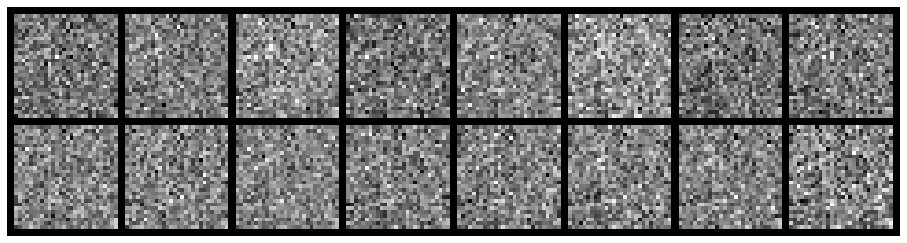

Epoch: [0/50], Batch Num: [0/600]
Discriminator Loss: 1.4258, Generator Loss: 0.7110
D(x): 0.4725, D(G(z)): 0.4911


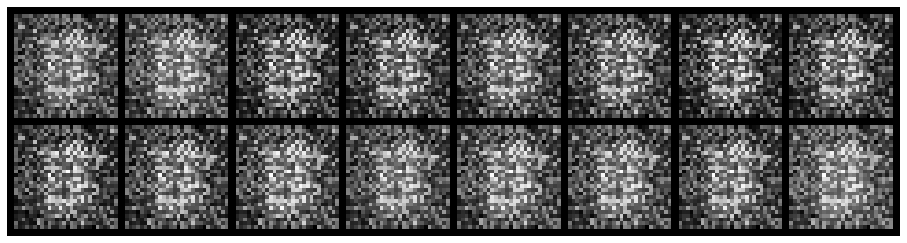

Epoch: [0/50], Batch Num: [100/600]
Discriminator Loss: 1.7026, Generator Loss: 0.9431
D(x): 0.7843, D(G(z)): 0.7410


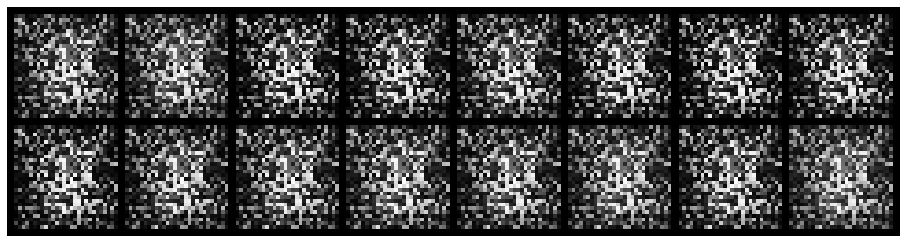

Epoch: [0/50], Batch Num: [200/600]
Discriminator Loss: 0.5179, Generator Loss: 4.6720
D(x): 0.8300, D(G(z)): 0.2038


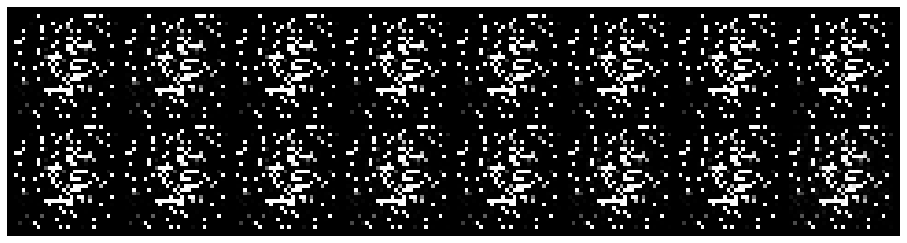

Epoch: [0/50], Batch Num: [300/600]
Discriminator Loss: 0.0133, Generator Loss: 7.3752
D(x): 0.9901, D(G(z)): 0.0031


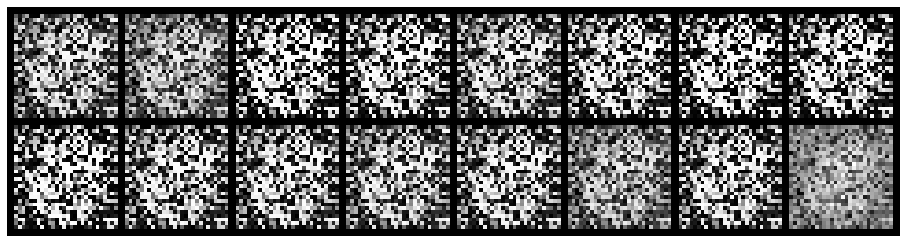

Epoch: [0/50], Batch Num: [400/600]
Discriminator Loss: 0.1200, Generator Loss: 9.8589
D(x): 0.9972, D(G(z)): 0.0910


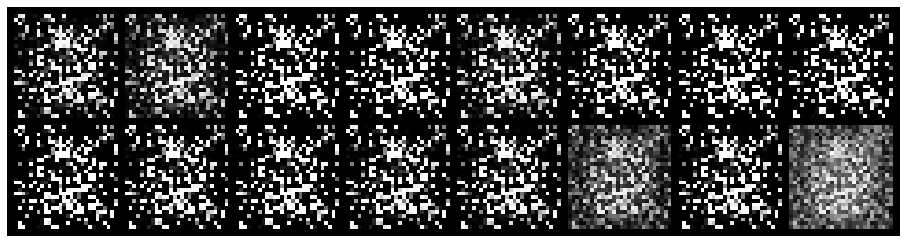

Epoch: [0/50], Batch Num: [500/600]
Discriminator Loss: 0.0743, Generator Loss: 9.2485
D(x): 0.9656, D(G(z)): 0.0322


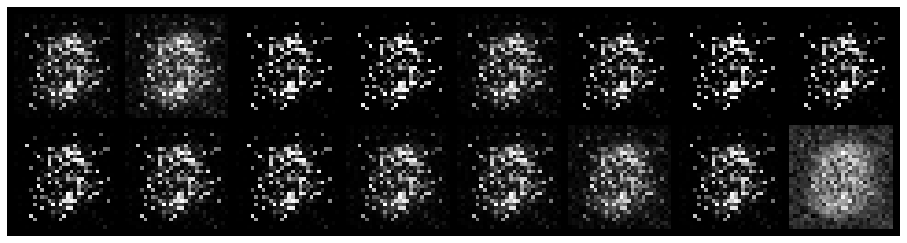

Epoch: [1/50], Batch Num: [0/600]
Discriminator Loss: 0.8763, Generator Loss: 7.9458
D(x): 0.8277, D(G(z)): 0.2051


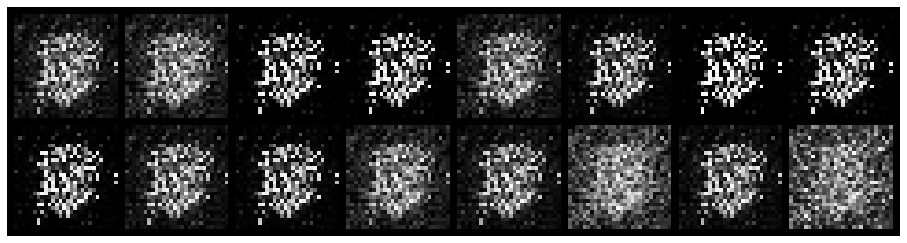

Epoch: [1/50], Batch Num: [100/600]
Discriminator Loss: 0.8431, Generator Loss: 5.6950
D(x): 0.8826, D(G(z)): 0.3122


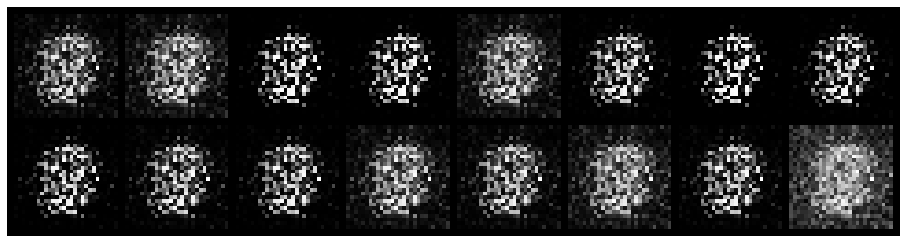

Epoch: [1/50], Batch Num: [200/600]
Discriminator Loss: 0.0295, Generator Loss: 8.8698
D(x): 0.9784, D(G(z)): 0.0049


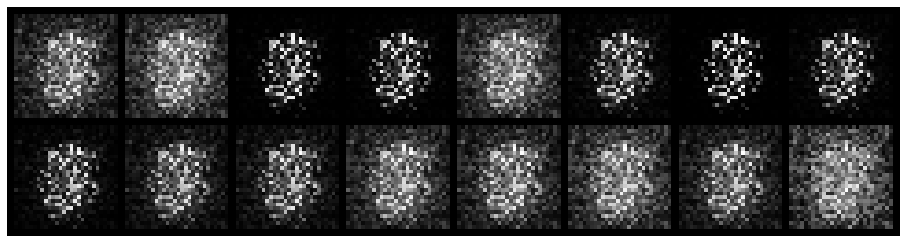

Epoch: [1/50], Batch Num: [300/600]
Discriminator Loss: 0.4987, Generator Loss: 5.2815
D(x): 0.8597, D(G(z)): 0.1799


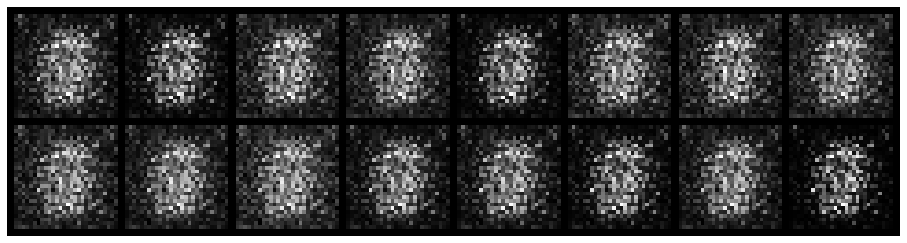

Epoch: [1/50], Batch Num: [400/600]
Discriminator Loss: 0.4133, Generator Loss: 4.0508
D(x): 0.8998, D(G(z)): 0.1915


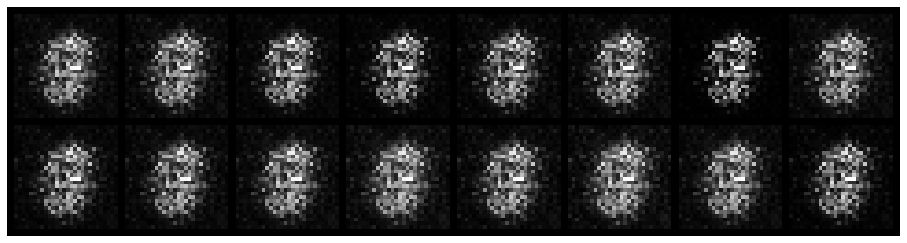

Epoch: [1/50], Batch Num: [500/600]
Discriminator Loss: 0.6502, Generator Loss: 4.0175
D(x): 0.8236, D(G(z)): 0.2117


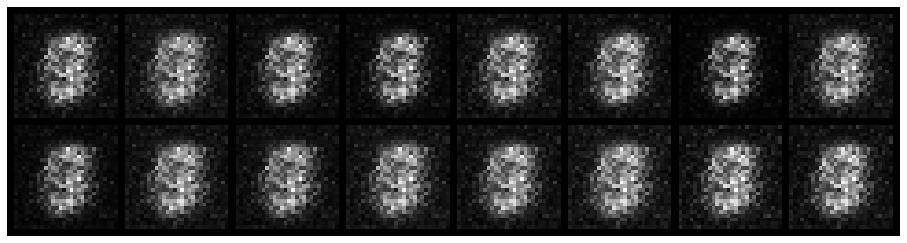

Epoch: [2/50], Batch Num: [0/600]
Discriminator Loss: 1.9801, Generator Loss: 0.7198
D(x): 0.5452, D(G(z)): 0.6097


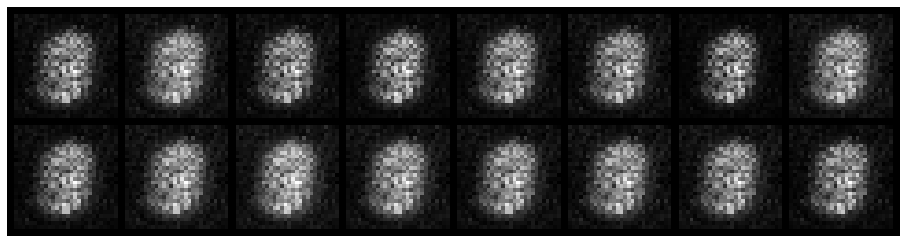

Epoch: [2/50], Batch Num: [100/600]
Discriminator Loss: 1.0195, Generator Loss: 1.8256
D(x): 0.7508, D(G(z)): 0.4237


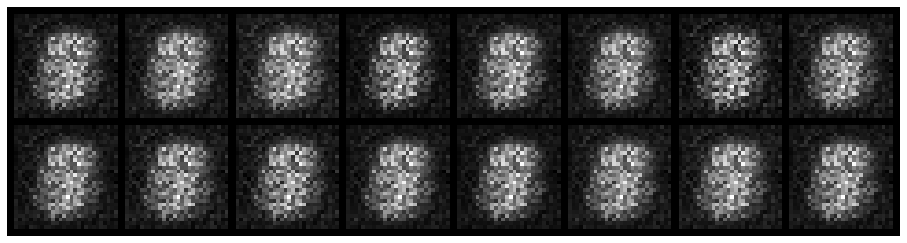

Epoch: [2/50], Batch Num: [200/600]
Discriminator Loss: 0.2102, Generator Loss: 3.1564
D(x): 0.9108, D(G(z)): 0.0880


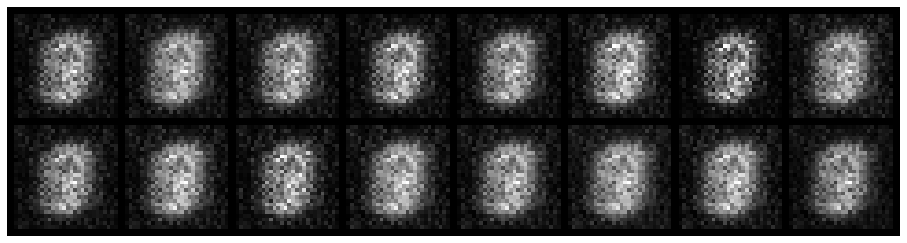

Epoch: [2/50], Batch Num: [300/600]
Discriminator Loss: 0.4155, Generator Loss: 2.3568
D(x): 0.9026, D(G(z)): 0.2171


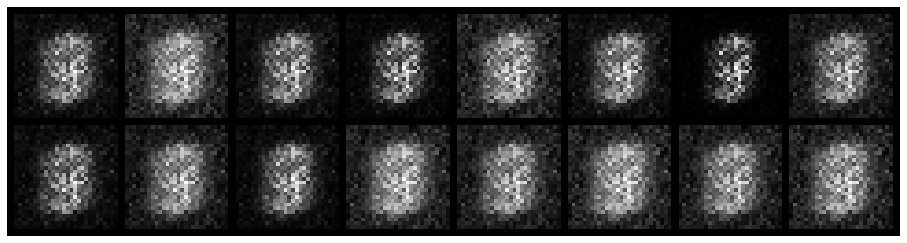

Epoch: [2/50], Batch Num: [400/600]
Discriminator Loss: 0.3509, Generator Loss: 4.8293
D(x): 0.8695, D(G(z)): 0.0863


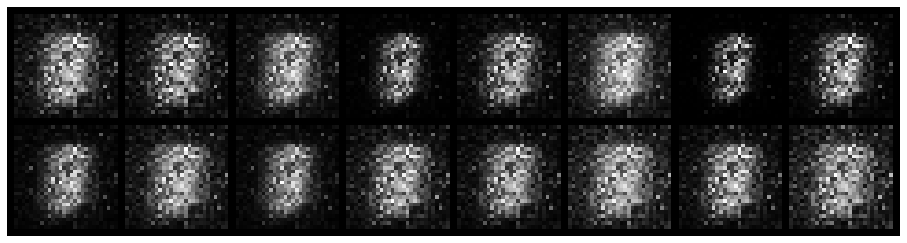

Epoch: [2/50], Batch Num: [500/600]
Discriminator Loss: 0.2059, Generator Loss: 4.2640
D(x): 0.9443, D(G(z)): 0.0789


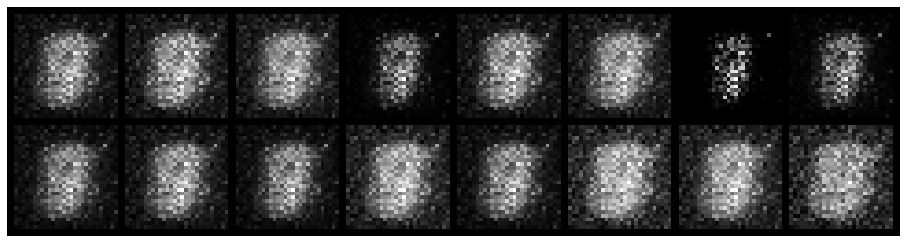

Epoch: [3/50], Batch Num: [0/600]
Discriminator Loss: 0.3015, Generator Loss: 3.5180
D(x): 0.9200, D(G(z)): 0.0957


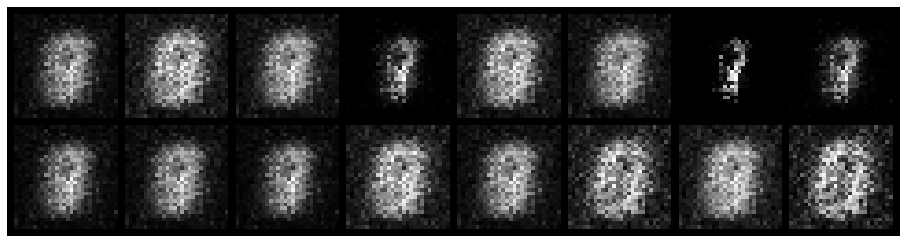

Epoch: [3/50], Batch Num: [100/600]
Discriminator Loss: 0.2583, Generator Loss: 4.8385
D(x): 0.9201, D(G(z)): 0.0592


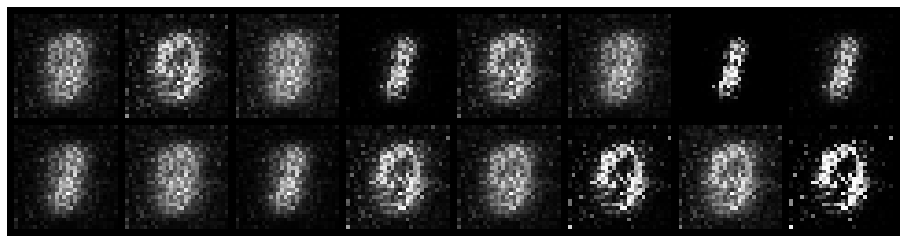

Epoch: [3/50], Batch Num: [200/600]
Discriminator Loss: 0.5849, Generator Loss: 5.1131
D(x): 0.8012, D(G(z)): 0.0322


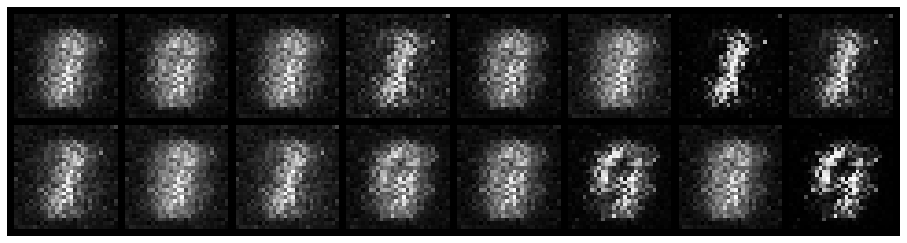

Epoch: [3/50], Batch Num: [300/600]
Discriminator Loss: 0.1158, Generator Loss: 4.8262
D(x): 0.9736, D(G(z)): 0.0658


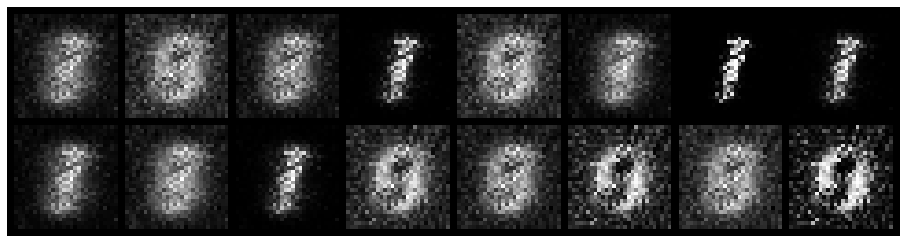

Epoch: [3/50], Batch Num: [400/600]
Discriminator Loss: 0.3381, Generator Loss: 4.8290
D(x): 0.8685, D(G(z)): 0.0457


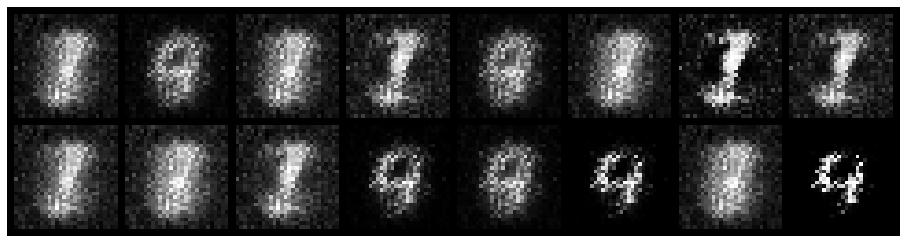

Epoch: [3/50], Batch Num: [500/600]
Discriminator Loss: 0.3235, Generator Loss: 3.8430
D(x): 0.8958, D(G(z)): 0.0914


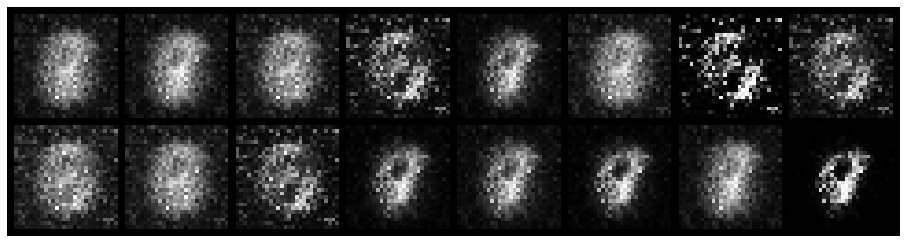

Epoch: [4/50], Batch Num: [0/600]
Discriminator Loss: 0.6700, Generator Loss: 3.3994
D(x): 0.7773, D(G(z)): 0.0479


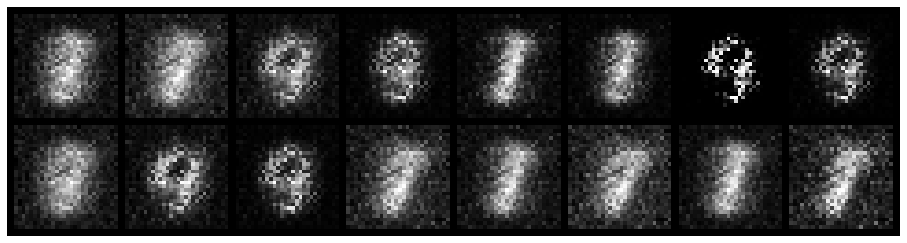

Epoch: [4/50], Batch Num: [100/600]
Discriminator Loss: 0.3034, Generator Loss: 5.9460
D(x): 0.9187, D(G(z)): 0.0438


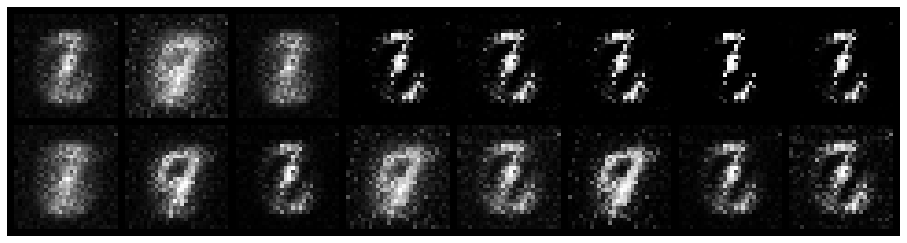

Epoch: [4/50], Batch Num: [200/600]
Discriminator Loss: 0.4673, Generator Loss: 5.4939
D(x): 0.8540, D(G(z)): 0.0508


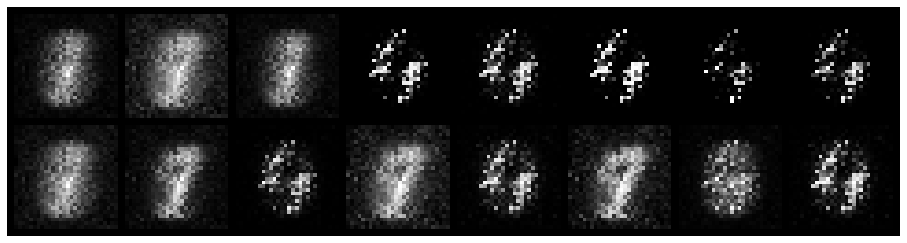

Epoch: [4/50], Batch Num: [300/600]
Discriminator Loss: 0.2057, Generator Loss: 5.7363
D(x): 0.9485, D(G(z)): 0.0675


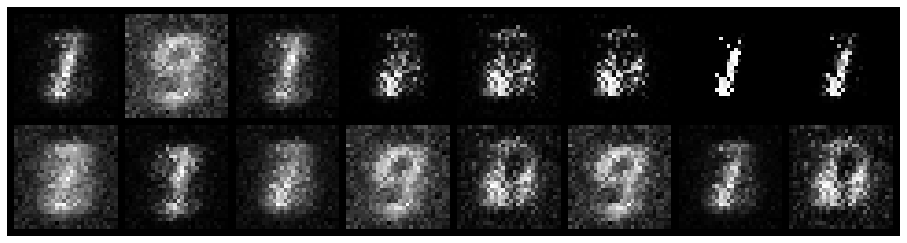

Epoch: [4/50], Batch Num: [400/600]
Discriminator Loss: 0.2858, Generator Loss: 5.0409
D(x): 0.8681, D(G(z)): 0.0285


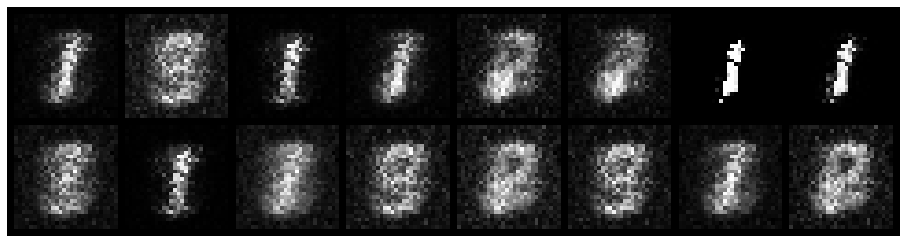

Epoch: [4/50], Batch Num: [500/600]
Discriminator Loss: 0.3122, Generator Loss: 3.2079
D(x): 0.8851, D(G(z)): 0.0671


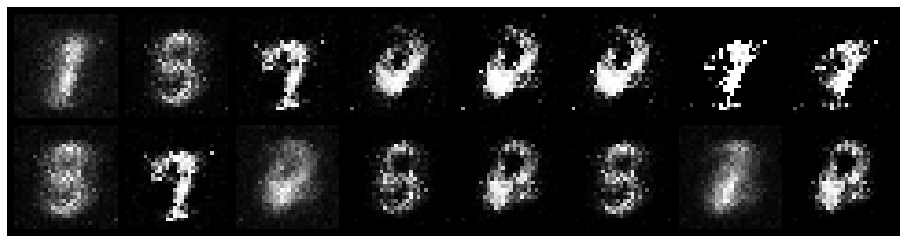

Epoch: [5/50], Batch Num: [0/600]
Discriminator Loss: 0.4755, Generator Loss: 4.0968
D(x): 0.8736, D(G(z)): 0.1764


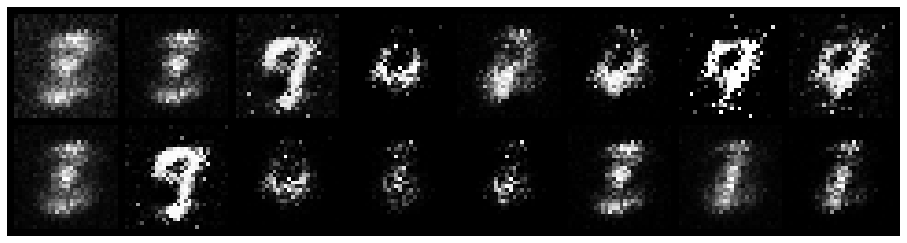

Epoch: [5/50], Batch Num: [100/600]
Discriminator Loss: 0.1855, Generator Loss: 4.5549
D(x): 0.9465, D(G(z)): 0.0837


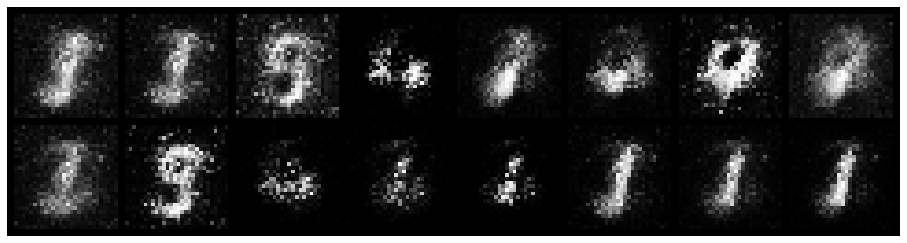

Epoch: [5/50], Batch Num: [200/600]
Discriminator Loss: 0.3257, Generator Loss: 4.1551
D(x): 0.8858, D(G(z)): 0.0787


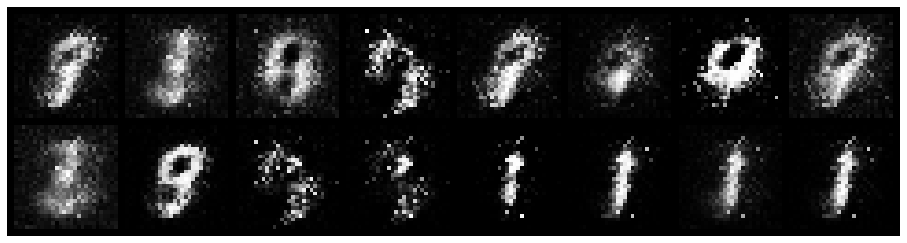

Epoch: [5/50], Batch Num: [300/600]
Discriminator Loss: 0.3851, Generator Loss: 3.4605
D(x): 0.9072, D(G(z)): 0.1265


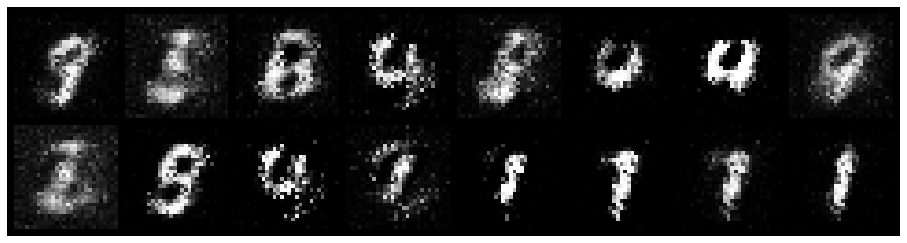

Epoch: [5/50], Batch Num: [400/600]
Discriminator Loss: 0.3223, Generator Loss: 2.6715
D(x): 0.8966, D(G(z)): 0.0972


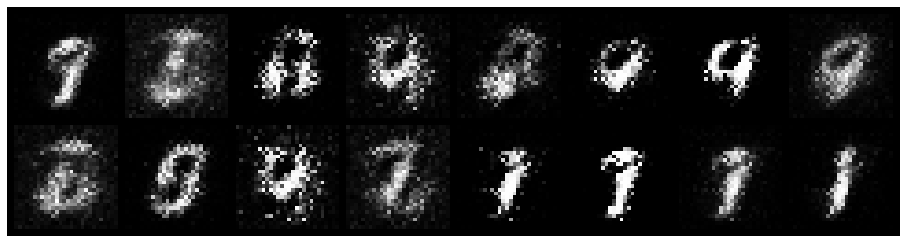

Epoch: [5/50], Batch Num: [500/600]
Discriminator Loss: 0.6194, Generator Loss: 4.5324
D(x): 0.7572, D(G(z)): 0.0960


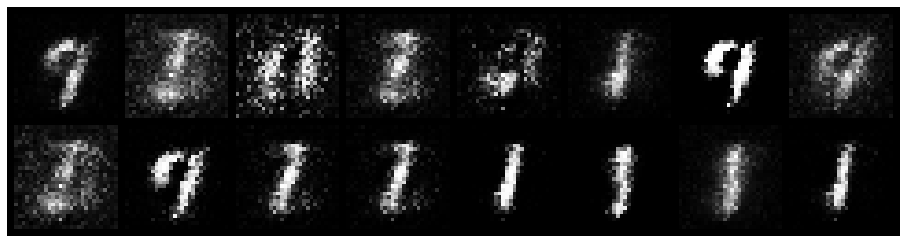

Epoch: [6/50], Batch Num: [0/600]
Discriminator Loss: 0.7596, Generator Loss: 3.1623
D(x): 0.7606, D(G(z)): 0.1124


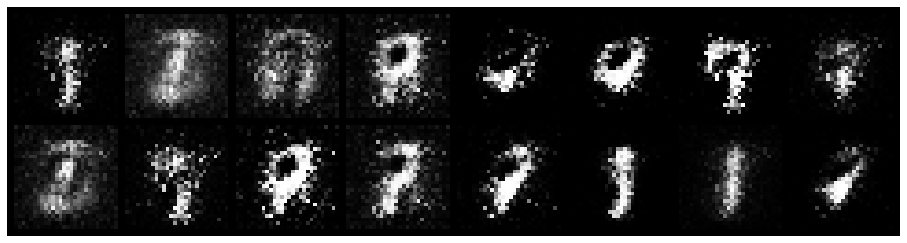

Epoch: [6/50], Batch Num: [100/600]
Discriminator Loss: 0.5285, Generator Loss: 3.7270
D(x): 0.8954, D(G(z)): 0.2033


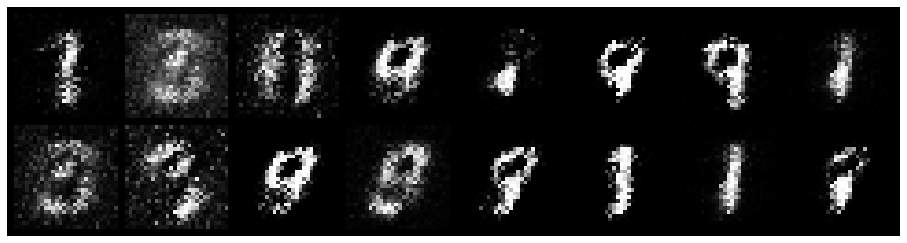

Epoch: [6/50], Batch Num: [200/600]
Discriminator Loss: 0.4294, Generator Loss: 2.8409
D(x): 0.8288, D(G(z)): 0.1002


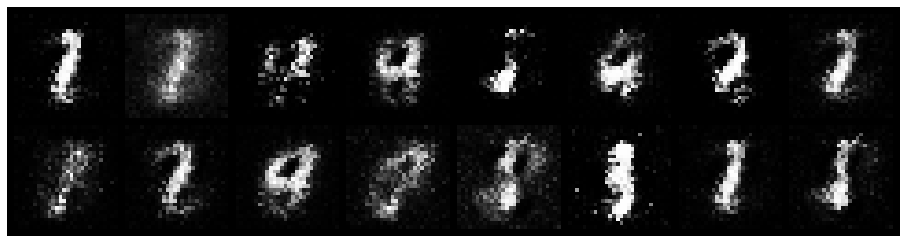

Epoch: [6/50], Batch Num: [300/600]
Discriminator Loss: 0.5324, Generator Loss: 3.1276
D(x): 0.8059, D(G(z)): 0.1121


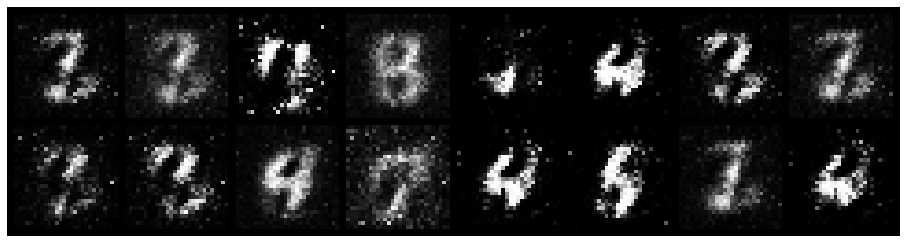

Epoch: [6/50], Batch Num: [400/600]
Discriminator Loss: 0.5134, Generator Loss: 3.7438
D(x): 0.8164, D(G(z)): 0.1002


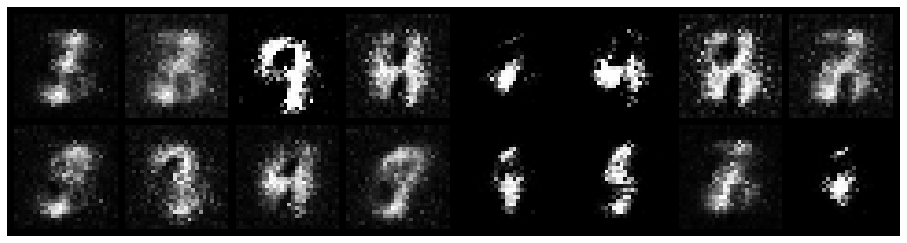

Epoch: [6/50], Batch Num: [500/600]
Discriminator Loss: 0.3426, Generator Loss: 3.8074
D(x): 0.8616, D(G(z)): 0.0601


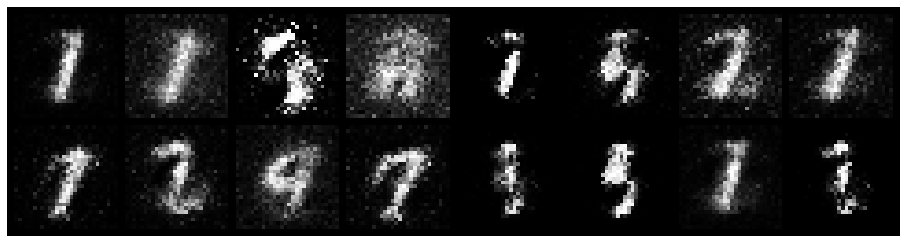

Epoch: [7/50], Batch Num: [0/600]
Discriminator Loss: 0.7478, Generator Loss: 2.0703
D(x): 0.7944, D(G(z)): 0.1658


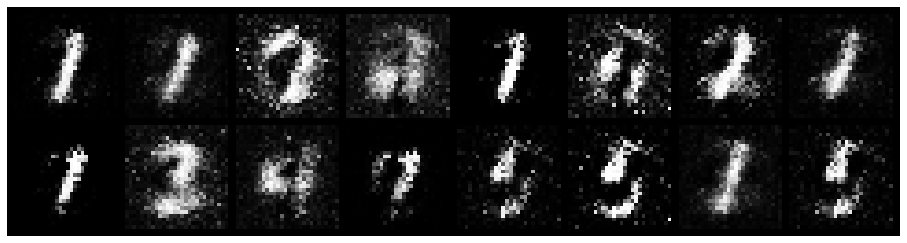

Epoch: [7/50], Batch Num: [100/600]
Discriminator Loss: 0.3543, Generator Loss: 3.4355
D(x): 0.9282, D(G(z)): 0.1631


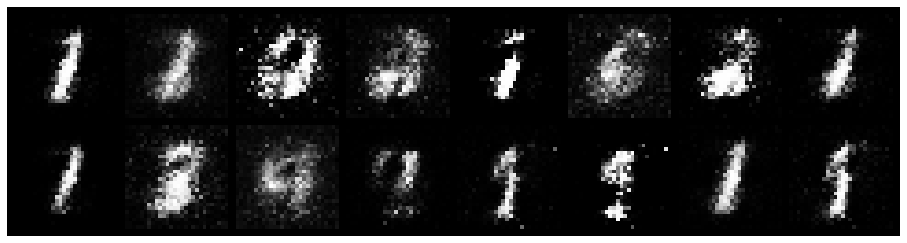

Epoch: [7/50], Batch Num: [200/600]
Discriminator Loss: 0.3359, Generator Loss: 2.8101
D(x): 0.8972, D(G(z)): 0.1219


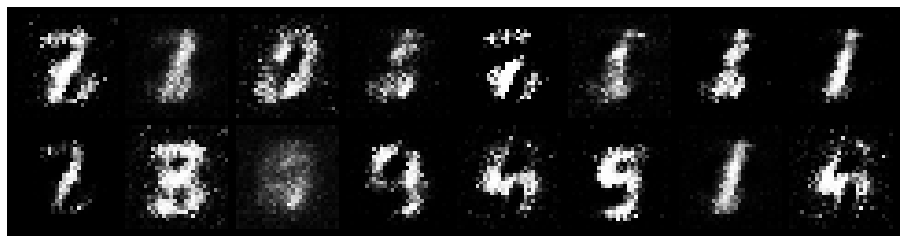

Epoch: [7/50], Batch Num: [300/600]
Discriminator Loss: 0.5406, Generator Loss: 3.1963
D(x): 0.8184, D(G(z)): 0.1646


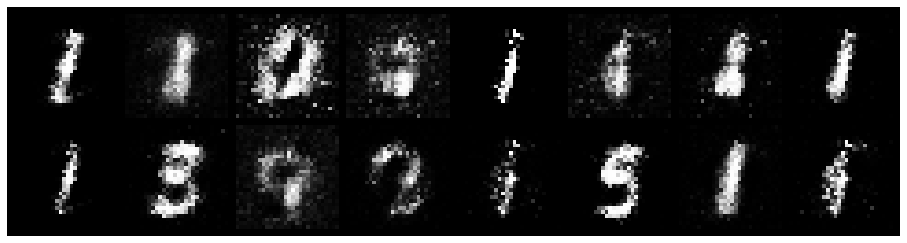

Epoch: [7/50], Batch Num: [400/600]
Discriminator Loss: 0.4580, Generator Loss: 3.1765
D(x): 0.9060, D(G(z)): 0.1620


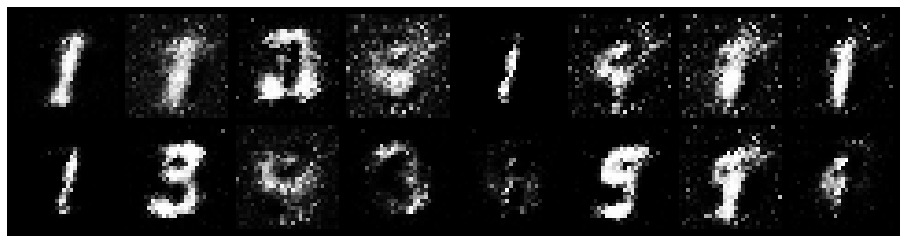

Epoch: [7/50], Batch Num: [500/600]
Discriminator Loss: 0.4830, Generator Loss: 2.5888
D(x): 0.8493, D(G(z)): 0.1311


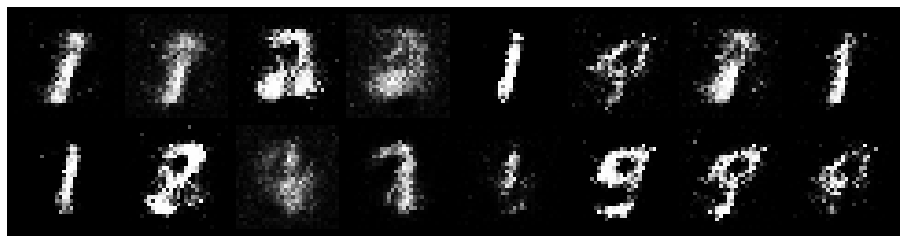

Epoch: [8/50], Batch Num: [0/600]
Discriminator Loss: 0.3879, Generator Loss: 3.9103
D(x): 0.8612, D(G(z)): 0.0977


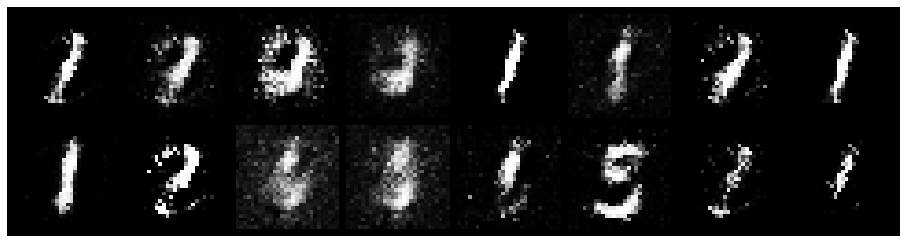

Epoch: [8/50], Batch Num: [100/600]
Discriminator Loss: 0.6054, Generator Loss: 3.1373
D(x): 0.8534, D(G(z)): 0.1966


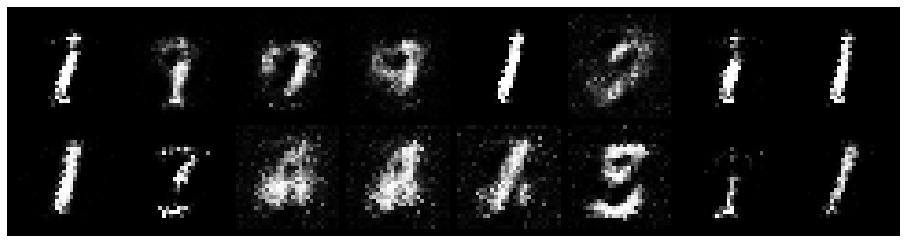

Epoch: [8/50], Batch Num: [200/600]
Discriminator Loss: 0.4821, Generator Loss: 3.7856
D(x): 0.8148, D(G(z)): 0.1030


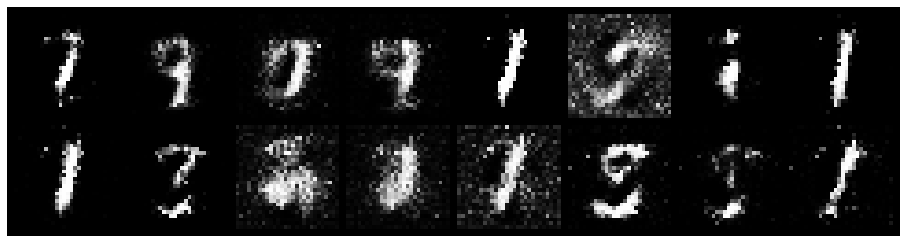

Epoch: [8/50], Batch Num: [300/600]
Discriminator Loss: 0.5096, Generator Loss: 3.3272
D(x): 0.8592, D(G(z)): 0.1621


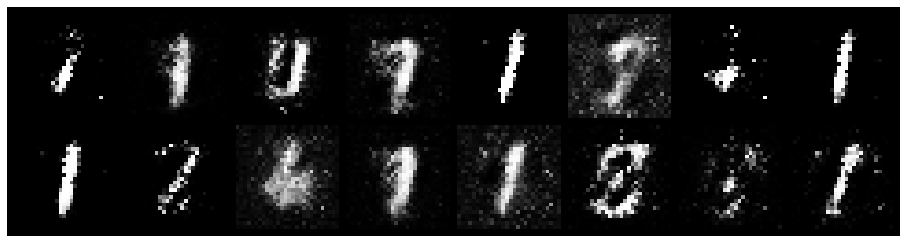

Epoch: [8/50], Batch Num: [400/600]
Discriminator Loss: 0.4736, Generator Loss: 2.0267
D(x): 0.8780, D(G(z)): 0.1958


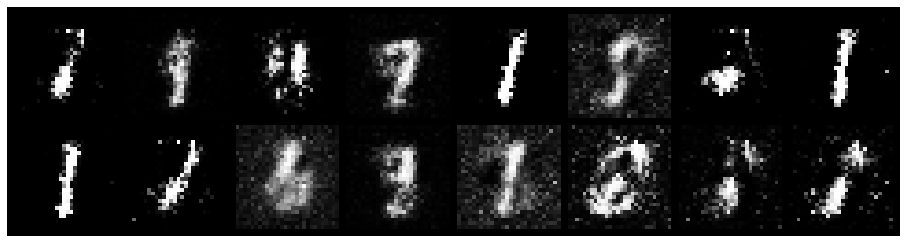

Epoch: [8/50], Batch Num: [500/600]
Discriminator Loss: 0.5003, Generator Loss: 3.1394
D(x): 0.8342, D(G(z)): 0.1212


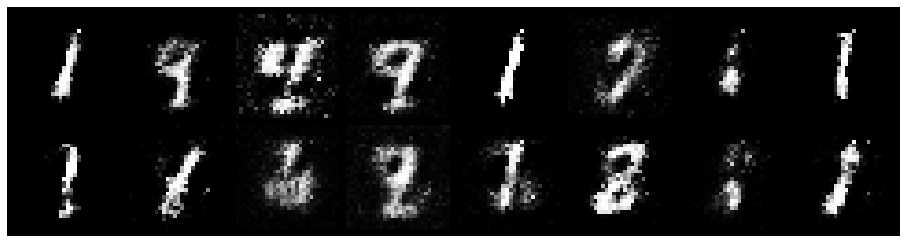

Epoch: [9/50], Batch Num: [0/600]
Discriminator Loss: 0.5340, Generator Loss: 2.5289
D(x): 0.7976, D(G(z)): 0.1367


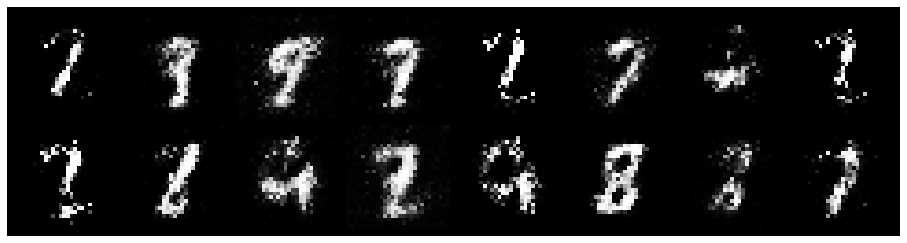

Epoch: [9/50], Batch Num: [100/600]
Discriminator Loss: 0.5809, Generator Loss: 2.7369
D(x): 0.7959, D(G(z)): 0.1469


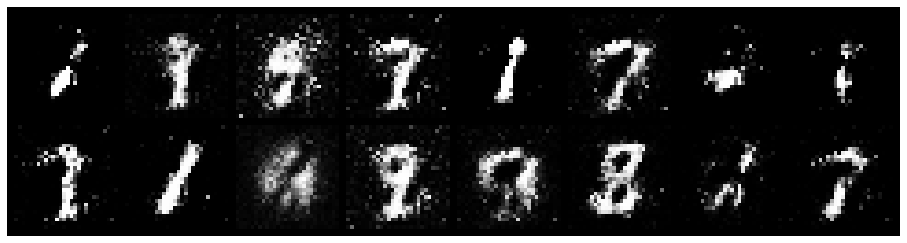

Epoch: [9/50], Batch Num: [200/600]
Discriminator Loss: 0.4489, Generator Loss: 4.3953
D(x): 0.8199, D(G(z)): 0.0921


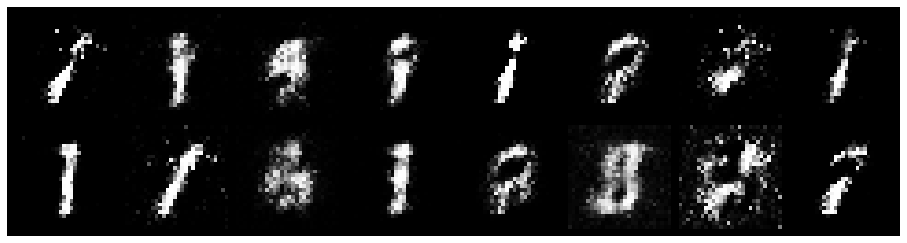

Epoch: [9/50], Batch Num: [300/600]
Discriminator Loss: 0.7817, Generator Loss: 2.2308
D(x): 0.8197, D(G(z)): 0.2864


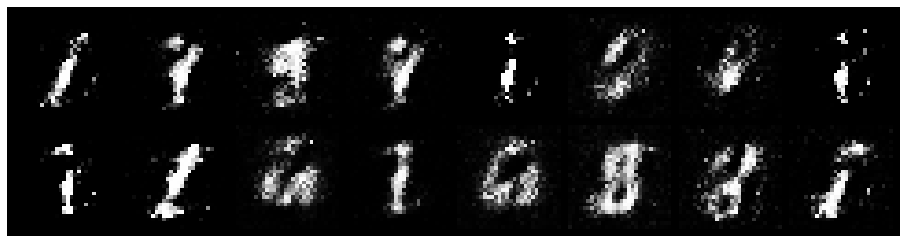

Epoch: [9/50], Batch Num: [400/600]
Discriminator Loss: 0.3423, Generator Loss: 3.0089
D(x): 0.8750, D(G(z)): 0.1330


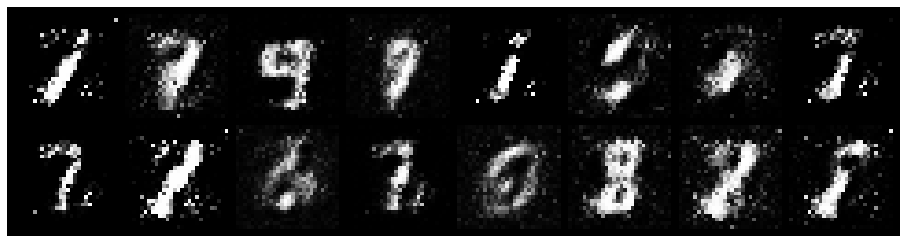

Epoch: [9/50], Batch Num: [500/600]
Discriminator Loss: 0.5592, Generator Loss: 4.2434
D(x): 0.8548, D(G(z)): 0.1874


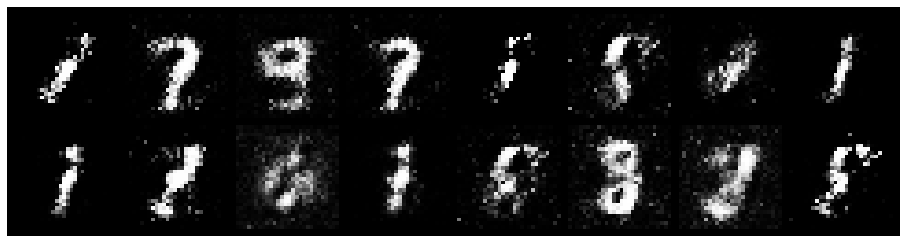

Epoch: [10/50], Batch Num: [0/600]
Discriminator Loss: 0.5784, Generator Loss: 2.6098
D(x): 0.8310, D(G(z)): 0.1505


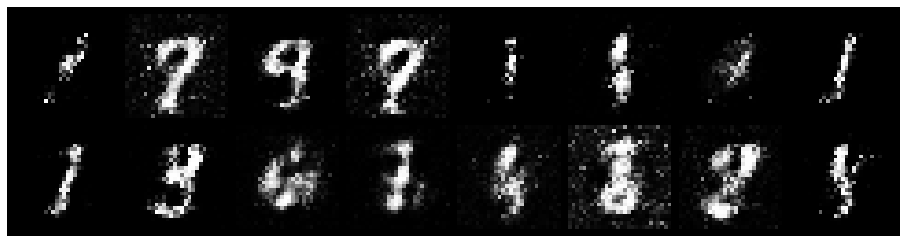

Epoch: [10/50], Batch Num: [100/600]
Discriminator Loss: 0.3906, Generator Loss: 3.0212
D(x): 0.8241, D(G(z)): 0.0861


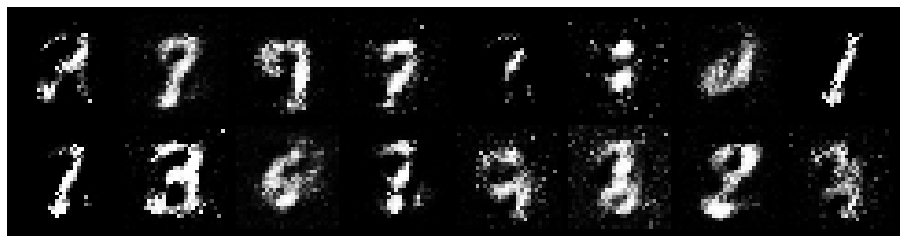

Epoch: [10/50], Batch Num: [200/600]
Discriminator Loss: 0.5913, Generator Loss: 2.1126
D(x): 0.8246, D(G(z)): 0.2225


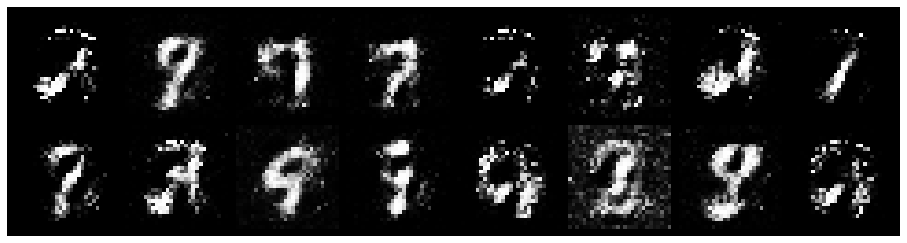

Epoch: [10/50], Batch Num: [300/600]
Discriminator Loss: 0.5529, Generator Loss: 2.5778
D(x): 0.8737, D(G(z)): 0.2371


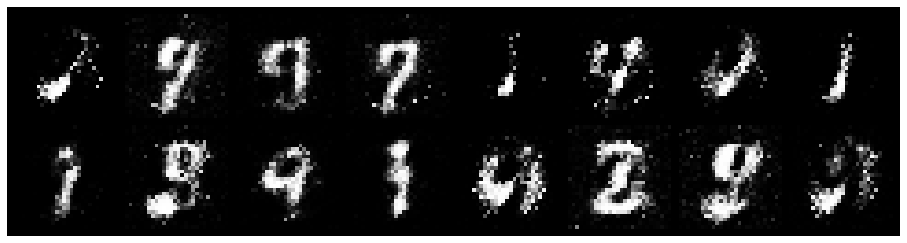

Epoch: [10/50], Batch Num: [400/600]
Discriminator Loss: 0.6217, Generator Loss: 2.5228
D(x): 0.7596, D(G(z)): 0.1359


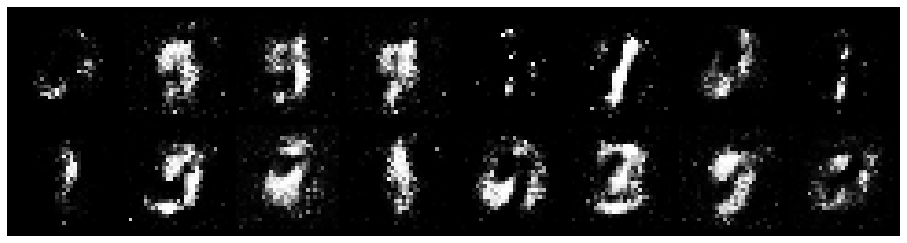

Epoch: [10/50], Batch Num: [500/600]
Discriminator Loss: 0.5729, Generator Loss: 2.3422
D(x): 0.8704, D(G(z)): 0.2293


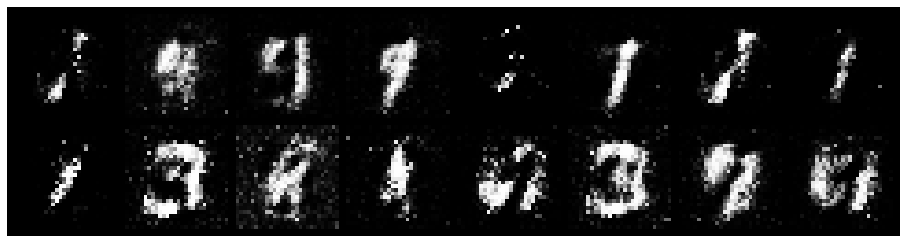

Epoch: [11/50], Batch Num: [0/600]
Discriminator Loss: 0.6716, Generator Loss: 2.6712
D(x): 0.7294, D(G(z)): 0.1661


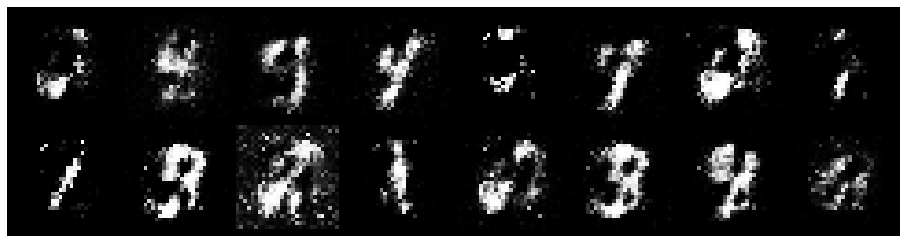

Epoch: [11/50], Batch Num: [100/600]
Discriminator Loss: 0.5062, Generator Loss: 3.3163
D(x): 0.8409, D(G(z)): 0.1631


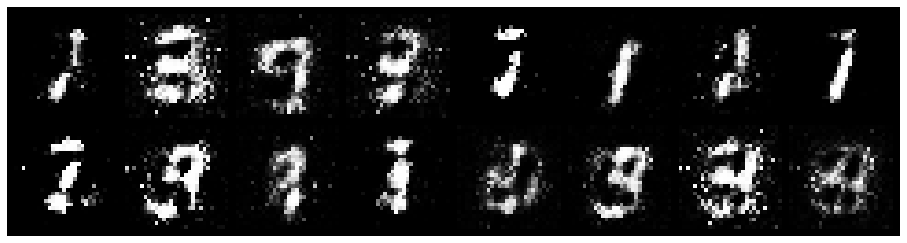

Epoch: [11/50], Batch Num: [200/600]
Discriminator Loss: 0.5405, Generator Loss: 1.9894
D(x): 0.8513, D(G(z)): 0.2247


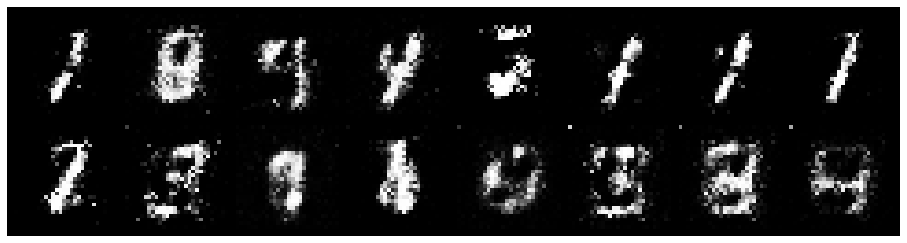

Epoch: [11/50], Batch Num: [300/600]
Discriminator Loss: 0.5740, Generator Loss: 3.2052
D(x): 0.8187, D(G(z)): 0.1619


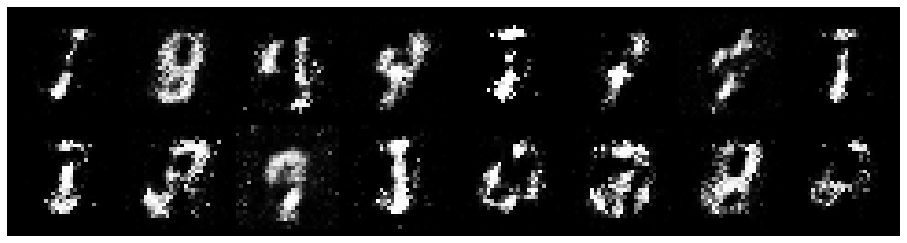

Epoch: [11/50], Batch Num: [400/600]
Discriminator Loss: 0.6115, Generator Loss: 2.3093
D(x): 0.7888, D(G(z)): 0.1823


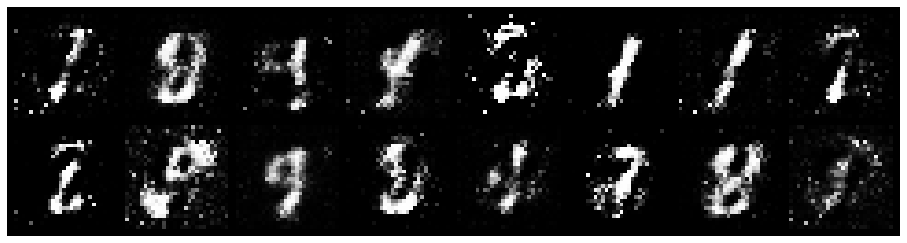

Epoch: [11/50], Batch Num: [500/600]
Discriminator Loss: 0.7897, Generator Loss: 2.2639
D(x): 0.7559, D(G(z)): 0.1972


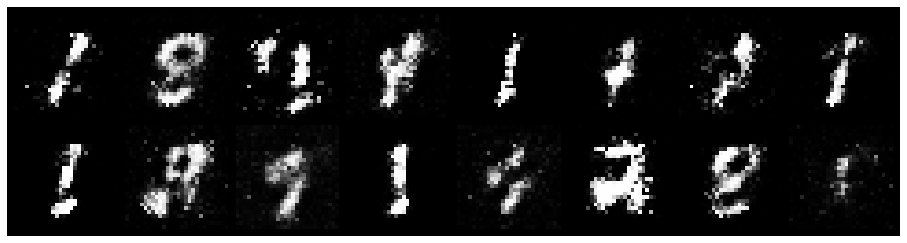

Epoch: [12/50], Batch Num: [0/600]
Discriminator Loss: 0.9603, Generator Loss: 1.7600
D(x): 0.6350, D(G(z)): 0.1969


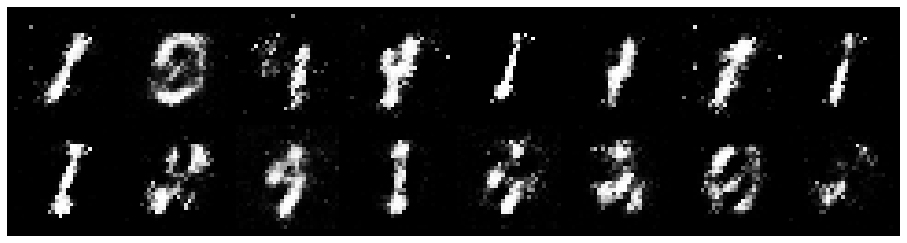

Epoch: [12/50], Batch Num: [100/600]
Discriminator Loss: 0.7485, Generator Loss: 2.5196
D(x): 0.7995, D(G(z)): 0.2415


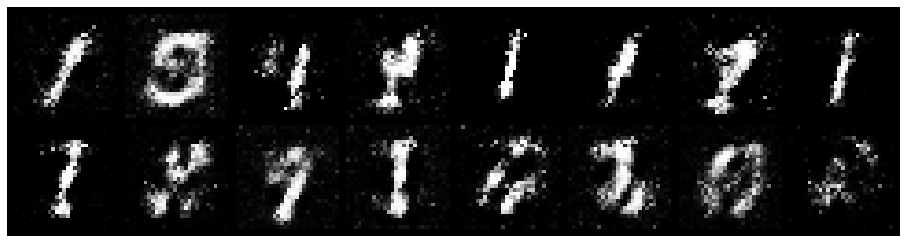

Epoch: [12/50], Batch Num: [200/600]
Discriminator Loss: 0.4657, Generator Loss: 3.2469
D(x): 0.8162, D(G(z)): 0.1200


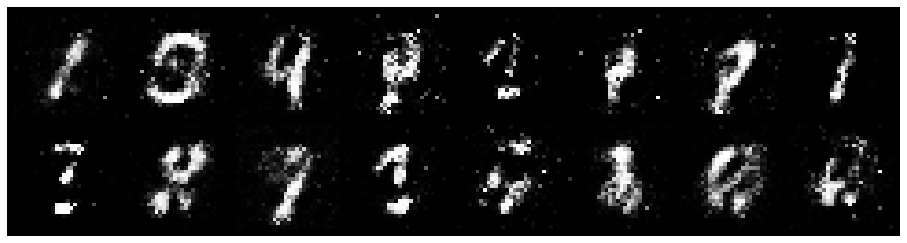

Epoch: [12/50], Batch Num: [300/600]
Discriminator Loss: 0.4907, Generator Loss: 2.8258
D(x): 0.8180, D(G(z)): 0.1555


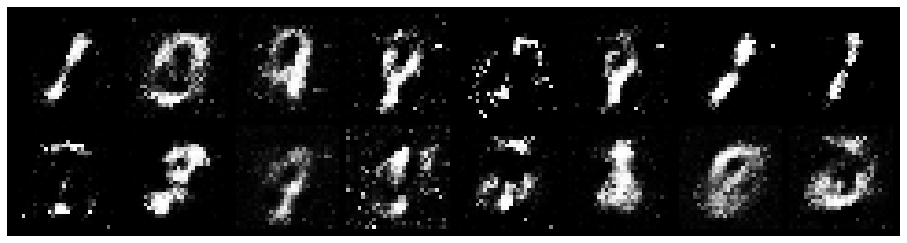

Epoch: [12/50], Batch Num: [400/600]
Discriminator Loss: 0.7296, Generator Loss: 2.4301
D(x): 0.7754, D(G(z)): 0.2531


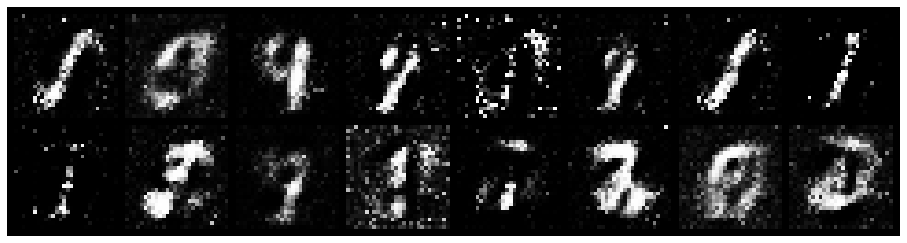

Epoch: [12/50], Batch Num: [500/600]
Discriminator Loss: 0.8358, Generator Loss: 2.4742
D(x): 0.6932, D(G(z)): 0.2059


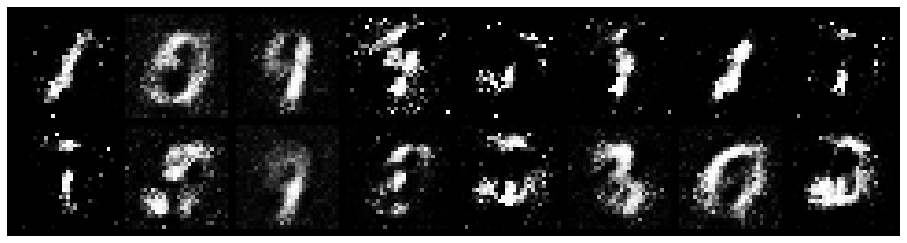

Epoch: [13/50], Batch Num: [0/600]
Discriminator Loss: 0.8415, Generator Loss: 2.0484
D(x): 0.7730, D(G(z)): 0.2943


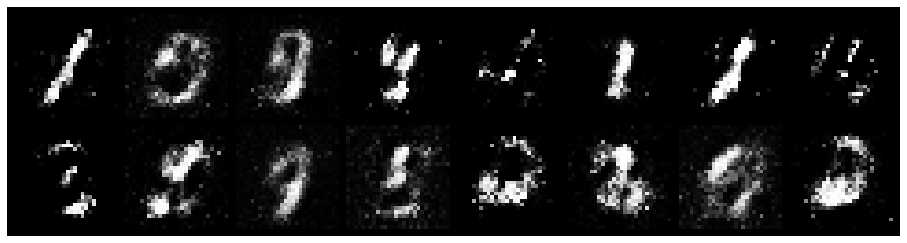

Epoch: [13/50], Batch Num: [100/600]
Discriminator Loss: 0.6145, Generator Loss: 2.7789
D(x): 0.8022, D(G(z)): 0.1896


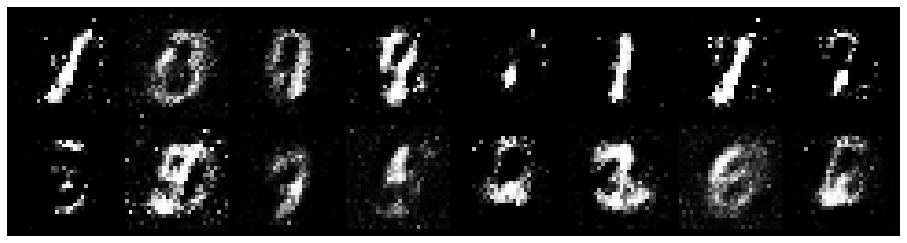

Epoch: [13/50], Batch Num: [200/600]
Discriminator Loss: 0.5542, Generator Loss: 2.7415
D(x): 0.8460, D(G(z)): 0.1942


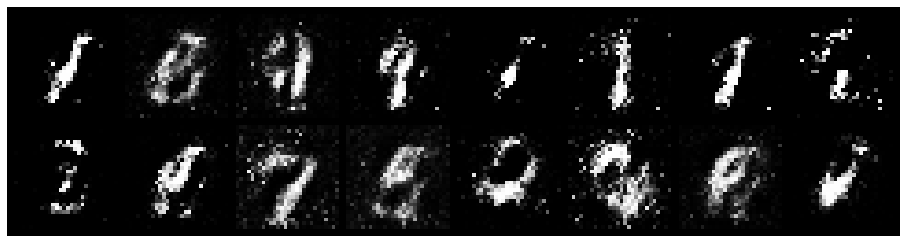

Epoch: [13/50], Batch Num: [300/600]
Discriminator Loss: 0.6824, Generator Loss: 2.8528
D(x): 0.8086, D(G(z)): 0.2272


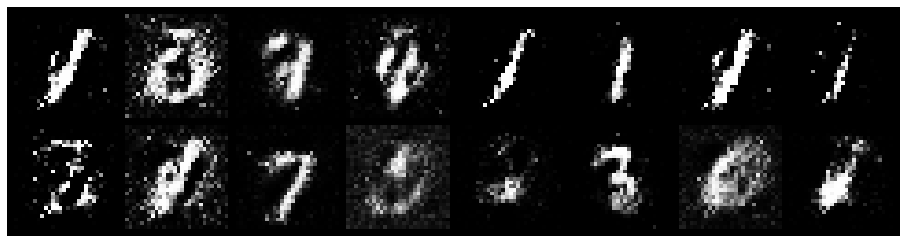

Epoch: [13/50], Batch Num: [400/600]
Discriminator Loss: 0.8571, Generator Loss: 2.3350
D(x): 0.7566, D(G(z)): 0.2285


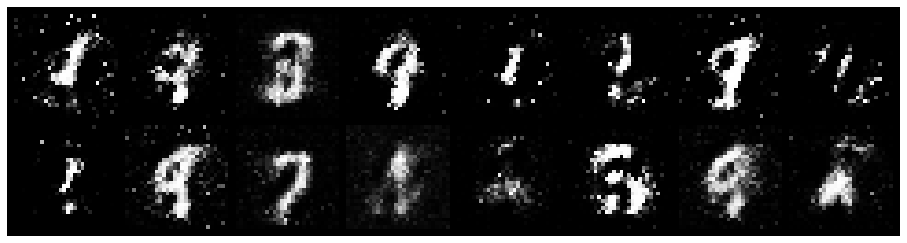

Epoch: [13/50], Batch Num: [500/600]
Discriminator Loss: 0.5125, Generator Loss: 2.5806
D(x): 0.7601, D(G(z)): 0.0993


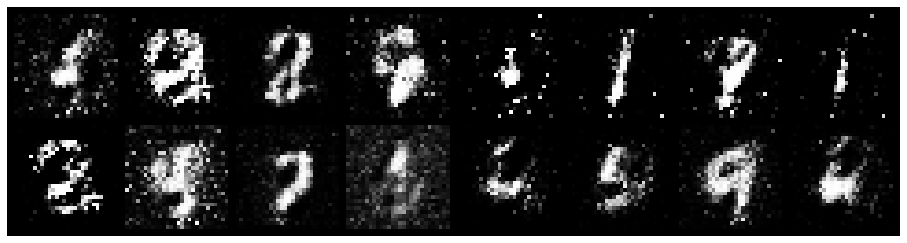

Epoch: [14/50], Batch Num: [0/600]
Discriminator Loss: 0.5667, Generator Loss: 1.5273
D(x): 0.8577, D(G(z)): 0.2595


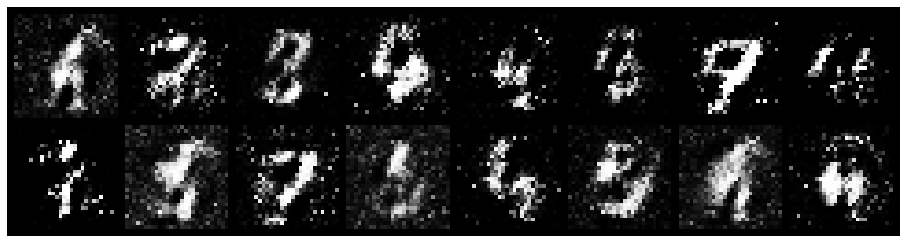

Epoch: [14/50], Batch Num: [100/600]
Discriminator Loss: 0.6444, Generator Loss: 2.5932
D(x): 0.8003, D(G(z)): 0.2434


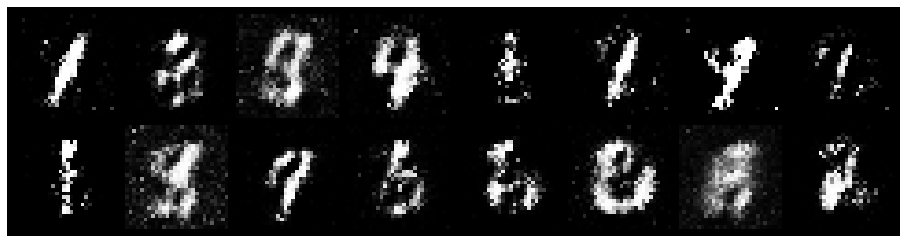

Epoch: [14/50], Batch Num: [200/600]
Discriminator Loss: 0.9470, Generator Loss: 2.1019
D(x): 0.7073, D(G(z)): 0.2321


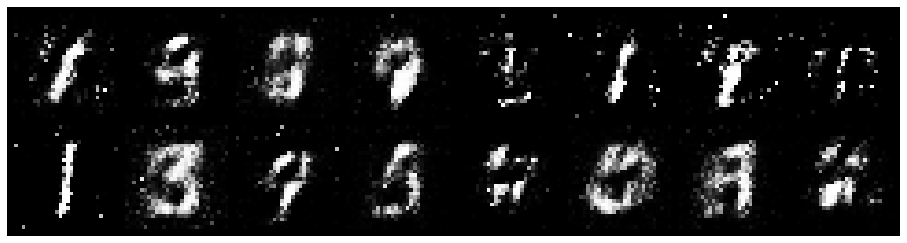

Epoch: [14/50], Batch Num: [300/600]
Discriminator Loss: 0.8392, Generator Loss: 1.8585
D(x): 0.7438, D(G(z)): 0.2544


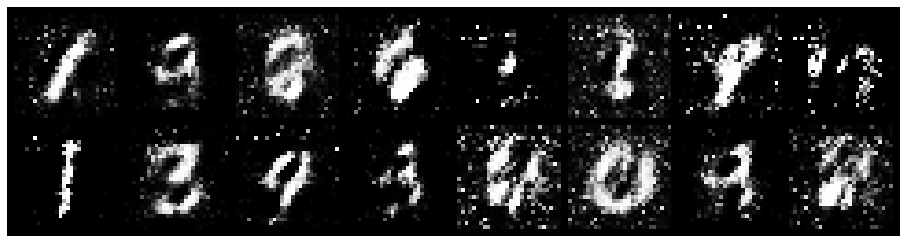

Epoch: [14/50], Batch Num: [400/600]
Discriminator Loss: 0.7084, Generator Loss: 2.0598
D(x): 0.7562, D(G(z)): 0.1992


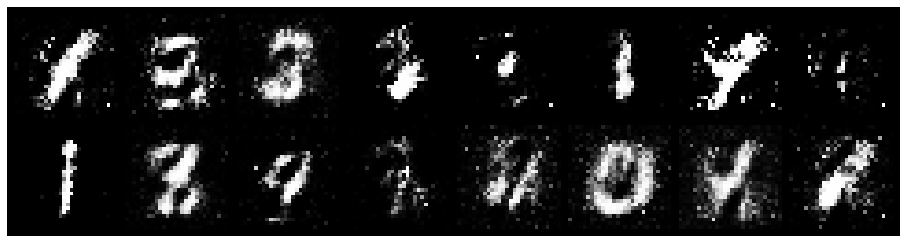

Epoch: [14/50], Batch Num: [500/600]
Discriminator Loss: 0.6023, Generator Loss: 2.4626
D(x): 0.7386, D(G(z)): 0.1368


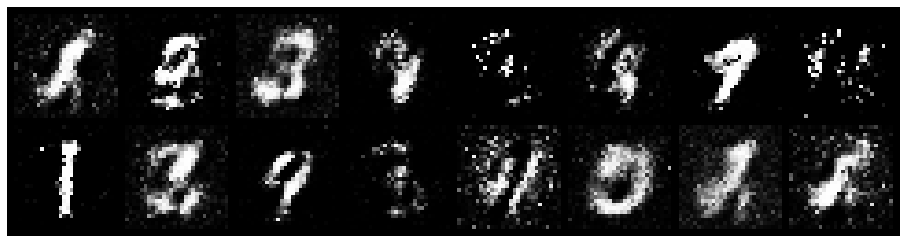

Epoch: [15/50], Batch Num: [0/600]
Discriminator Loss: 0.5808, Generator Loss: 3.0588
D(x): 0.7832, D(G(z)): 0.1562


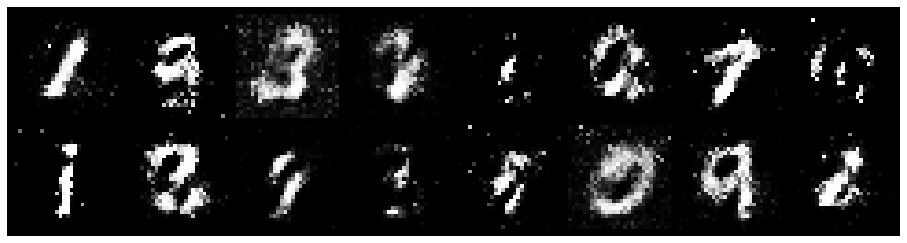

Epoch: [15/50], Batch Num: [100/600]
Discriminator Loss: 0.5592, Generator Loss: 2.7859
D(x): 0.7462, D(G(z)): 0.1264


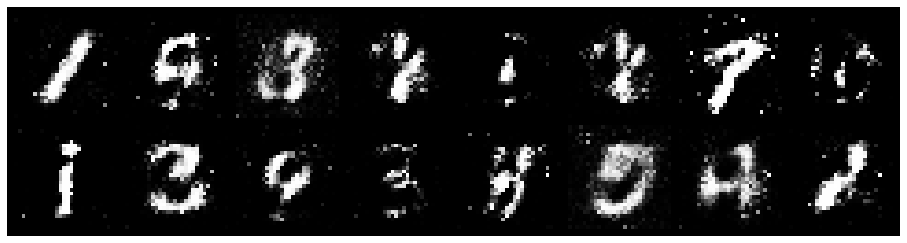

Epoch: [15/50], Batch Num: [200/600]
Discriminator Loss: 0.7135, Generator Loss: 2.7173
D(x): 0.7818, D(G(z)): 0.2387


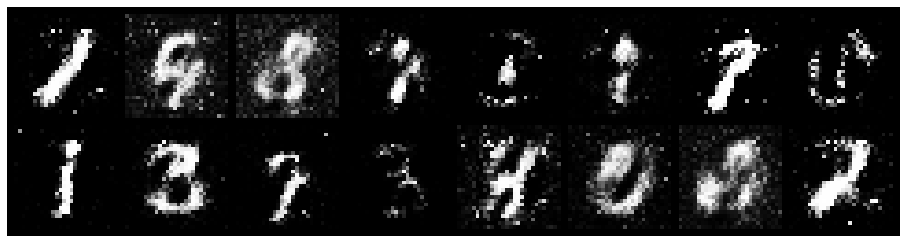

Epoch: [15/50], Batch Num: [300/600]
Discriminator Loss: 0.9998, Generator Loss: 1.8285
D(x): 0.6653, D(G(z)): 0.2317


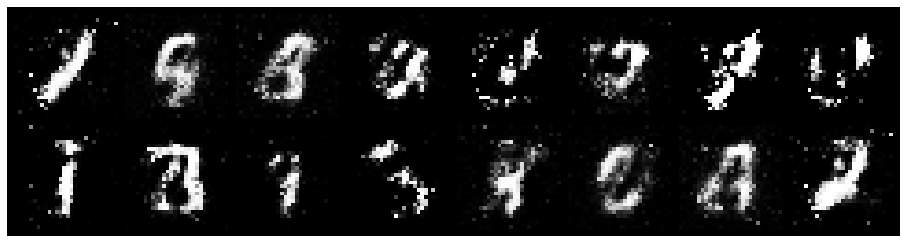

Epoch: [15/50], Batch Num: [400/600]
Discriminator Loss: 0.6207, Generator Loss: 2.3172
D(x): 0.7621, D(G(z)): 0.1576


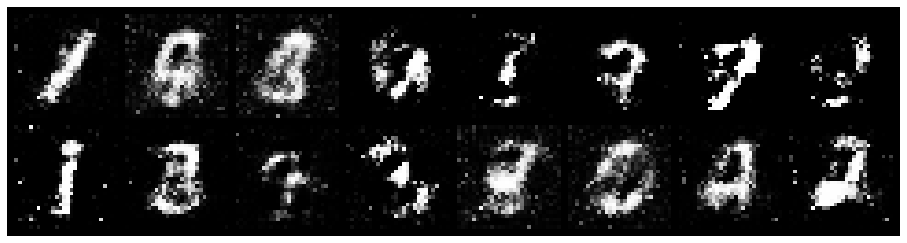

Epoch: [15/50], Batch Num: [500/600]
Discriminator Loss: 0.7912, Generator Loss: 2.4083
D(x): 0.7050, D(G(z)): 0.1867


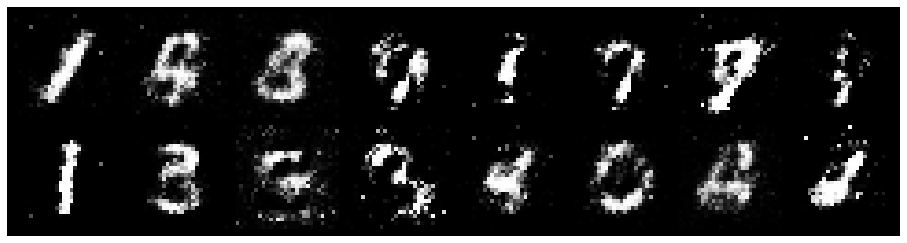

Epoch: [16/50], Batch Num: [0/600]
Discriminator Loss: 0.7017, Generator Loss: 1.8749
D(x): 0.8180, D(G(z)): 0.2955


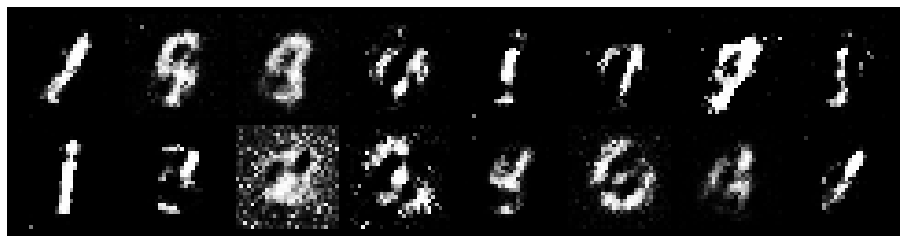

Epoch: [16/50], Batch Num: [100/600]
Discriminator Loss: 0.6546, Generator Loss: 2.4445
D(x): 0.7549, D(G(z)): 0.1779


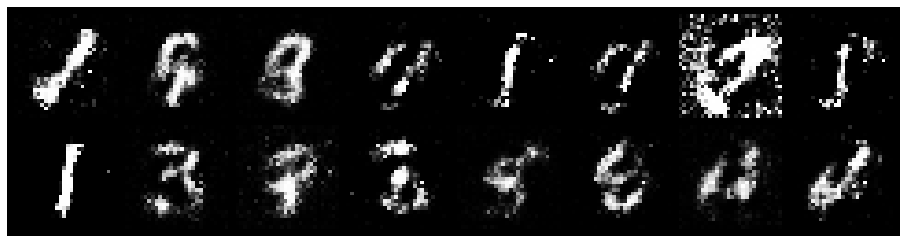

Epoch: [16/50], Batch Num: [200/600]
Discriminator Loss: 0.8145, Generator Loss: 2.3393
D(x): 0.8288, D(G(z)): 0.3046


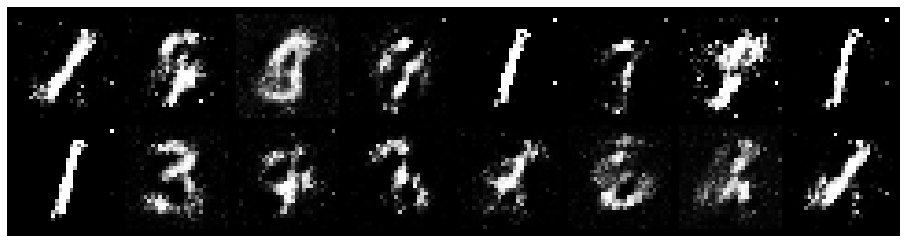

Epoch: [16/50], Batch Num: [300/600]
Discriminator Loss: 0.5479, Generator Loss: 2.5556
D(x): 0.7616, D(G(z)): 0.1266


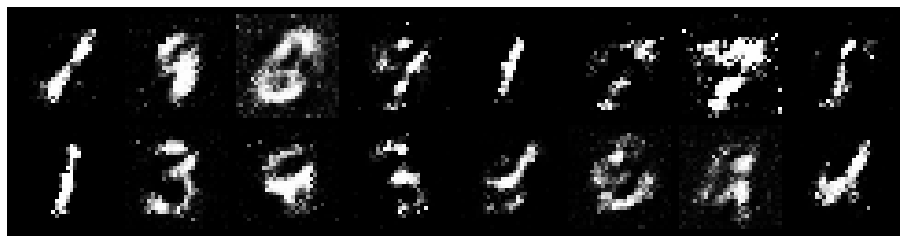

Epoch: [16/50], Batch Num: [400/600]
Discriminator Loss: 0.9406, Generator Loss: 2.2908
D(x): 0.6848, D(G(z)): 0.2309


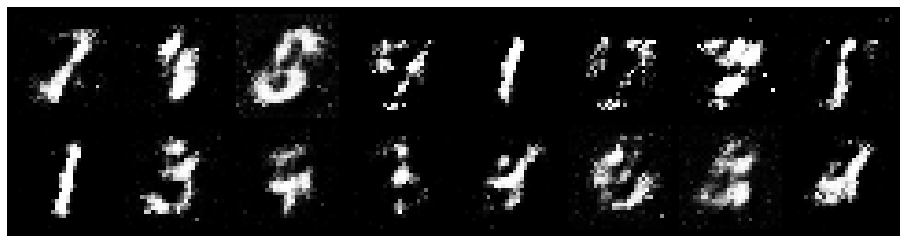

Epoch: [16/50], Batch Num: [500/600]
Discriminator Loss: 0.7469, Generator Loss: 2.4011
D(x): 0.7976, D(G(z)): 0.2681


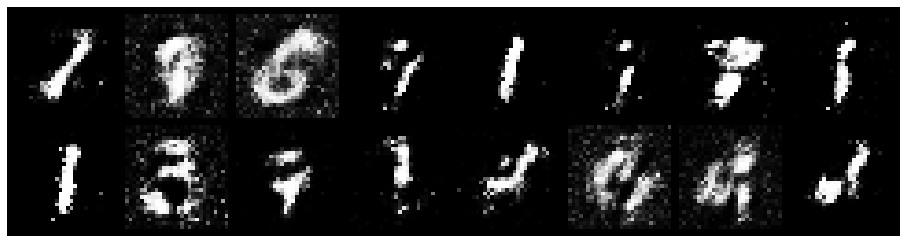

Epoch: [17/50], Batch Num: [0/600]
Discriminator Loss: 1.0275, Generator Loss: 1.2094
D(x): 0.6900, D(G(z)): 0.2906


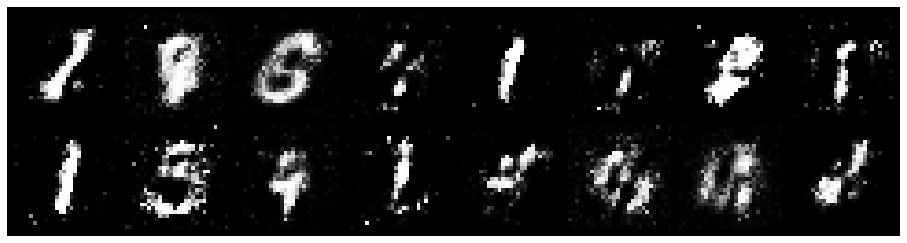

Epoch: [17/50], Batch Num: [100/600]
Discriminator Loss: 0.9068, Generator Loss: 2.0569
D(x): 0.7565, D(G(z)): 0.3178


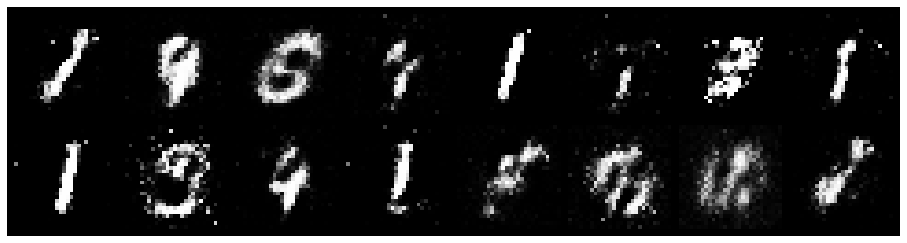

Epoch: [17/50], Batch Num: [200/600]
Discriminator Loss: 0.7741, Generator Loss: 1.7323
D(x): 0.7739, D(G(z)): 0.2590


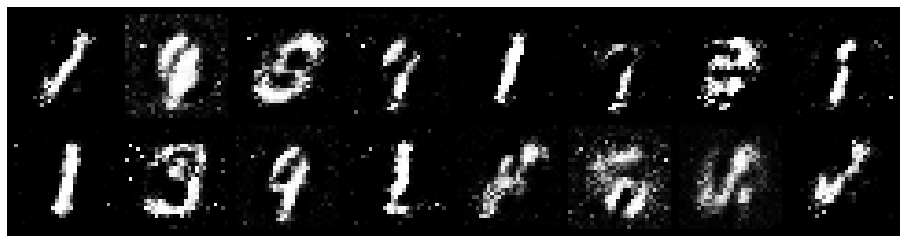

Epoch: [17/50], Batch Num: [300/600]
Discriminator Loss: 1.0360, Generator Loss: 1.8597
D(x): 0.6749, D(G(z)): 0.2586


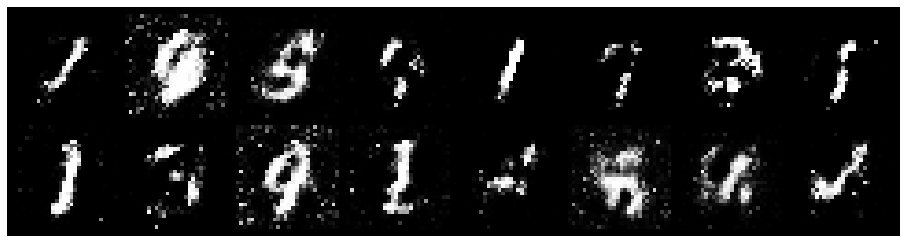

Epoch: [17/50], Batch Num: [400/600]
Discriminator Loss: 0.9861, Generator Loss: 1.4939
D(x): 0.7100, D(G(z)): 0.3437


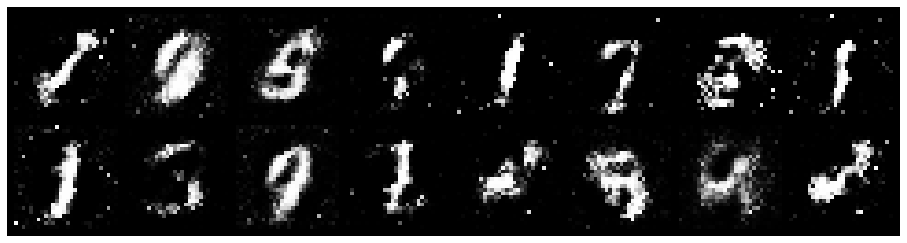

Epoch: [17/50], Batch Num: [500/600]
Discriminator Loss: 0.8807, Generator Loss: 2.1119
D(x): 0.6949, D(G(z)): 0.2250


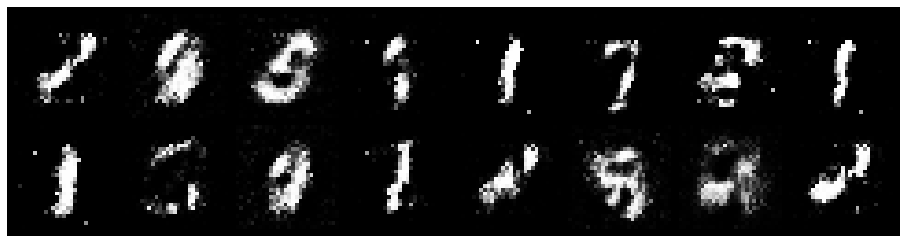

Epoch: [18/50], Batch Num: [0/600]
Discriminator Loss: 0.6214, Generator Loss: 2.1195
D(x): 0.7640, D(G(z)): 0.1767


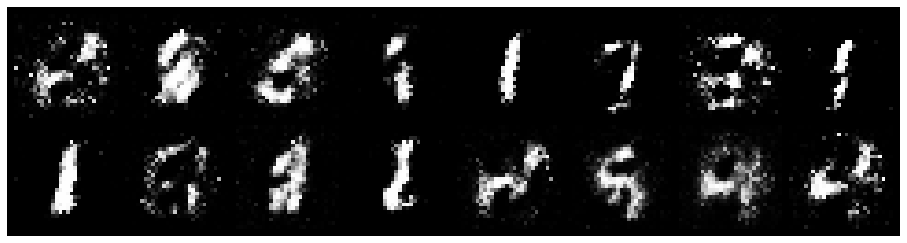

Epoch: [18/50], Batch Num: [100/600]
Discriminator Loss: 0.7460, Generator Loss: 1.8429
D(x): 0.7353, D(G(z)): 0.2163


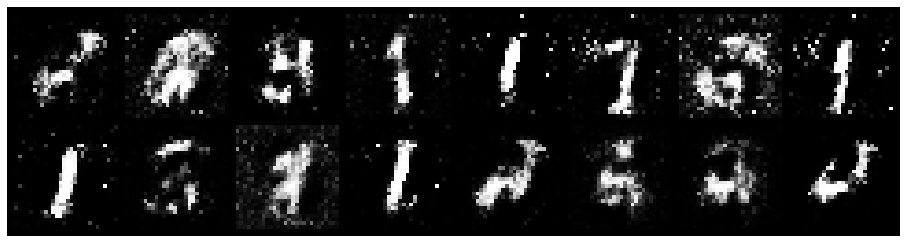

Epoch: [18/50], Batch Num: [200/600]
Discriminator Loss: 0.7009, Generator Loss: 2.4918
D(x): 0.8136, D(G(z)): 0.2445


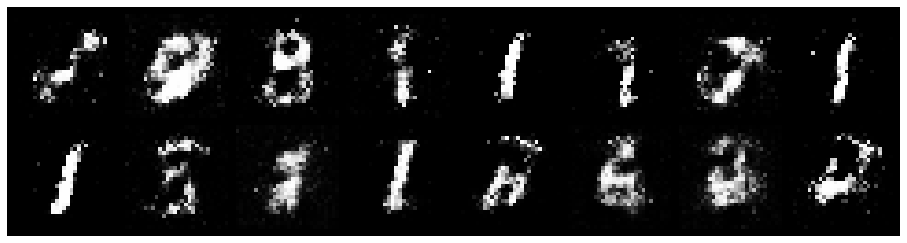

Epoch: [18/50], Batch Num: [300/600]
Discriminator Loss: 0.8529, Generator Loss: 2.2058
D(x): 0.7437, D(G(z)): 0.2425


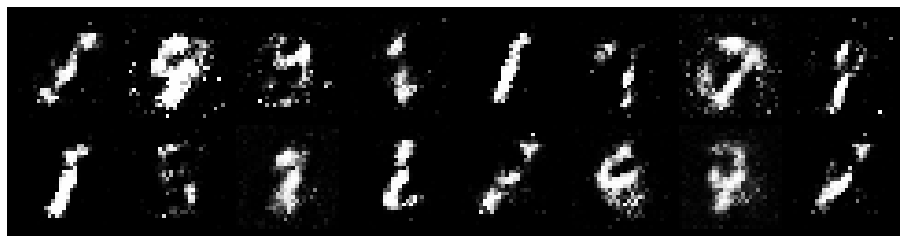

Epoch: [18/50], Batch Num: [400/600]
Discriminator Loss: 0.8518, Generator Loss: 1.8808
D(x): 0.6710, D(G(z)): 0.2155


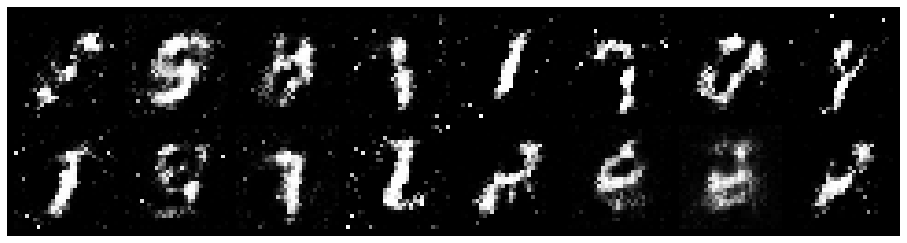

Epoch: [18/50], Batch Num: [500/600]
Discriminator Loss: 1.0088, Generator Loss: 1.8538
D(x): 0.7507, D(G(z)): 0.3795


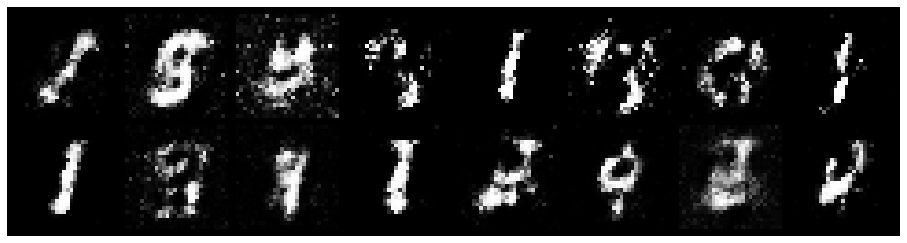

Epoch: [19/50], Batch Num: [0/600]
Discriminator Loss: 0.8591, Generator Loss: 1.6976
D(x): 0.7540, D(G(z)): 0.2880


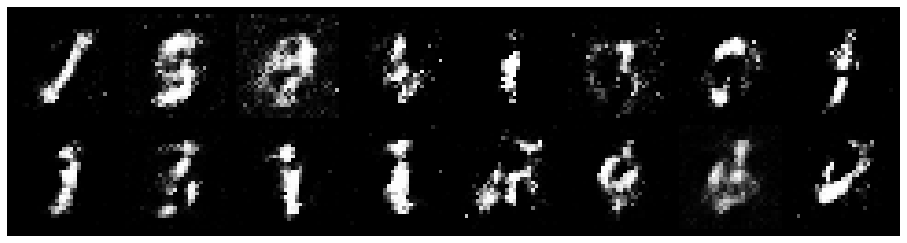

Epoch: [19/50], Batch Num: [100/600]
Discriminator Loss: 0.8045, Generator Loss: 2.3469
D(x): 0.6509, D(G(z)): 0.1803


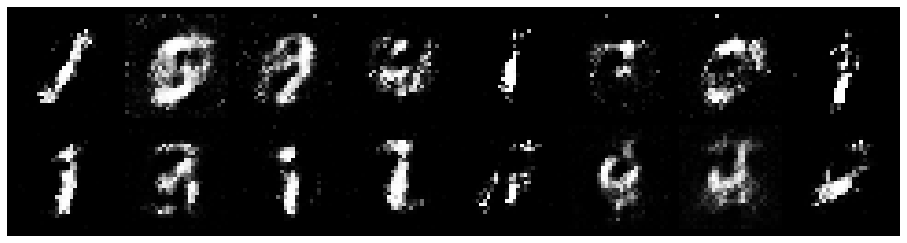

Epoch: [19/50], Batch Num: [200/600]
Discriminator Loss: 0.7667, Generator Loss: 1.9519
D(x): 0.7617, D(G(z)): 0.2374


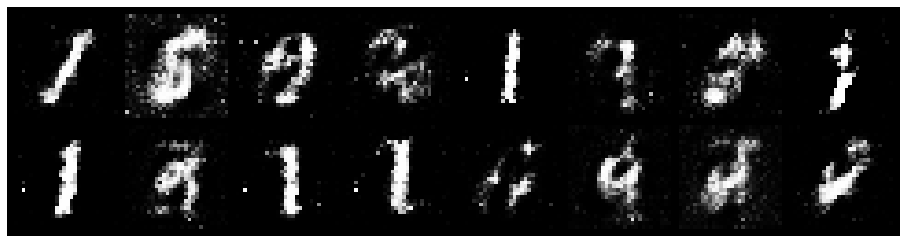

Epoch: [19/50], Batch Num: [300/600]
Discriminator Loss: 0.5462, Generator Loss: 2.4421
D(x): 0.7818, D(G(z)): 0.1477


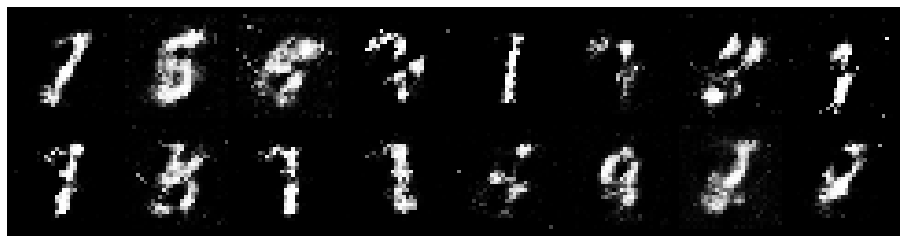

Epoch: [19/50], Batch Num: [400/600]
Discriminator Loss: 0.8342, Generator Loss: 1.9248
D(x): 0.7341, D(G(z)): 0.2549


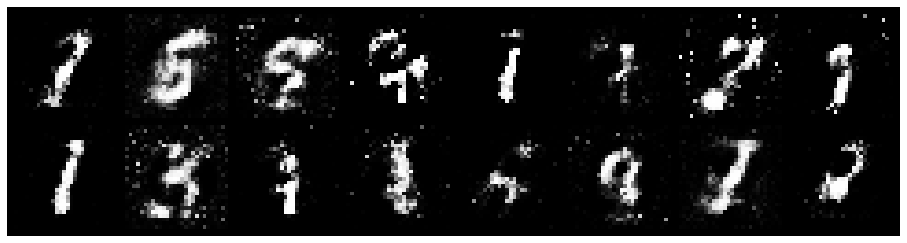

Epoch: [19/50], Batch Num: [500/600]
Discriminator Loss: 0.7050, Generator Loss: 2.0041
D(x): 0.7714, D(G(z)): 0.2789


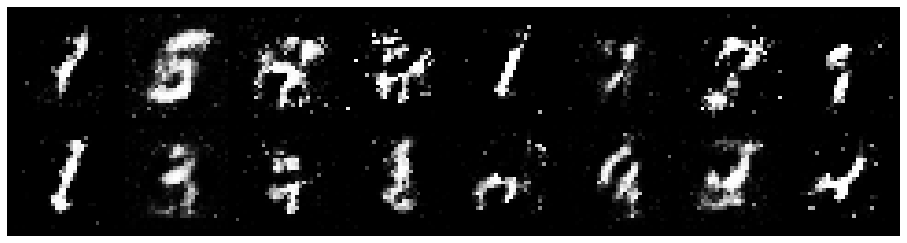

Epoch: [20/50], Batch Num: [0/600]
Discriminator Loss: 0.6155, Generator Loss: 2.6973
D(x): 0.7584, D(G(z)): 0.1434


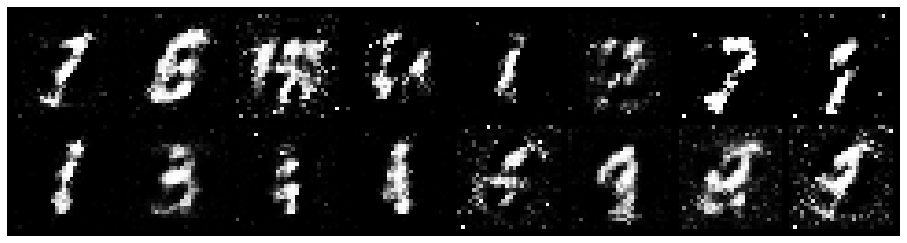

Epoch: [20/50], Batch Num: [100/600]
Discriminator Loss: 0.9555, Generator Loss: 2.2975
D(x): 0.7203, D(G(z)): 0.2856


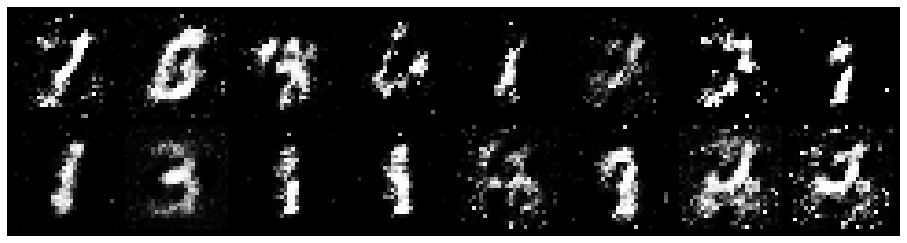

Epoch: [20/50], Batch Num: [200/600]
Discriminator Loss: 0.9148, Generator Loss: 2.0868
D(x): 0.7795, D(G(z)): 0.3028


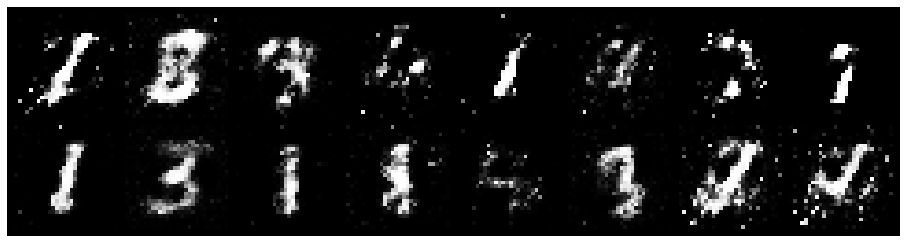

Epoch: [20/50], Batch Num: [300/600]
Discriminator Loss: 0.7731, Generator Loss: 1.8799
D(x): 0.6981, D(G(z)): 0.2078


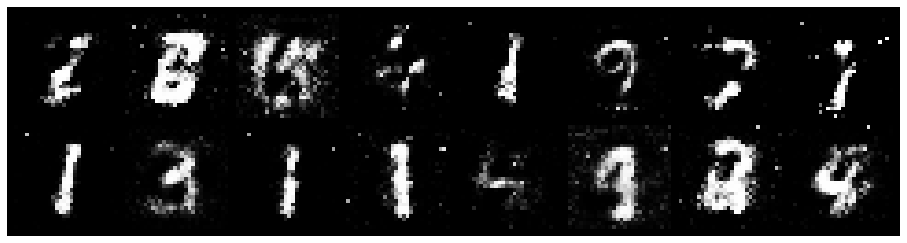

Epoch: [20/50], Batch Num: [400/600]
Discriminator Loss: 0.7449, Generator Loss: 1.5229
D(x): 0.7786, D(G(z)): 0.2483


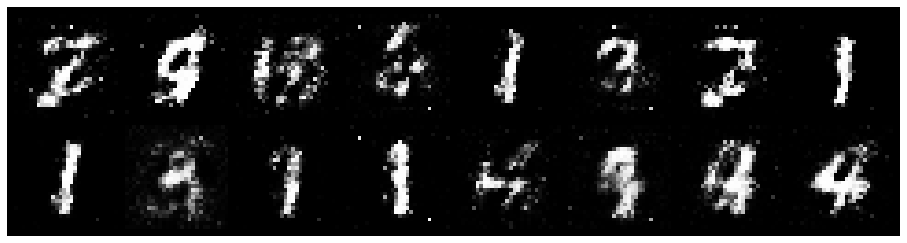

Epoch: [20/50], Batch Num: [500/600]
Discriminator Loss: 0.9686, Generator Loss: 1.6256
D(x): 0.6834, D(G(z)): 0.2850


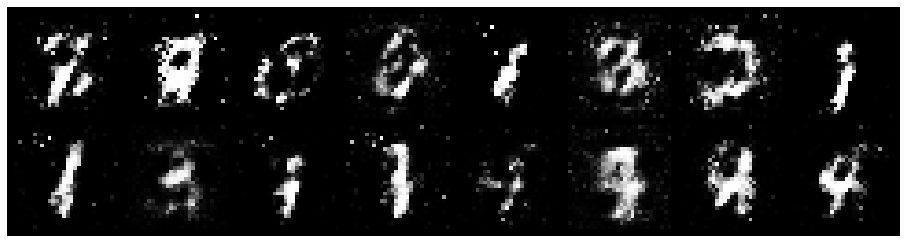

Epoch: [21/50], Batch Num: [0/600]
Discriminator Loss: 0.8755, Generator Loss: 1.9044
D(x): 0.6694, D(G(z)): 0.2122


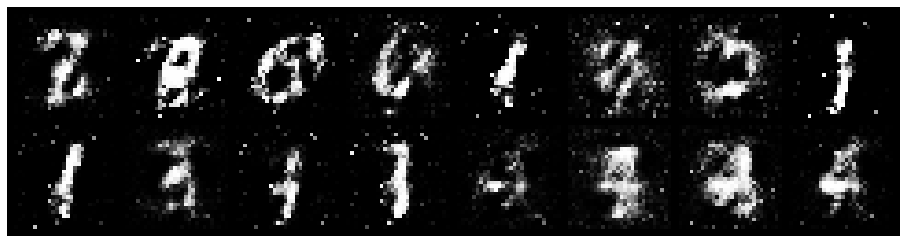

Epoch: [21/50], Batch Num: [100/600]
Discriminator Loss: 0.7420, Generator Loss: 1.7751
D(x): 0.7518, D(G(z)): 0.2322


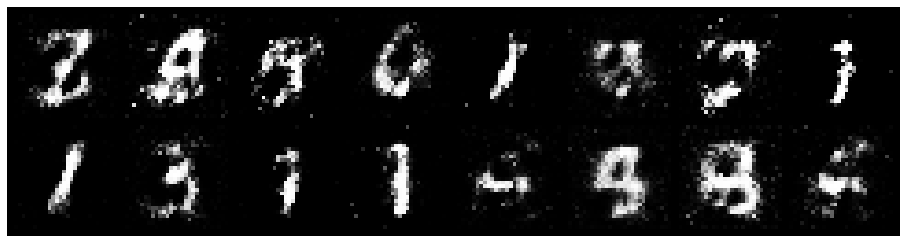

Epoch: [21/50], Batch Num: [200/600]
Discriminator Loss: 0.7974, Generator Loss: 2.1618
D(x): 0.7306, D(G(z)): 0.2299


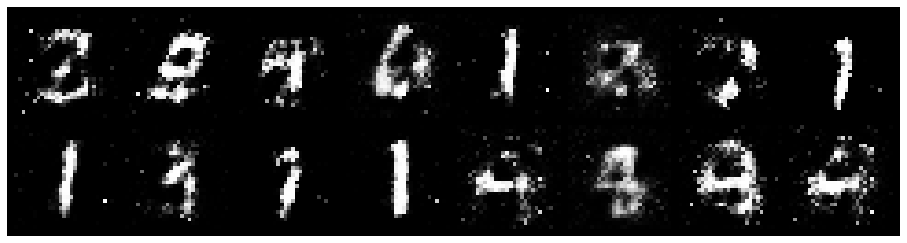

Epoch: [21/50], Batch Num: [300/600]
Discriminator Loss: 0.7937, Generator Loss: 2.3063
D(x): 0.7283, D(G(z)): 0.2501


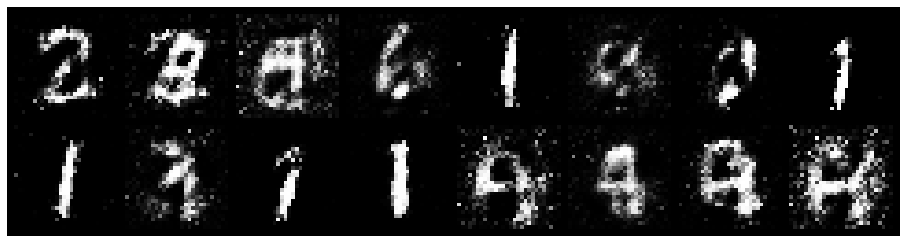

Epoch: [21/50], Batch Num: [400/600]
Discriminator Loss: 0.9961, Generator Loss: 1.6206
D(x): 0.7707, D(G(z)): 0.3794


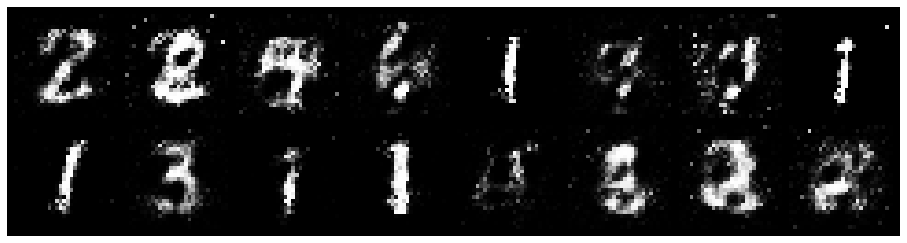

Epoch: [21/50], Batch Num: [500/600]
Discriminator Loss: 0.8394, Generator Loss: 1.3934
D(x): 0.7324, D(G(z)): 0.2878


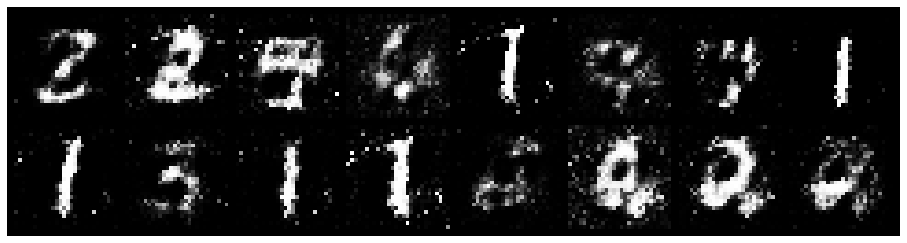

Epoch: [22/50], Batch Num: [0/600]
Discriminator Loss: 0.9565, Generator Loss: 1.3308
D(x): 0.7149, D(G(z)): 0.3712


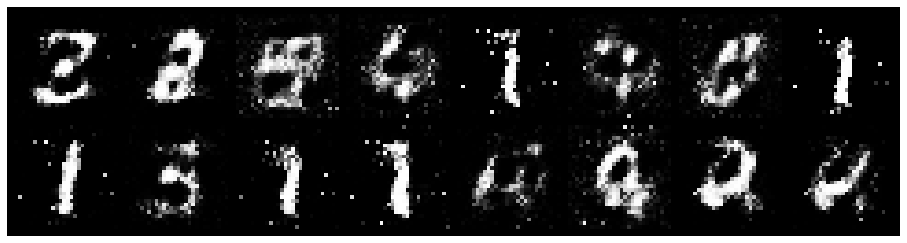

Epoch: [22/50], Batch Num: [100/600]
Discriminator Loss: 1.0145, Generator Loss: 1.4651
D(x): 0.7455, D(G(z)): 0.3787


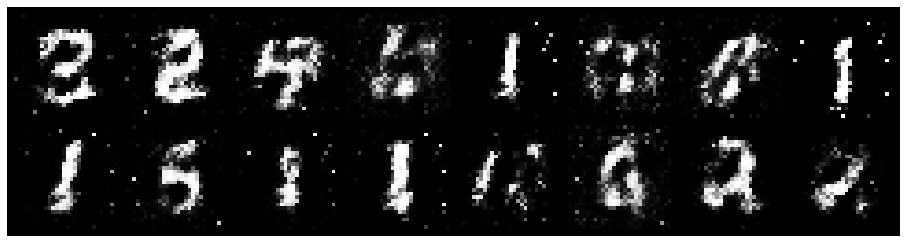

Epoch: [22/50], Batch Num: [200/600]
Discriminator Loss: 1.0026, Generator Loss: 1.8149
D(x): 0.6834, D(G(z)): 0.2987


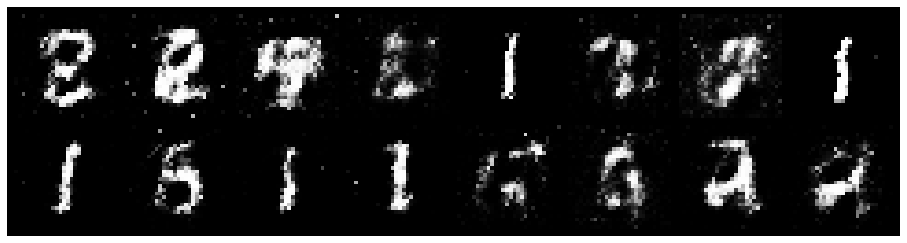

Epoch: [22/50], Batch Num: [300/600]
Discriminator Loss: 0.7672, Generator Loss: 1.3159
D(x): 0.7218, D(G(z)): 0.2646


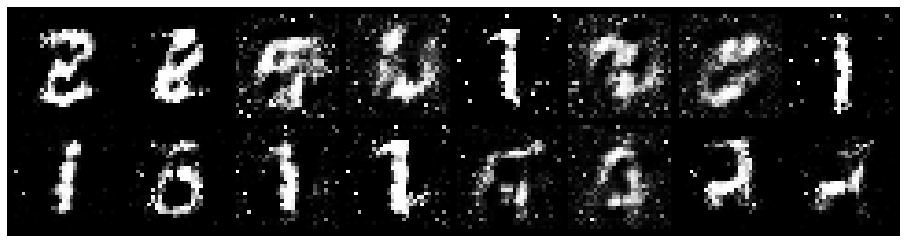

Epoch: [22/50], Batch Num: [400/600]
Discriminator Loss: 0.8762, Generator Loss: 1.8443
D(x): 0.7341, D(G(z)): 0.3190


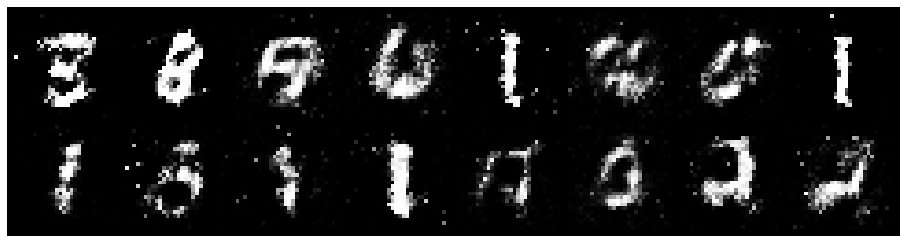

Epoch: [22/50], Batch Num: [500/600]
Discriminator Loss: 0.9418, Generator Loss: 1.1755
D(x): 0.7086, D(G(z)): 0.3604


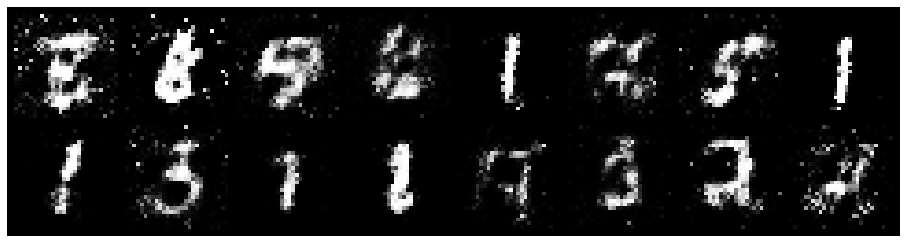

Epoch: [23/50], Batch Num: [0/600]
Discriminator Loss: 0.9816, Generator Loss: 1.4858
D(x): 0.6434, D(G(z)): 0.3202


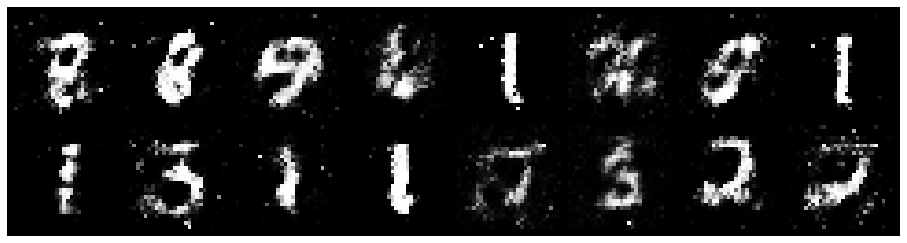

Epoch: [23/50], Batch Num: [100/600]
Discriminator Loss: 0.9485, Generator Loss: 1.5373
D(x): 0.7230, D(G(z)): 0.3445


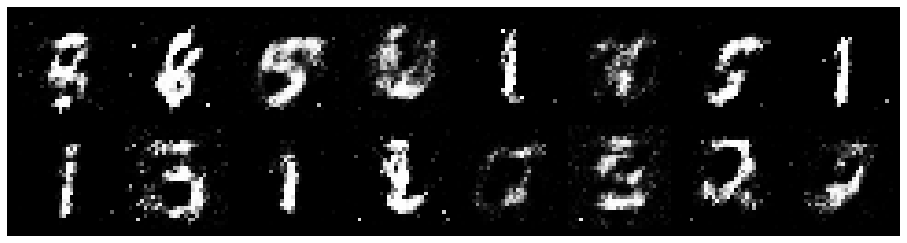

Epoch: [23/50], Batch Num: [200/600]
Discriminator Loss: 1.1928, Generator Loss: 1.3523
D(x): 0.5987, D(G(z)): 0.3316


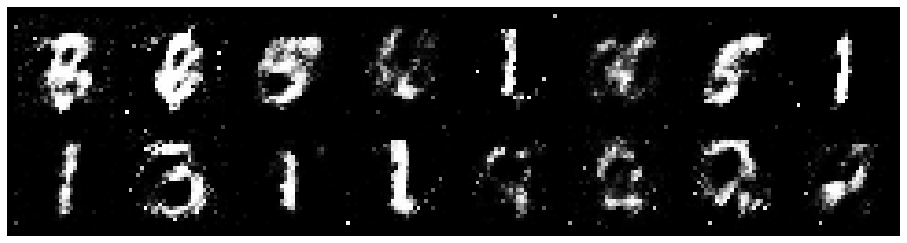

Epoch: [23/50], Batch Num: [300/600]
Discriminator Loss: 0.8713, Generator Loss: 1.3006
D(x): 0.7356, D(G(z)): 0.3283


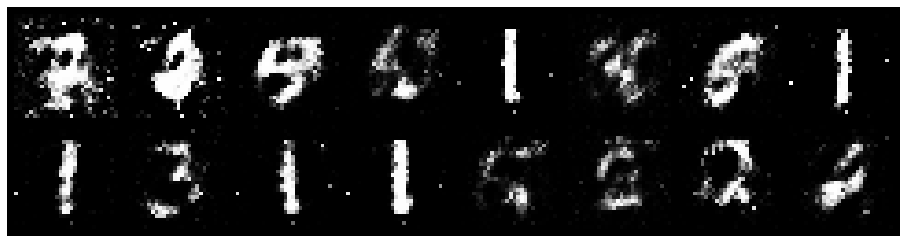

Epoch: [23/50], Batch Num: [400/600]
Discriminator Loss: 0.7354, Generator Loss: 2.1241
D(x): 0.7677, D(G(z)): 0.2504


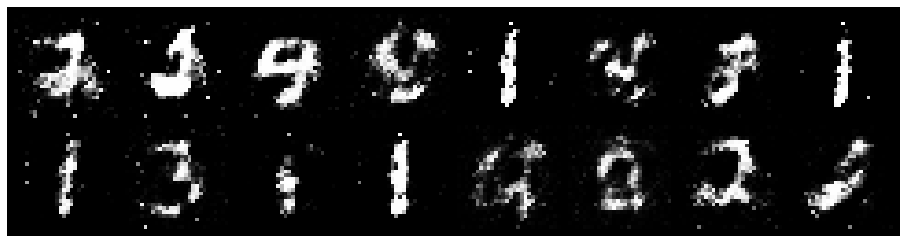

Epoch: [23/50], Batch Num: [500/600]
Discriminator Loss: 0.8136, Generator Loss: 1.9691
D(x): 0.7637, D(G(z)): 0.3047


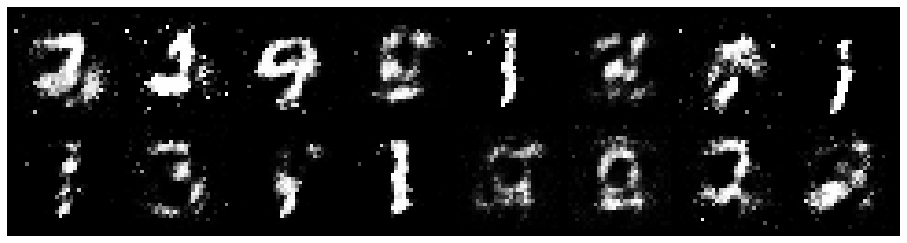

Epoch: [24/50], Batch Num: [0/600]
Discriminator Loss: 0.9144, Generator Loss: 1.8684
D(x): 0.7120, D(G(z)): 0.3176


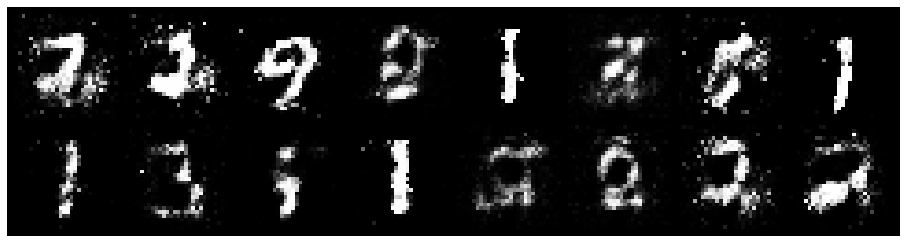

Epoch: [24/50], Batch Num: [100/600]
Discriminator Loss: 0.9364, Generator Loss: 1.9293
D(x): 0.6413, D(G(z)): 0.2610


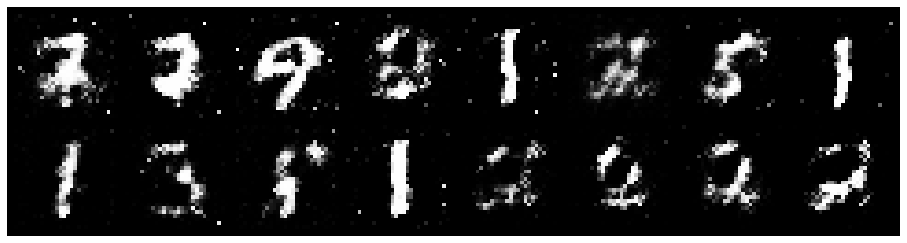

Epoch: [24/50], Batch Num: [200/600]
Discriminator Loss: 0.9439, Generator Loss: 1.6450
D(x): 0.6575, D(G(z)): 0.2840


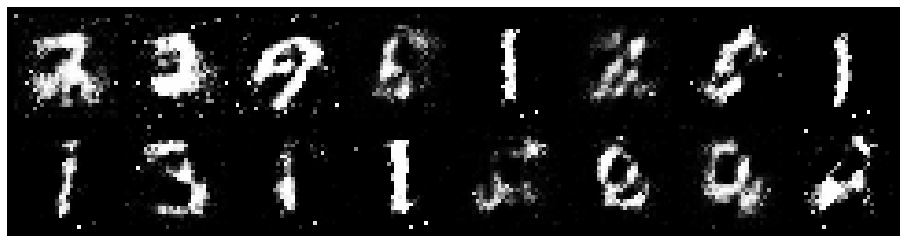

Epoch: [24/50], Batch Num: [300/600]
Discriminator Loss: 0.9664, Generator Loss: 1.2733
D(x): 0.6211, D(G(z)): 0.2767


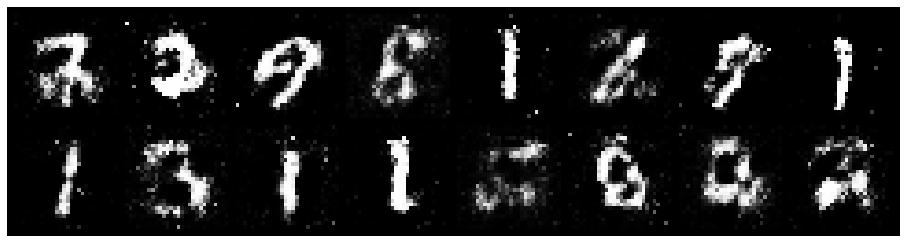

Epoch: [24/50], Batch Num: [400/600]
Discriminator Loss: 1.0026, Generator Loss: 1.4472
D(x): 0.6288, D(G(z)): 0.2907


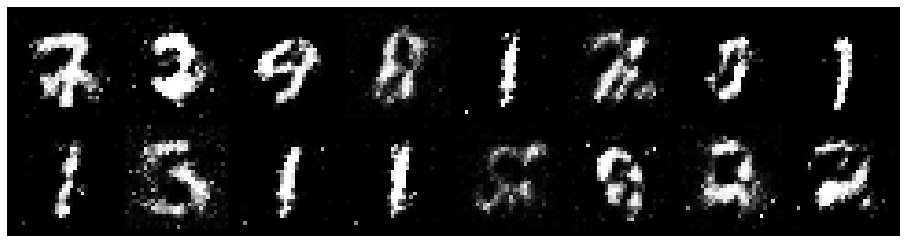

Epoch: [24/50], Batch Num: [500/600]
Discriminator Loss: 0.8084, Generator Loss: 1.3229
D(x): 0.7466, D(G(z)): 0.2956


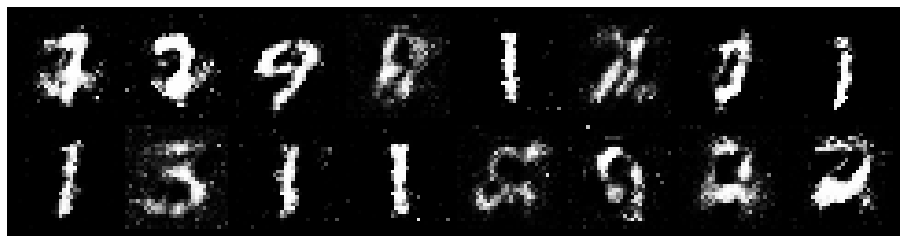

Epoch: [25/50], Batch Num: [0/600]
Discriminator Loss: 0.8411, Generator Loss: 1.5322
D(x): 0.8292, D(G(z)): 0.3994


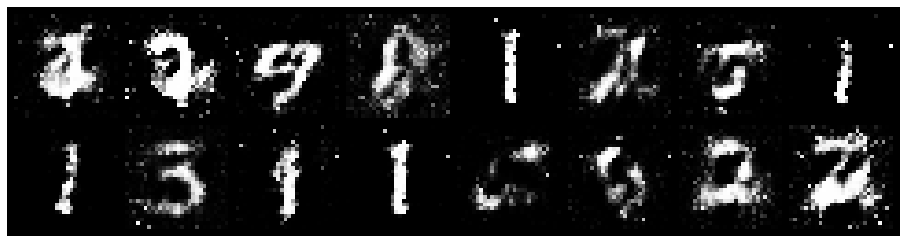

Epoch: [25/50], Batch Num: [100/600]
Discriminator Loss: 0.7255, Generator Loss: 1.6615
D(x): 0.7216, D(G(z)): 0.2219


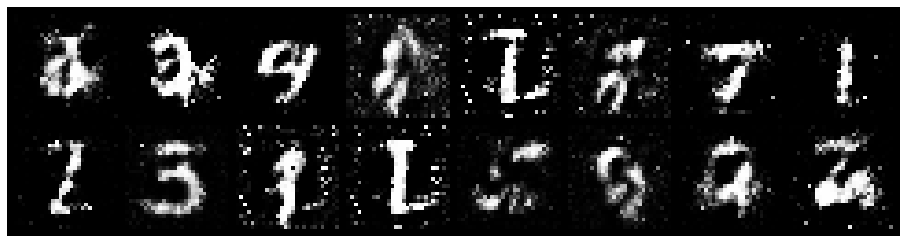

Epoch: [25/50], Batch Num: [200/600]
Discriminator Loss: 0.9780, Generator Loss: 1.2656
D(x): 0.6847, D(G(z)): 0.3556


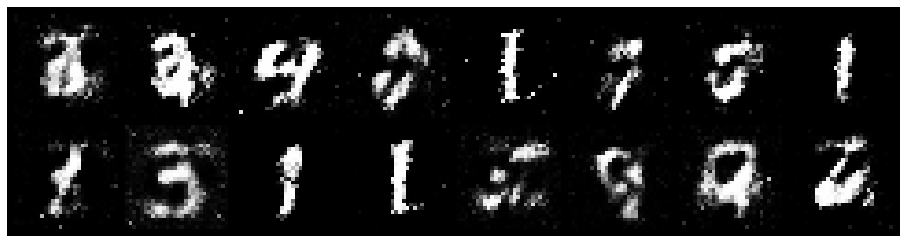

Epoch: [25/50], Batch Num: [300/600]
Discriminator Loss: 0.7999, Generator Loss: 1.8978
D(x): 0.7805, D(G(z)): 0.3048


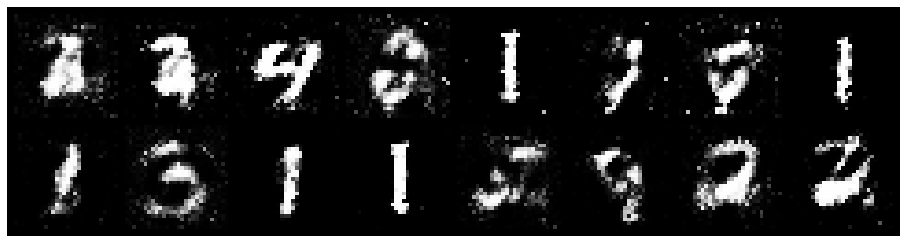

Epoch: [25/50], Batch Num: [400/600]
Discriminator Loss: 1.0140, Generator Loss: 1.5668
D(x): 0.7743, D(G(z)): 0.3612


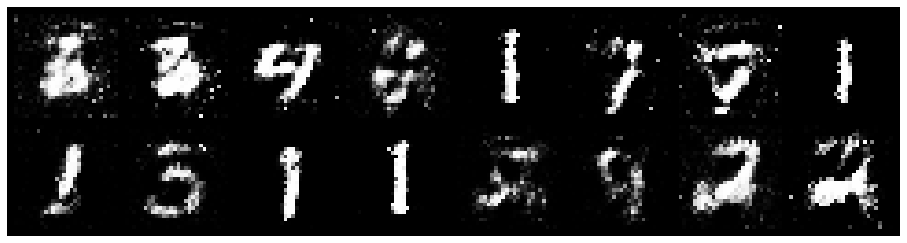

Epoch: [25/50], Batch Num: [500/600]
Discriminator Loss: 0.8142, Generator Loss: 1.6260
D(x): 0.6849, D(G(z)): 0.2206


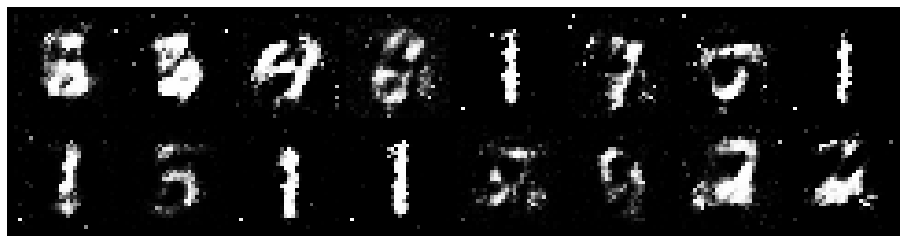

Epoch: [26/50], Batch Num: [0/600]
Discriminator Loss: 0.9110, Generator Loss: 1.7681
D(x): 0.6945, D(G(z)): 0.3232


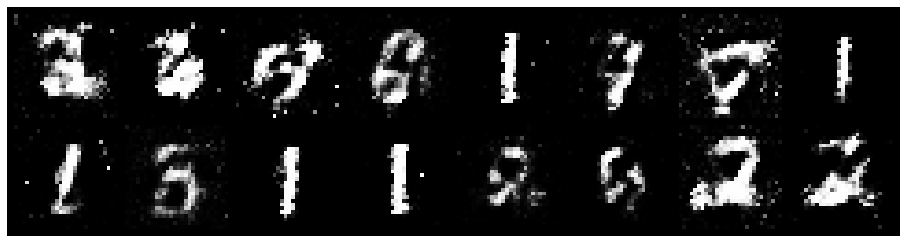

Epoch: [26/50], Batch Num: [100/600]
Discriminator Loss: 0.8750, Generator Loss: 1.6965
D(x): 0.7148, D(G(z)): 0.3026


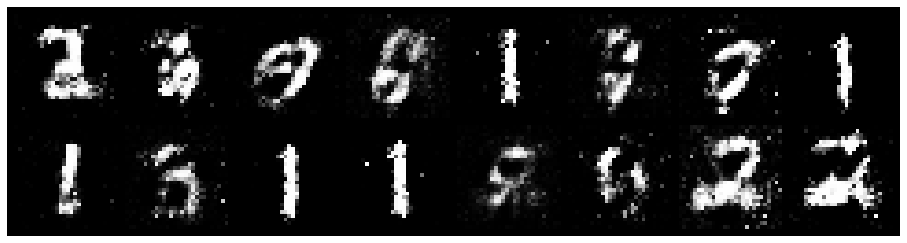

Epoch: [26/50], Batch Num: [200/600]
Discriminator Loss: 0.8468, Generator Loss: 1.5468
D(x): 0.7352, D(G(z)): 0.3253


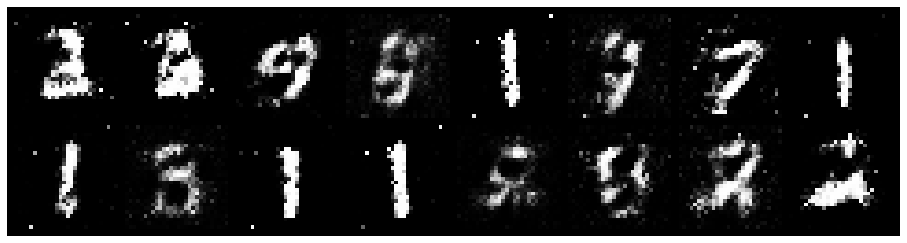

Epoch: [26/50], Batch Num: [300/600]
Discriminator Loss: 1.0331, Generator Loss: 1.1968
D(x): 0.7483, D(G(z)): 0.4411


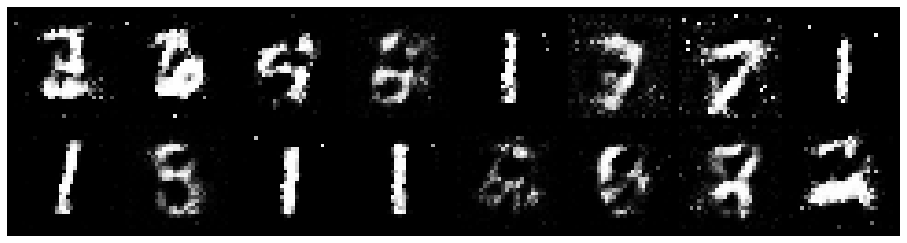

Epoch: [26/50], Batch Num: [400/600]
Discriminator Loss: 1.0567, Generator Loss: 1.1368
D(x): 0.6276, D(G(z)): 0.3443


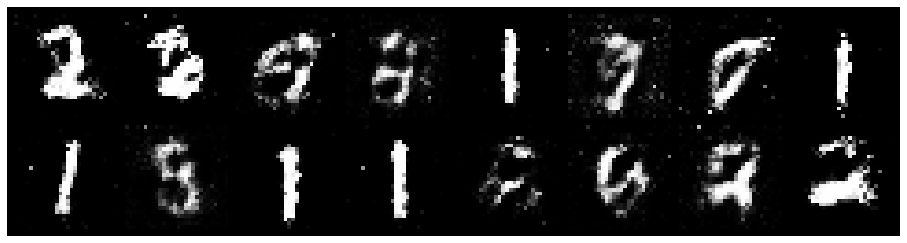

Epoch: [26/50], Batch Num: [500/600]
Discriminator Loss: 0.8715, Generator Loss: 1.7170
D(x): 0.7363, D(G(z)): 0.3294


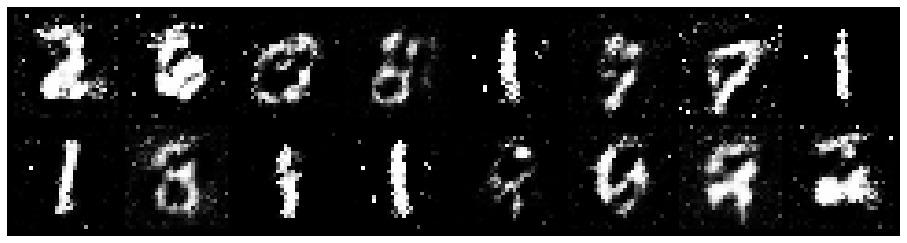

Epoch: [27/50], Batch Num: [0/600]
Discriminator Loss: 0.8565, Generator Loss: 1.8325
D(x): 0.6782, D(G(z)): 0.2694


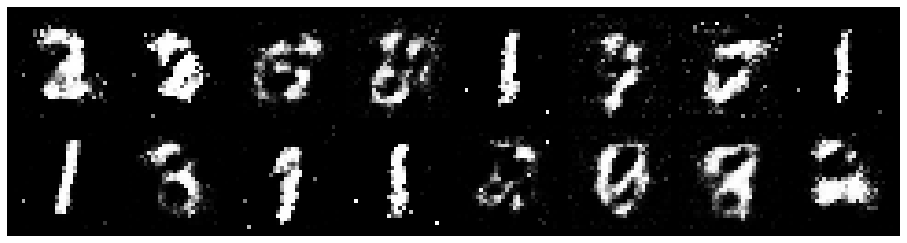

Epoch: [27/50], Batch Num: [100/600]
Discriminator Loss: 0.8490, Generator Loss: 1.5177
D(x): 0.7284, D(G(z)): 0.3135


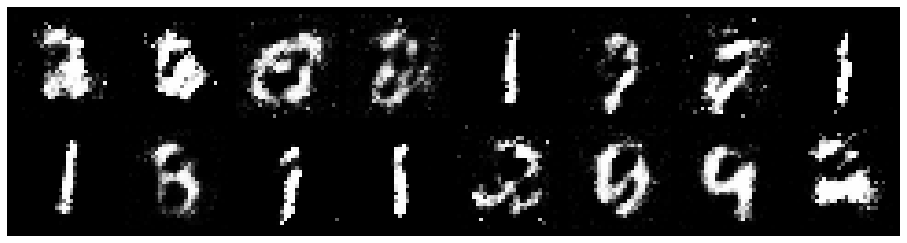

Epoch: [27/50], Batch Num: [200/600]
Discriminator Loss: 1.0939, Generator Loss: 1.6251
D(x): 0.5958, D(G(z)): 0.2706


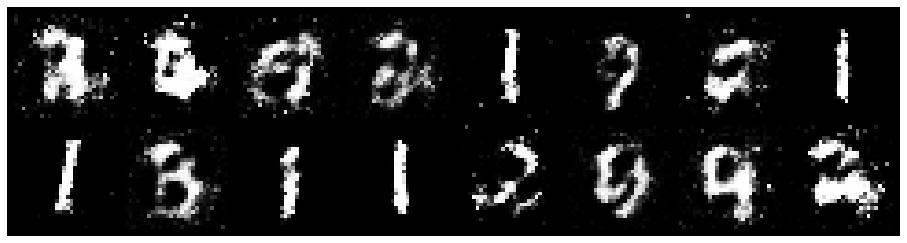

Epoch: [27/50], Batch Num: [300/600]
Discriminator Loss: 0.9555, Generator Loss: 1.4101
D(x): 0.7353, D(G(z)): 0.3769


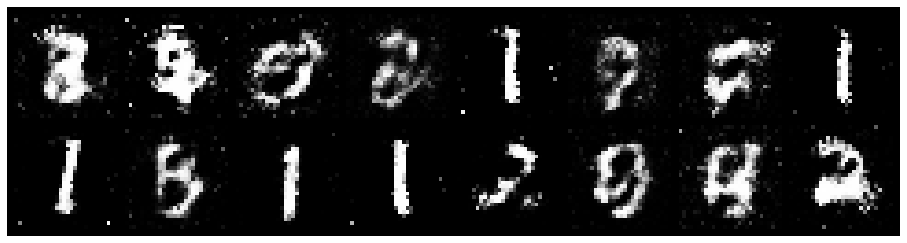

Epoch: [27/50], Batch Num: [400/600]
Discriminator Loss: 1.0436, Generator Loss: 1.1751
D(x): 0.6986, D(G(z)): 0.3904


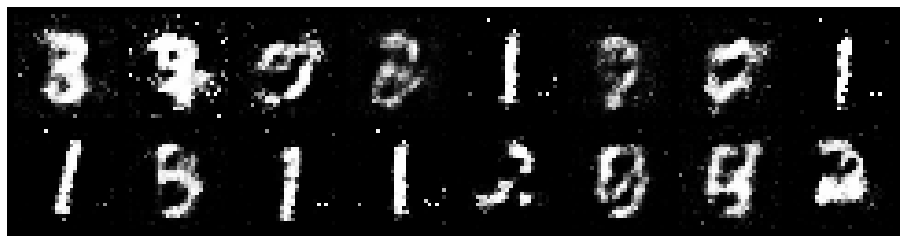

Epoch: [27/50], Batch Num: [500/600]
Discriminator Loss: 1.0661, Generator Loss: 1.2552
D(x): 0.6510, D(G(z)): 0.3275


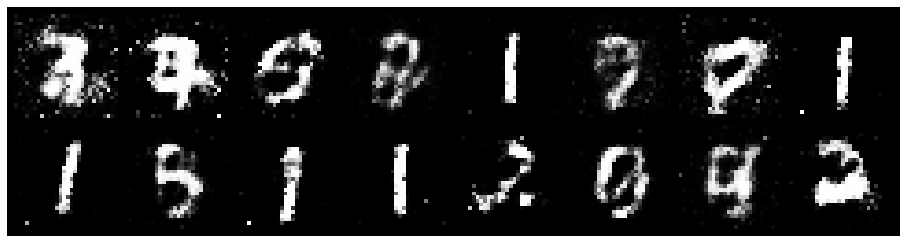

Epoch: [28/50], Batch Num: [0/600]
Discriminator Loss: 1.0505, Generator Loss: 1.6523
D(x): 0.6369, D(G(z)): 0.2836


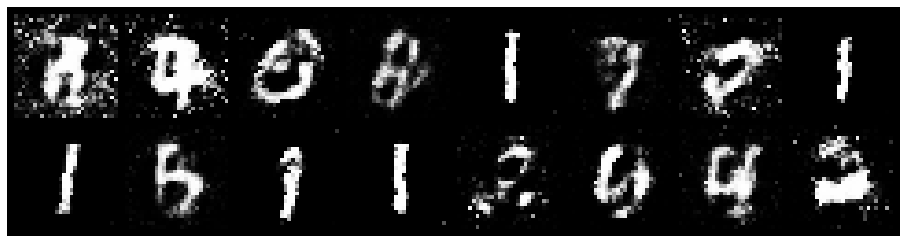

Epoch: [28/50], Batch Num: [100/600]
Discriminator Loss: 1.0177, Generator Loss: 1.1611
D(x): 0.6617, D(G(z)): 0.3576


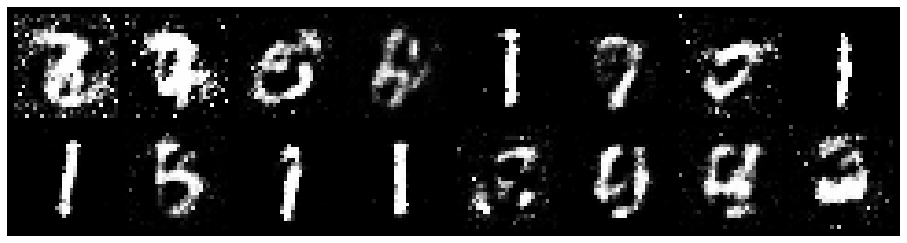

Epoch: [28/50], Batch Num: [200/600]
Discriminator Loss: 0.9373, Generator Loss: 1.7975
D(x): 0.6944, D(G(z)): 0.3133


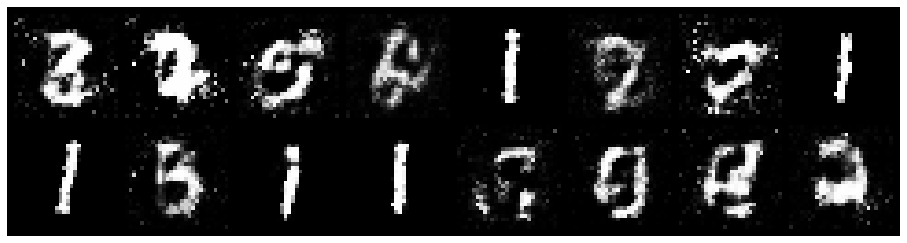

Epoch: [28/50], Batch Num: [300/600]
Discriminator Loss: 1.1061, Generator Loss: 1.2909
D(x): 0.6630, D(G(z)): 0.3855


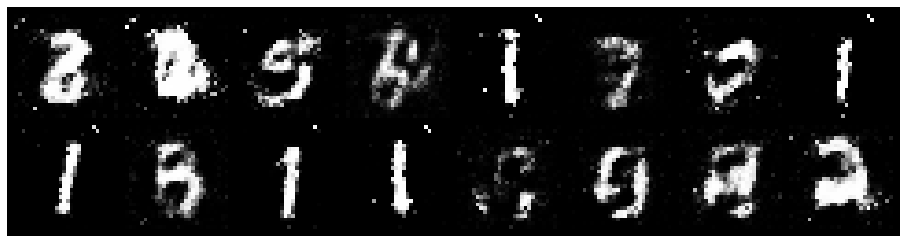

Epoch: [28/50], Batch Num: [400/600]
Discriminator Loss: 0.9165, Generator Loss: 1.4013
D(x): 0.7032, D(G(z)): 0.3281


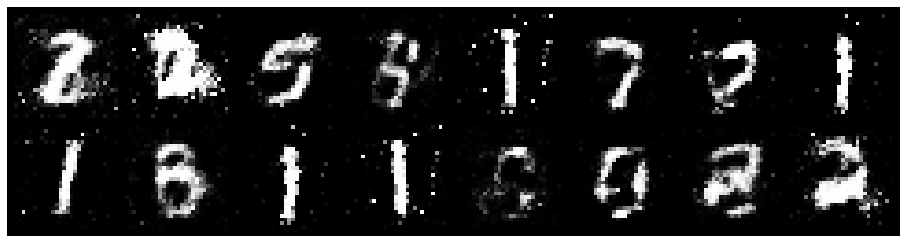

Epoch: [28/50], Batch Num: [500/600]
Discriminator Loss: 0.9662, Generator Loss: 1.1753
D(x): 0.6602, D(G(z)): 0.3528


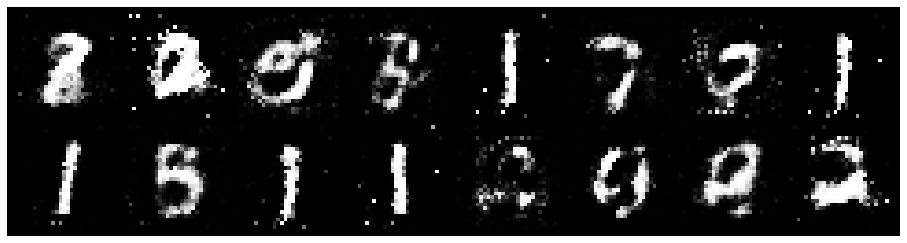

Epoch: [29/50], Batch Num: [0/600]
Discriminator Loss: 1.2412, Generator Loss: 1.4122
D(x): 0.5495, D(G(z)): 0.3614


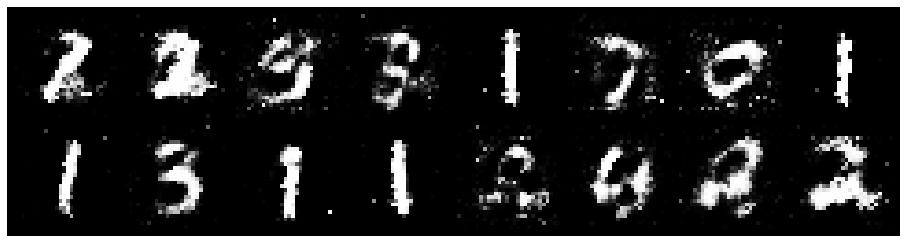

Epoch: [29/50], Batch Num: [100/600]
Discriminator Loss: 0.9468, Generator Loss: 1.4224
D(x): 0.6704, D(G(z)): 0.3263


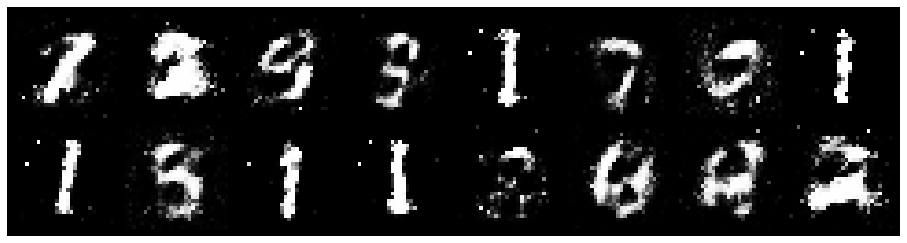

Epoch: [29/50], Batch Num: [200/600]
Discriminator Loss: 0.8476, Generator Loss: 1.5966
D(x): 0.7035, D(G(z)): 0.2706


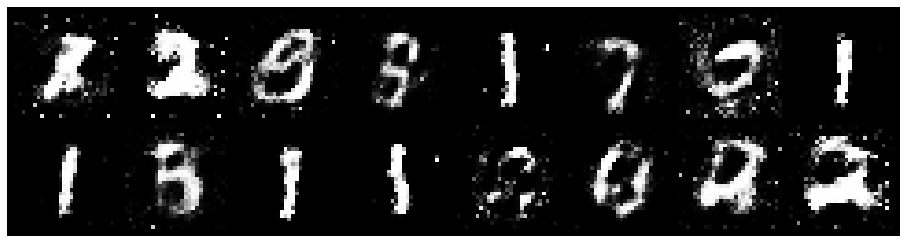

Epoch: [29/50], Batch Num: [300/600]
Discriminator Loss: 0.8893, Generator Loss: 1.5594
D(x): 0.6579, D(G(z)): 0.2707


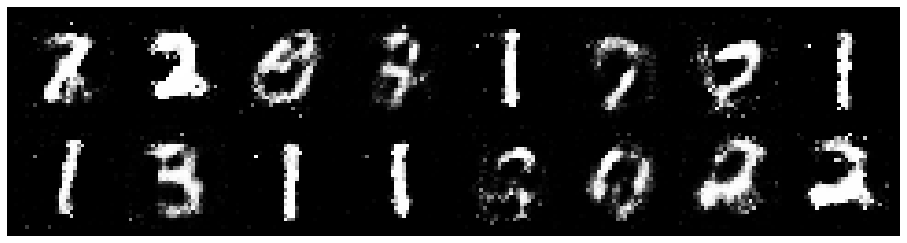

Epoch: [29/50], Batch Num: [400/600]
Discriminator Loss: 0.8598, Generator Loss: 1.6339
D(x): 0.6873, D(G(z)): 0.2971


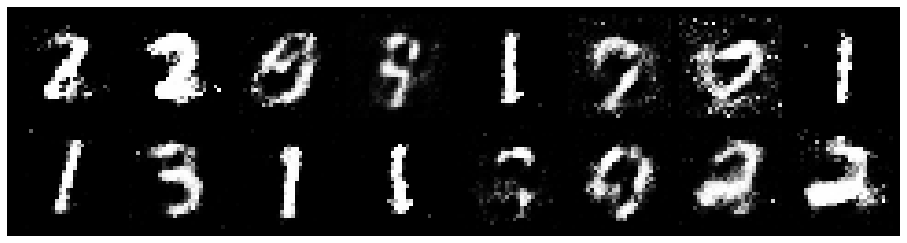

Epoch: [29/50], Batch Num: [500/600]
Discriminator Loss: 0.9457, Generator Loss: 1.4757
D(x): 0.7091, D(G(z)): 0.3323


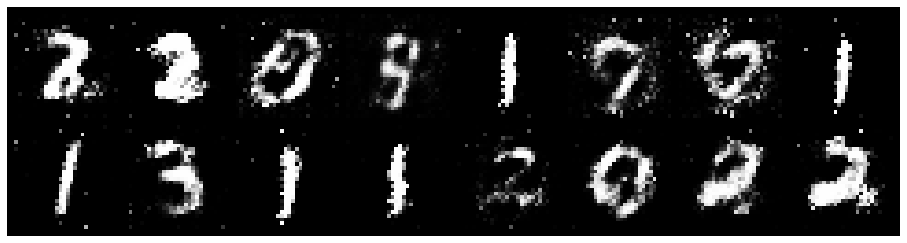

Epoch: [30/50], Batch Num: [0/600]
Discriminator Loss: 0.9580, Generator Loss: 1.3208
D(x): 0.6681, D(G(z)): 0.3542


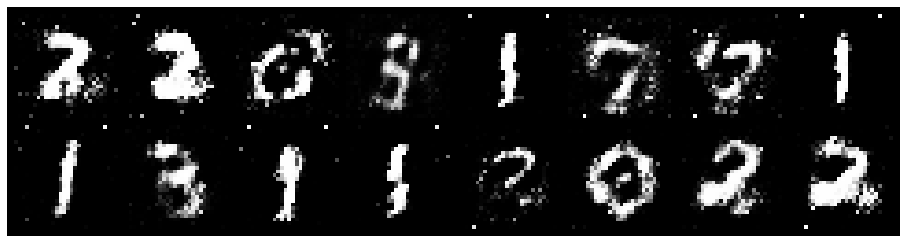

Epoch: [30/50], Batch Num: [100/600]
Discriminator Loss: 1.0301, Generator Loss: 1.0778
D(x): 0.6115, D(G(z)): 0.3373


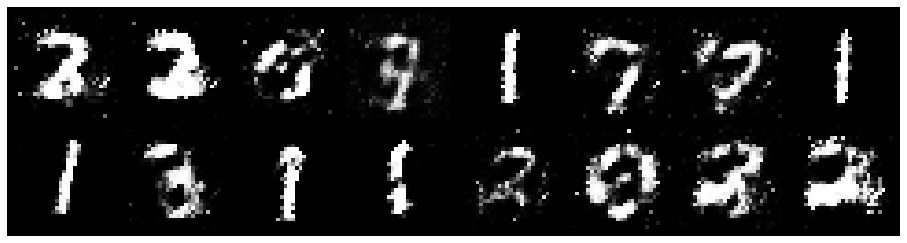

Epoch: [30/50], Batch Num: [200/600]
Discriminator Loss: 0.8823, Generator Loss: 1.4908
D(x): 0.7206, D(G(z)): 0.3240


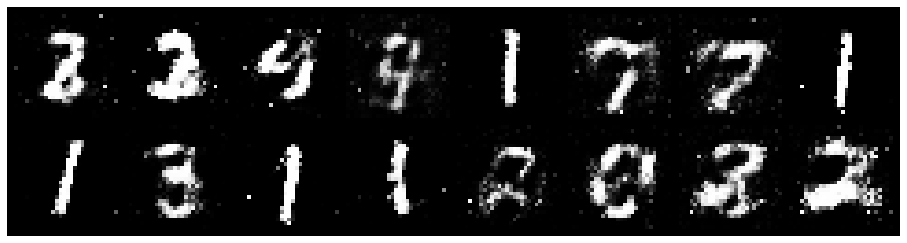

Epoch: [30/50], Batch Num: [300/600]
Discriminator Loss: 0.8214, Generator Loss: 1.4573
D(x): 0.6911, D(G(z)): 0.2808


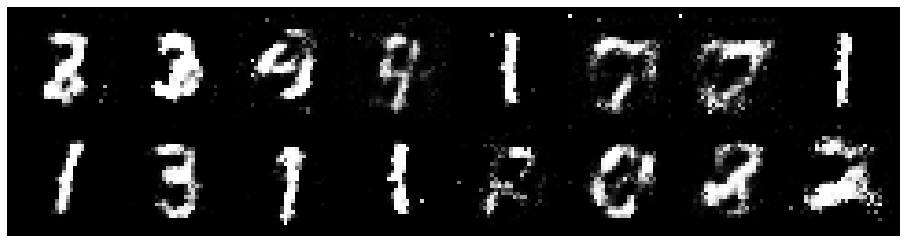

Epoch: [30/50], Batch Num: [400/600]
Discriminator Loss: 0.7587, Generator Loss: 1.5186
D(x): 0.7198, D(G(z)): 0.2700


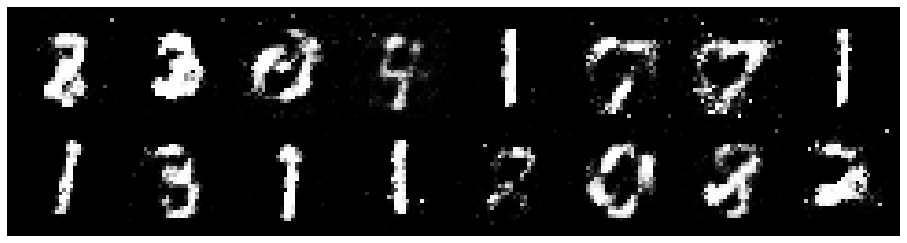

Epoch: [30/50], Batch Num: [500/600]
Discriminator Loss: 1.0431, Generator Loss: 1.1315
D(x): 0.6642, D(G(z)): 0.3813


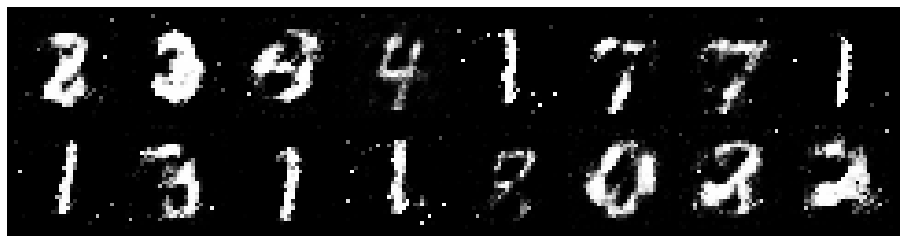

Epoch: [31/50], Batch Num: [0/600]
Discriminator Loss: 1.0370, Generator Loss: 1.2087
D(x): 0.7339, D(G(z)): 0.4244


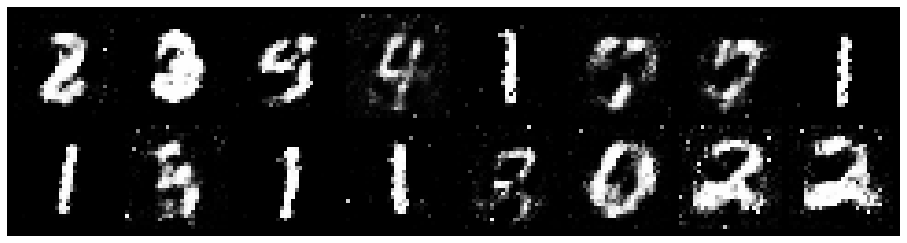

Epoch: [31/50], Batch Num: [100/600]
Discriminator Loss: 0.9957, Generator Loss: 1.3237
D(x): 0.7320, D(G(z)): 0.3931


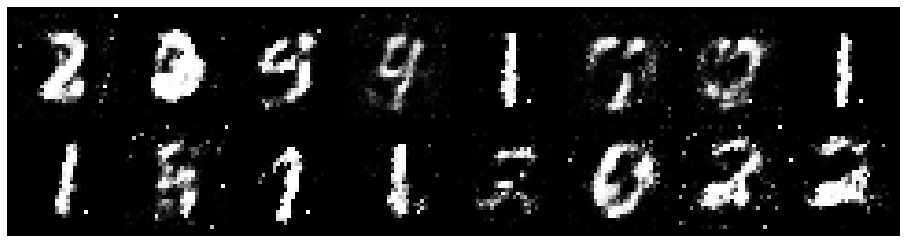

Epoch: [31/50], Batch Num: [200/600]
Discriminator Loss: 1.0848, Generator Loss: 1.1382
D(x): 0.5925, D(G(z)): 0.3660


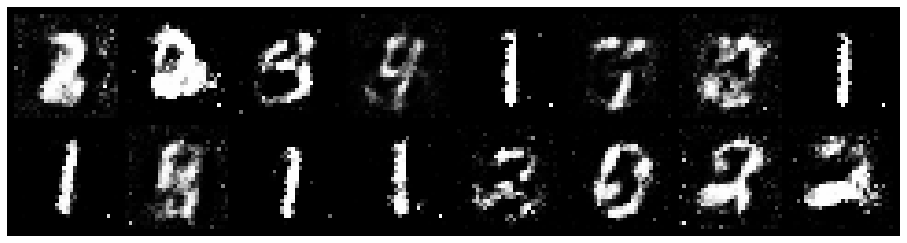

Epoch: [31/50], Batch Num: [300/600]
Discriminator Loss: 1.0161, Generator Loss: 1.4017
D(x): 0.7025, D(G(z)): 0.3828


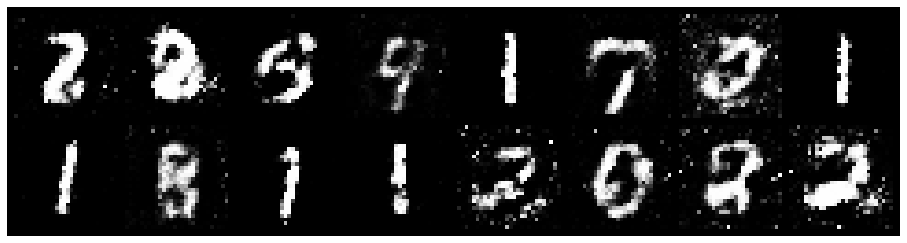

Epoch: [31/50], Batch Num: [400/600]
Discriminator Loss: 0.9151, Generator Loss: 1.5540
D(x): 0.6689, D(G(z)): 0.2854


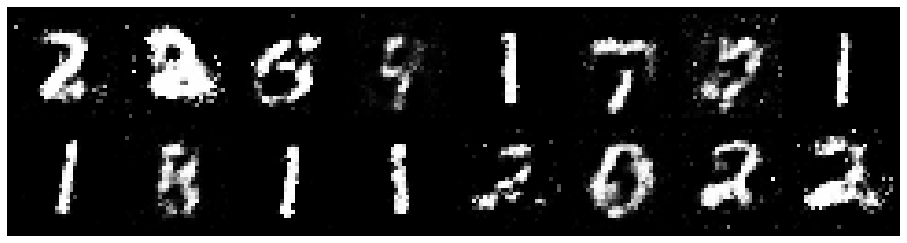

Epoch: [31/50], Batch Num: [500/600]
Discriminator Loss: 0.9255, Generator Loss: 1.7059
D(x): 0.6688, D(G(z)): 0.3026


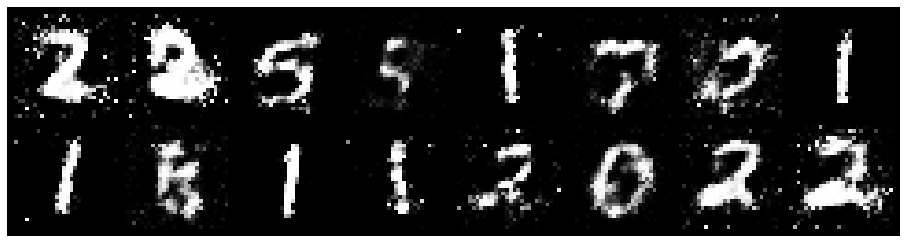

Epoch: [32/50], Batch Num: [0/600]
Discriminator Loss: 0.9835, Generator Loss: 1.6203
D(x): 0.6910, D(G(z)): 0.3605


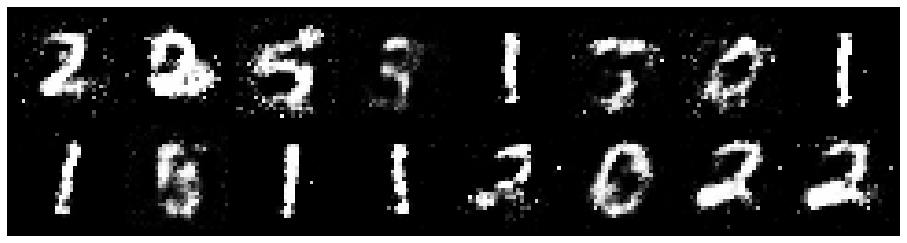

Epoch: [32/50], Batch Num: [100/600]
Discriminator Loss: 1.0551, Generator Loss: 1.0632
D(x): 0.6570, D(G(z)): 0.4020


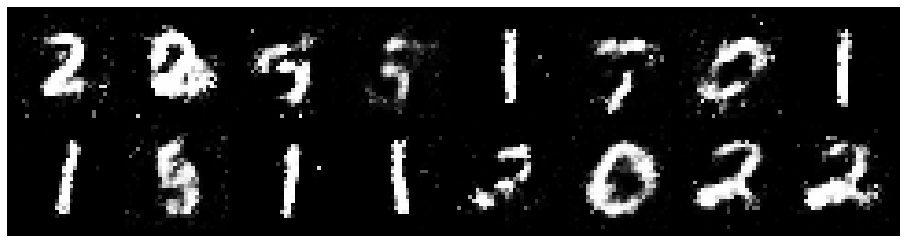

Epoch: [32/50], Batch Num: [200/600]
Discriminator Loss: 0.9649, Generator Loss: 1.2522
D(x): 0.6899, D(G(z)): 0.3529


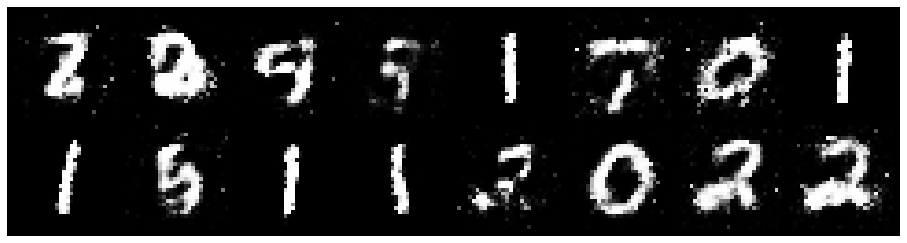

Epoch: [32/50], Batch Num: [300/600]
Discriminator Loss: 1.1100, Generator Loss: 1.2692
D(x): 0.6914, D(G(z)): 0.4027


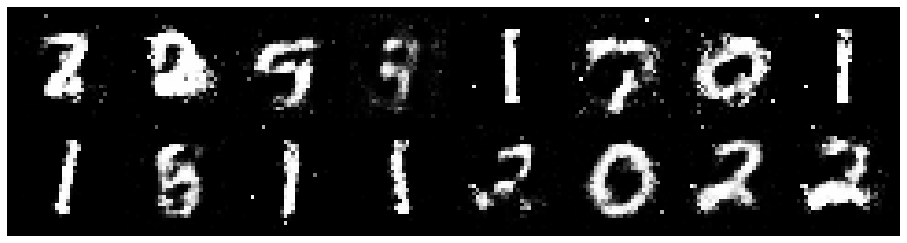

Epoch: [32/50], Batch Num: [400/600]
Discriminator Loss: 1.0770, Generator Loss: 1.2498
D(x): 0.6374, D(G(z)): 0.3394


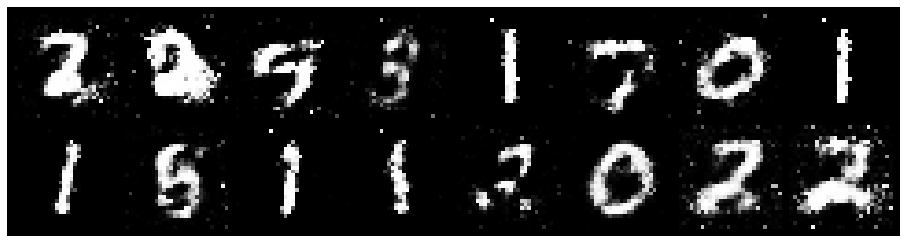

Epoch: [32/50], Batch Num: [500/600]
Discriminator Loss: 1.0704, Generator Loss: 1.3475
D(x): 0.6776, D(G(z)): 0.3776


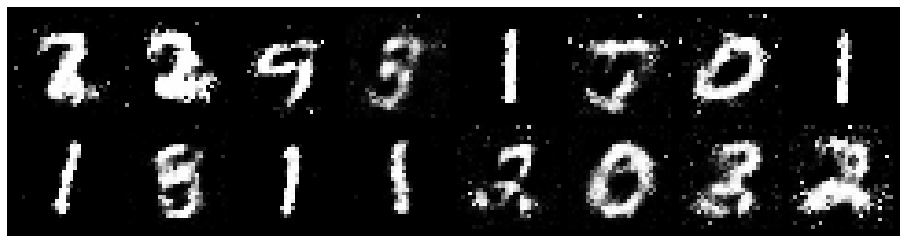

Epoch: [33/50], Batch Num: [0/600]
Discriminator Loss: 1.0840, Generator Loss: 1.2918
D(x): 0.6335, D(G(z)): 0.3830


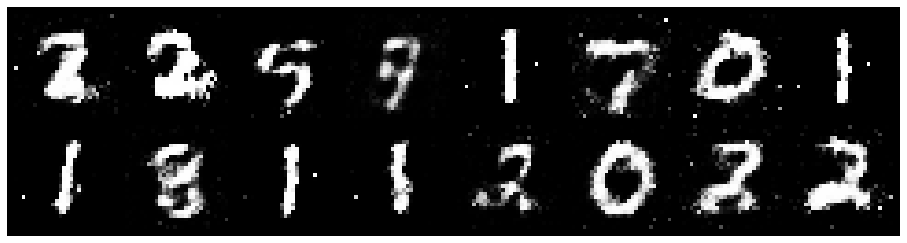

Epoch: [33/50], Batch Num: [100/600]
Discriminator Loss: 1.0326, Generator Loss: 1.0611
D(x): 0.6731, D(G(z)): 0.4005


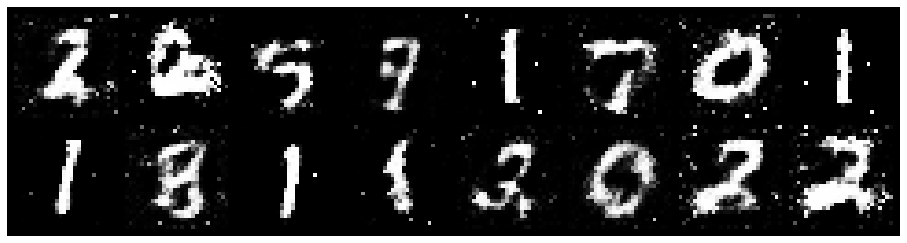

Epoch: [33/50], Batch Num: [200/600]
Discriminator Loss: 1.1584, Generator Loss: 1.1049
D(x): 0.6117, D(G(z)): 0.3888


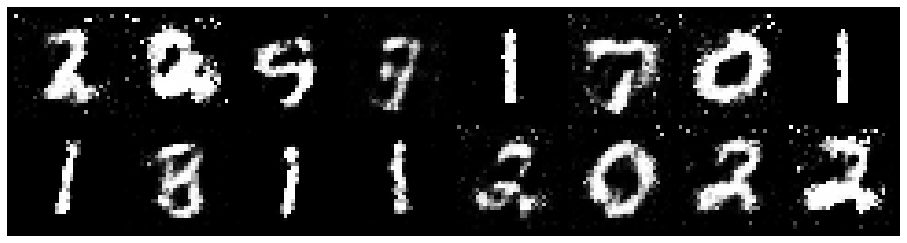

Epoch: [33/50], Batch Num: [300/600]
Discriminator Loss: 1.0438, Generator Loss: 1.0755
D(x): 0.6291, D(G(z)): 0.3667


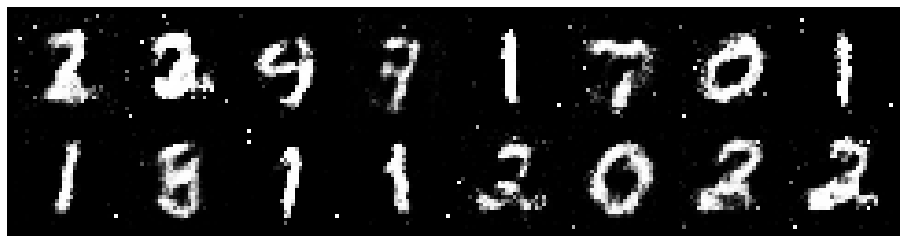

Epoch: [33/50], Batch Num: [400/600]
Discriminator Loss: 1.1130, Generator Loss: 1.5980
D(x): 0.5991, D(G(z)): 0.3231


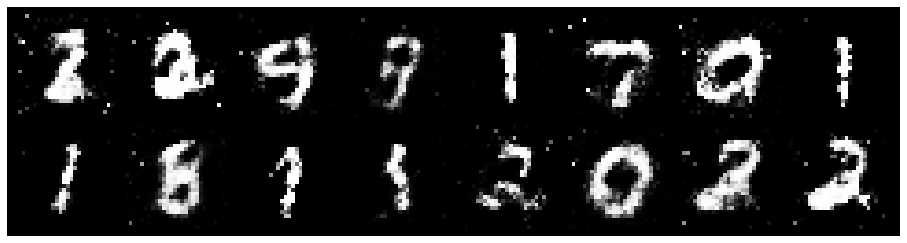

Epoch: [33/50], Batch Num: [500/600]
Discriminator Loss: 1.2283, Generator Loss: 1.6960
D(x): 0.5967, D(G(z)): 0.3397


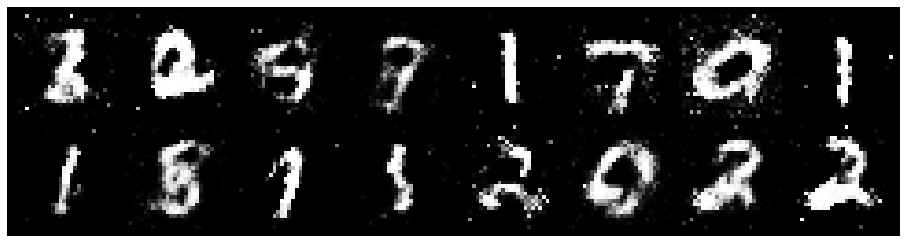

Epoch: [34/50], Batch Num: [0/600]
Discriminator Loss: 1.1615, Generator Loss: 1.5188
D(x): 0.6475, D(G(z)): 0.3742


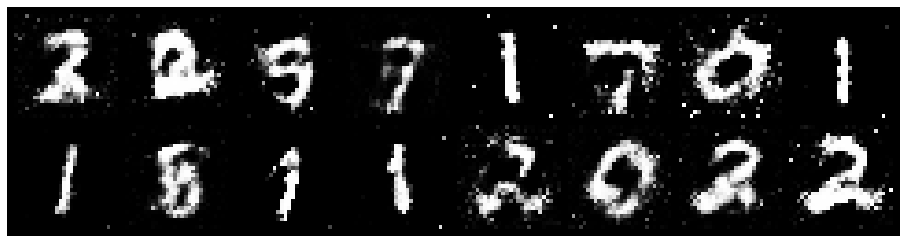

Epoch: [34/50], Batch Num: [100/600]
Discriminator Loss: 1.1012, Generator Loss: 1.2680
D(x): 0.7081, D(G(z)): 0.3952


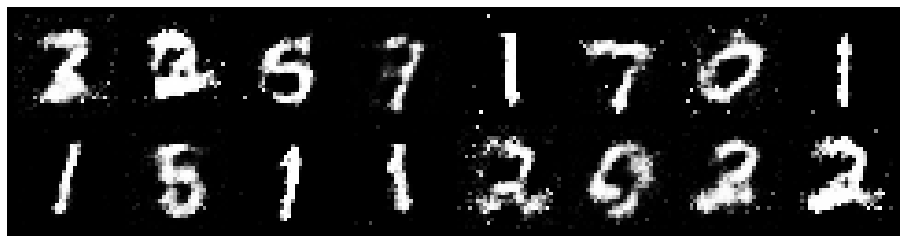

Epoch: [34/50], Batch Num: [200/600]
Discriminator Loss: 1.1683, Generator Loss: 1.1296
D(x): 0.6403, D(G(z)): 0.4096


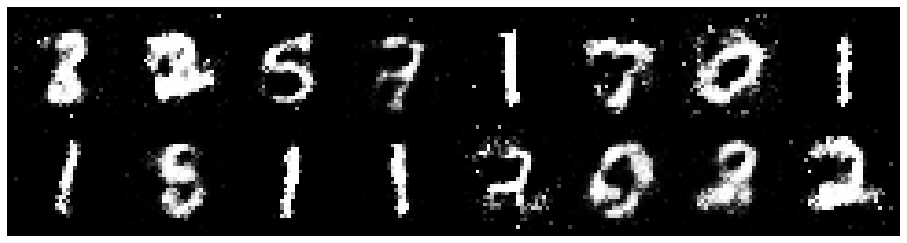

Epoch: [34/50], Batch Num: [300/600]
Discriminator Loss: 0.9216, Generator Loss: 1.1940
D(x): 0.7206, D(G(z)): 0.3703


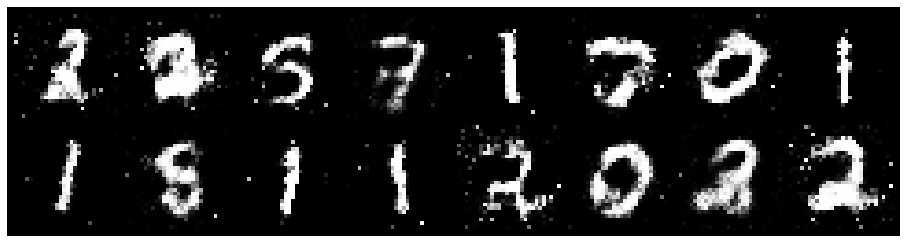

Epoch: [34/50], Batch Num: [400/600]
Discriminator Loss: 1.0443, Generator Loss: 1.5099
D(x): 0.6129, D(G(z)): 0.3034


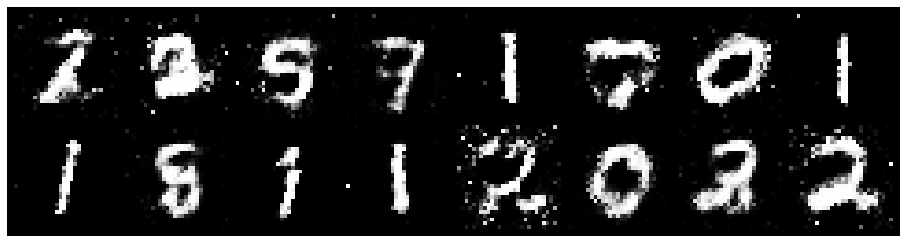

Epoch: [34/50], Batch Num: [500/600]
Discriminator Loss: 0.8680, Generator Loss: 1.5383
D(x): 0.6912, D(G(z)): 0.2922


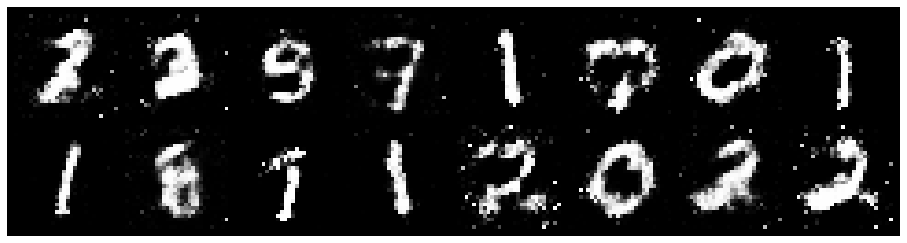

Epoch: [35/50], Batch Num: [0/600]
Discriminator Loss: 1.0348, Generator Loss: 1.1632
D(x): 0.6626, D(G(z)): 0.3990


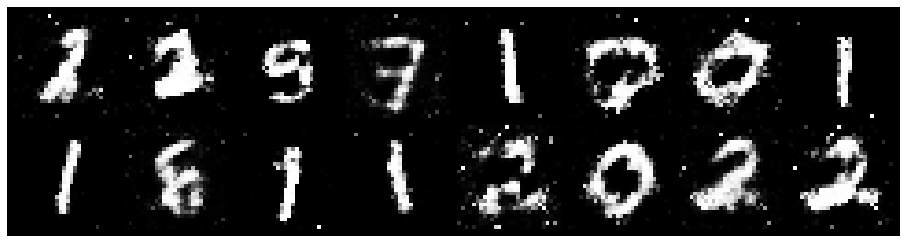

Epoch: [35/50], Batch Num: [100/600]
Discriminator Loss: 1.2155, Generator Loss: 1.2786
D(x): 0.5579, D(G(z)): 0.3715


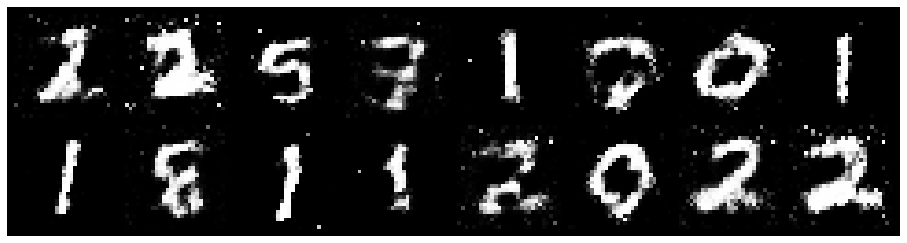

Epoch: [35/50], Batch Num: [200/600]
Discriminator Loss: 1.2129, Generator Loss: 1.2346
D(x): 0.5921, D(G(z)): 0.3945


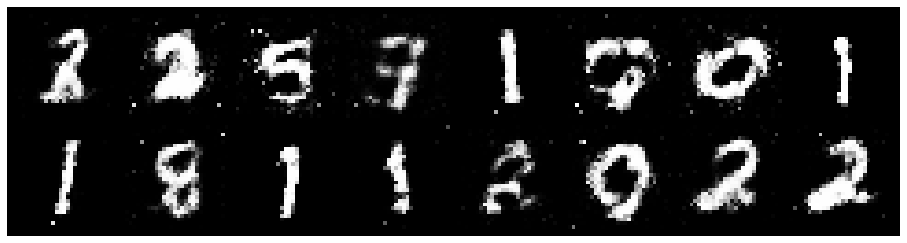

Epoch: [35/50], Batch Num: [300/600]
Discriminator Loss: 1.0290, Generator Loss: 1.2478
D(x): 0.6527, D(G(z)): 0.3351


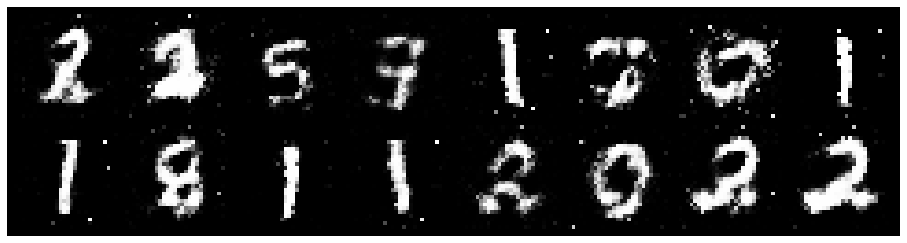

Epoch: [35/50], Batch Num: [400/600]
Discriminator Loss: 1.0081, Generator Loss: 1.0353
D(x): 0.6993, D(G(z)): 0.4131


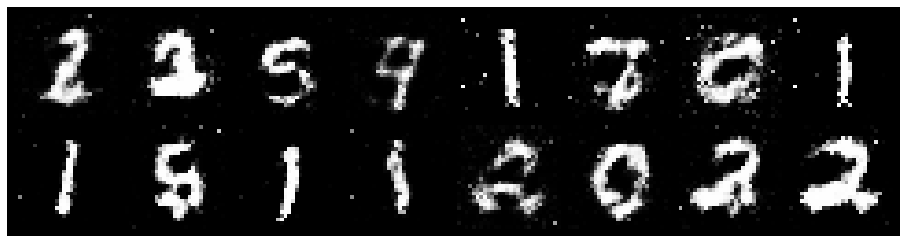

Epoch: [35/50], Batch Num: [500/600]
Discriminator Loss: 1.0951, Generator Loss: 1.0005
D(x): 0.6538, D(G(z)): 0.3917


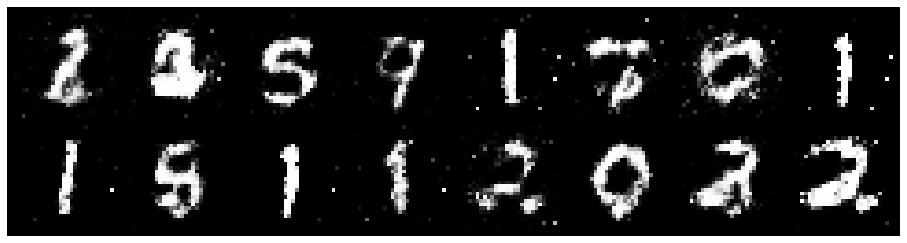

Epoch: [36/50], Batch Num: [0/600]
Discriminator Loss: 1.0456, Generator Loss: 1.0973
D(x): 0.6877, D(G(z)): 0.4139


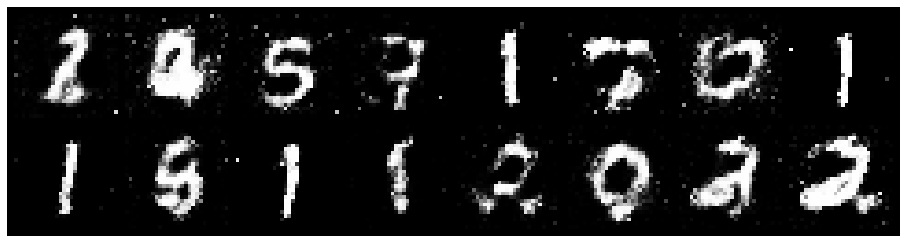

Epoch: [36/50], Batch Num: [100/600]
Discriminator Loss: 1.2528, Generator Loss: 0.9462
D(x): 0.6084, D(G(z)): 0.4503


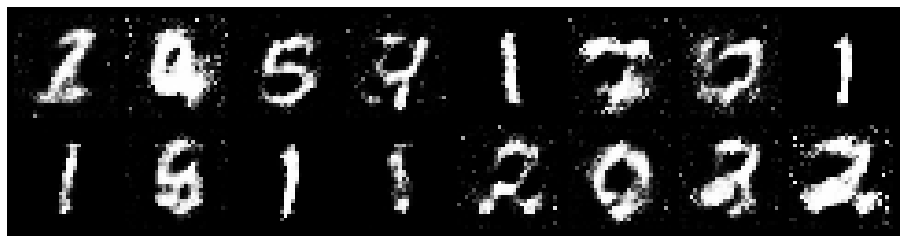

Epoch: [36/50], Batch Num: [200/600]
Discriminator Loss: 1.0222, Generator Loss: 1.1698
D(x): 0.6828, D(G(z)): 0.3813


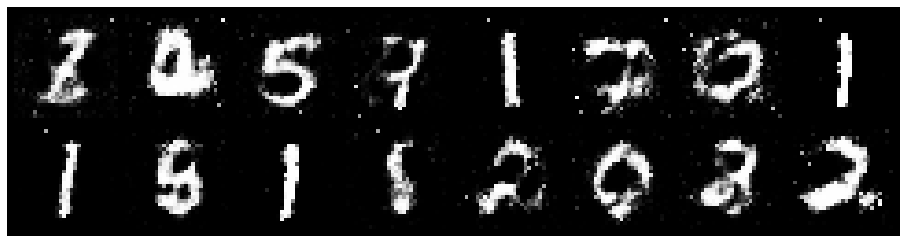

Epoch: [36/50], Batch Num: [300/600]
Discriminator Loss: 1.0442, Generator Loss: 1.4663
D(x): 0.7062, D(G(z)): 0.3768


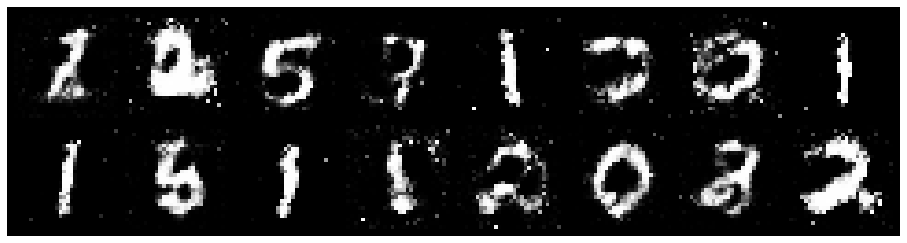

Epoch: [36/50], Batch Num: [400/600]
Discriminator Loss: 1.2477, Generator Loss: 1.1854
D(x): 0.6474, D(G(z)): 0.4574


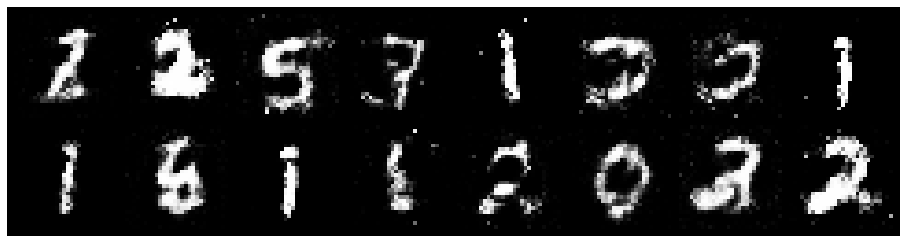

Epoch: [36/50], Batch Num: [500/600]
Discriminator Loss: 1.1335, Generator Loss: 1.1226
D(x): 0.7208, D(G(z)): 0.4419


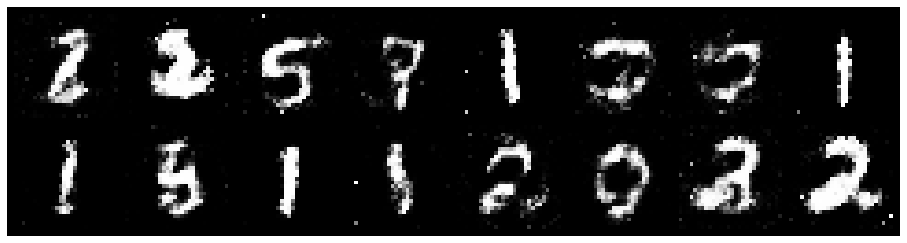

Epoch: [37/50], Batch Num: [0/600]
Discriminator Loss: 1.0212, Generator Loss: 1.4007
D(x): 0.6127, D(G(z)): 0.2769


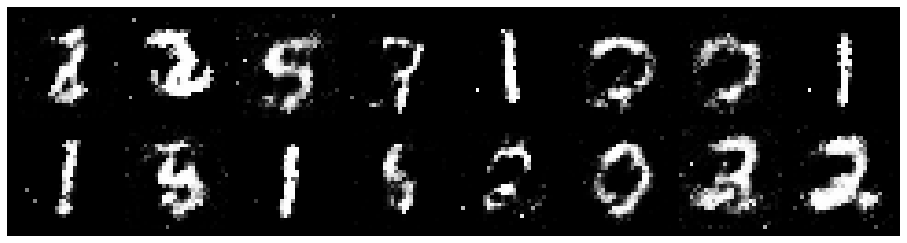

Epoch: [37/50], Batch Num: [100/600]
Discriminator Loss: 1.0409, Generator Loss: 1.3449
D(x): 0.6819, D(G(z)): 0.3668


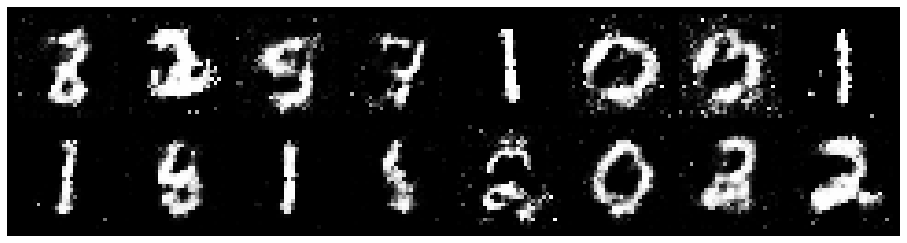

Epoch: [37/50], Batch Num: [200/600]
Discriminator Loss: 1.1162, Generator Loss: 1.2717
D(x): 0.6113, D(G(z)): 0.3632


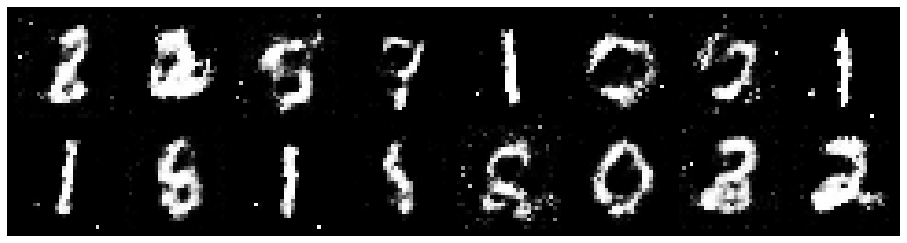

Epoch: [37/50], Batch Num: [300/600]
Discriminator Loss: 1.0782, Generator Loss: 1.1219
D(x): 0.6180, D(G(z)): 0.3490


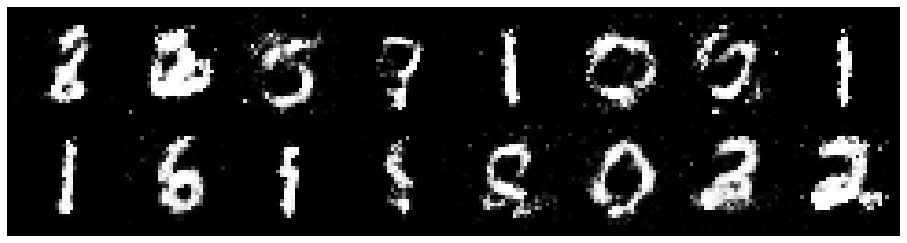

Epoch: [37/50], Batch Num: [400/600]
Discriminator Loss: 0.9778, Generator Loss: 1.6315
D(x): 0.6805, D(G(z)): 0.3511


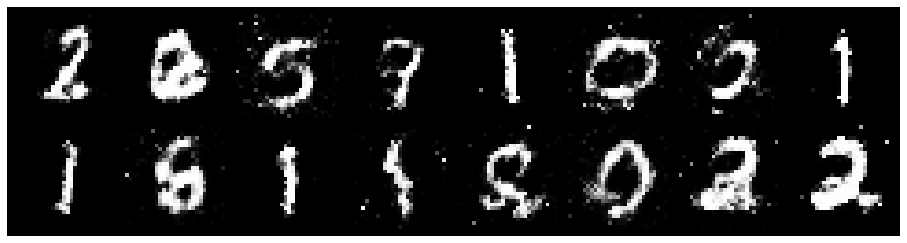

Epoch: [37/50], Batch Num: [500/600]
Discriminator Loss: 1.0717, Generator Loss: 1.2083
D(x): 0.6900, D(G(z)): 0.4178


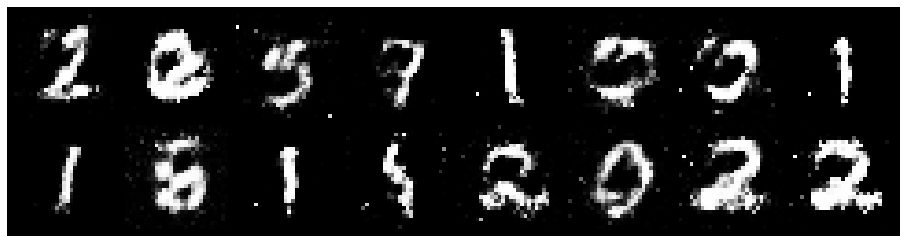

Epoch: [38/50], Batch Num: [0/600]
Discriminator Loss: 1.1960, Generator Loss: 1.3500
D(x): 0.5473, D(G(z)): 0.3342


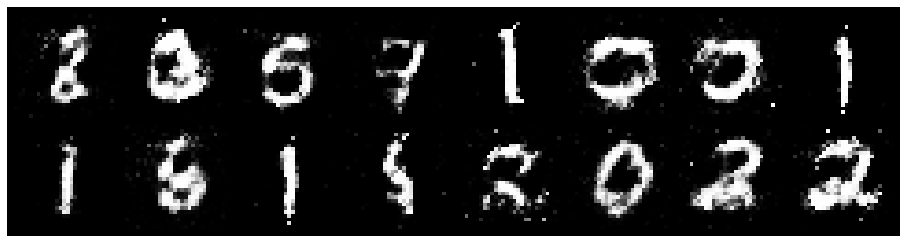

Epoch: [38/50], Batch Num: [100/600]
Discriminator Loss: 1.3242, Generator Loss: 1.1465
D(x): 0.5111, D(G(z)): 0.3709


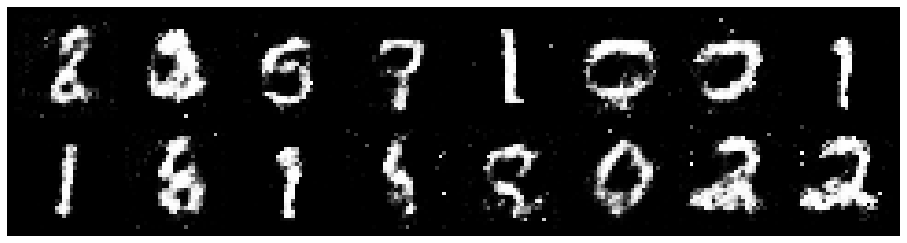

Epoch: [38/50], Batch Num: [200/600]
Discriminator Loss: 1.2364, Generator Loss: 0.7814
D(x): 0.6630, D(G(z)): 0.4769


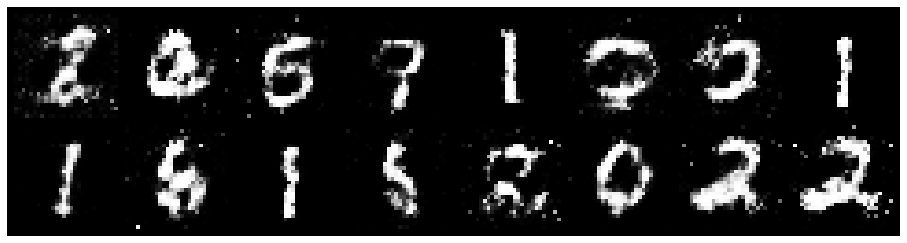

Epoch: [38/50], Batch Num: [300/600]
Discriminator Loss: 1.2645, Generator Loss: 1.1481
D(x): 0.6092, D(G(z)): 0.4394


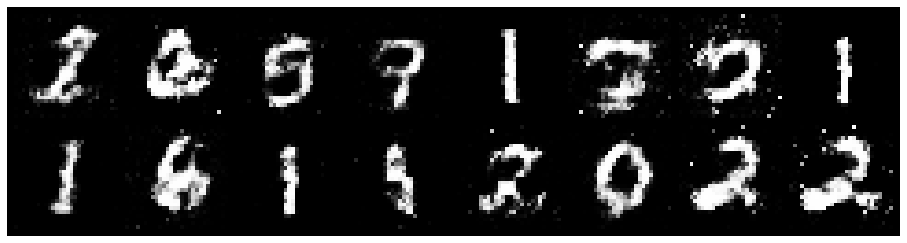

Epoch: [38/50], Batch Num: [400/600]
Discriminator Loss: 0.9961, Generator Loss: 1.2198
D(x): 0.6366, D(G(z)): 0.3171


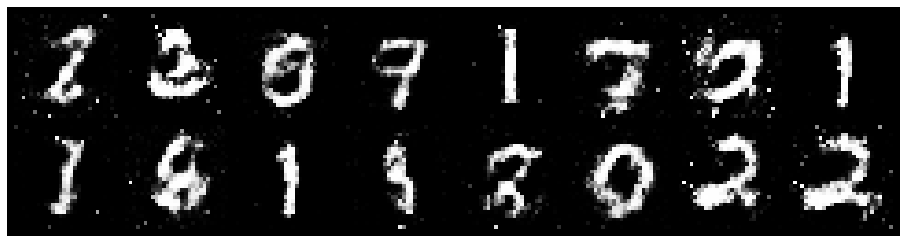

Epoch: [38/50], Batch Num: [500/600]
Discriminator Loss: 0.9523, Generator Loss: 1.4837
D(x): 0.6441, D(G(z)): 0.3146


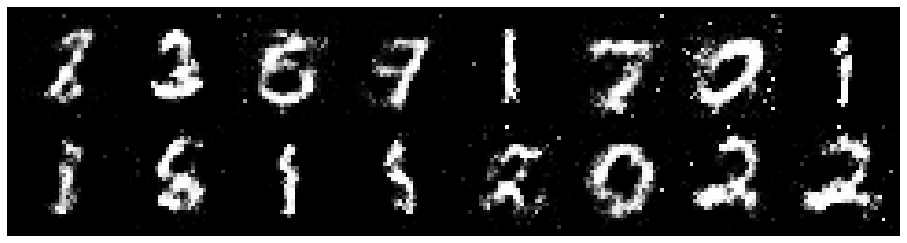

Epoch: [39/50], Batch Num: [0/600]
Discriminator Loss: 0.9759, Generator Loss: 1.4352
D(x): 0.6583, D(G(z)): 0.3446


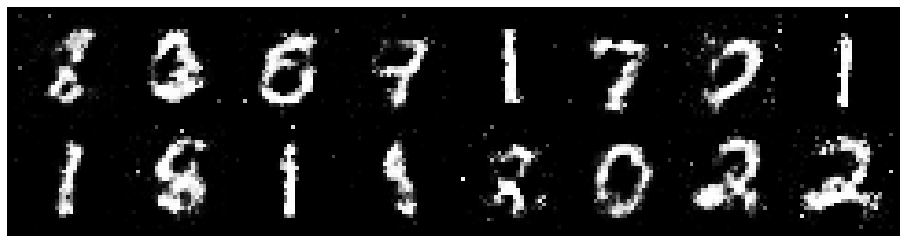

Epoch: [39/50], Batch Num: [100/600]
Discriminator Loss: 1.0391, Generator Loss: 1.1243
D(x): 0.6772, D(G(z)): 0.4161


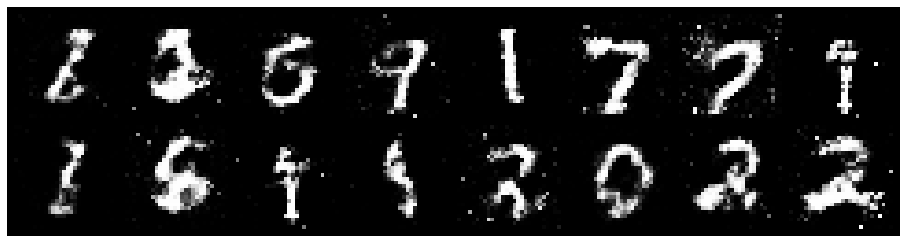

Epoch: [39/50], Batch Num: [200/600]
Discriminator Loss: 1.1746, Generator Loss: 1.2469
D(x): 0.6070, D(G(z)): 0.4110


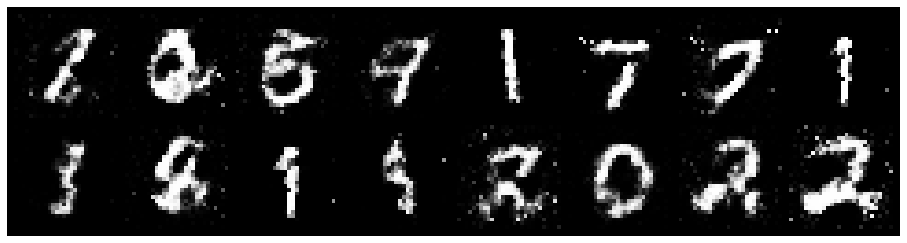

Epoch: [39/50], Batch Num: [300/600]
Discriminator Loss: 0.9224, Generator Loss: 1.4599
D(x): 0.6695, D(G(z)): 0.3266


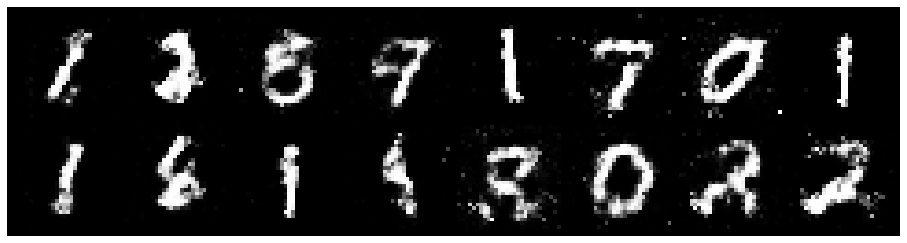

Epoch: [39/50], Batch Num: [400/600]
Discriminator Loss: 0.9074, Generator Loss: 1.6425
D(x): 0.6491, D(G(z)): 0.2897


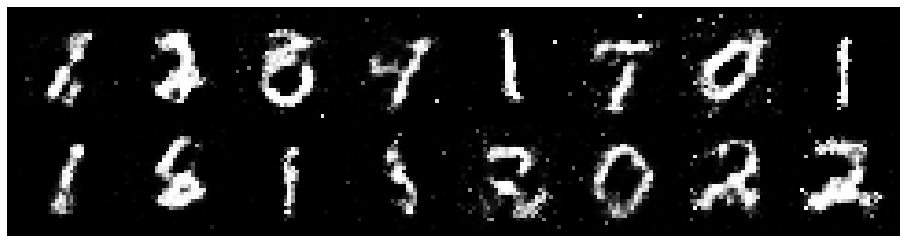

Epoch: [39/50], Batch Num: [500/600]
Discriminator Loss: 1.1946, Generator Loss: 1.0031
D(x): 0.5730, D(G(z)): 0.3734


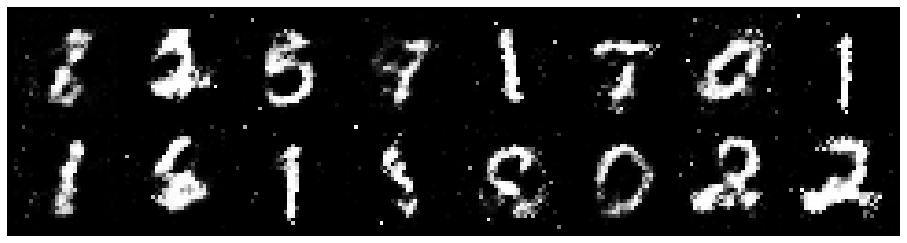

Epoch: [40/50], Batch Num: [0/600]
Discriminator Loss: 1.0686, Generator Loss: 1.1057
D(x): 0.6480, D(G(z)): 0.3924


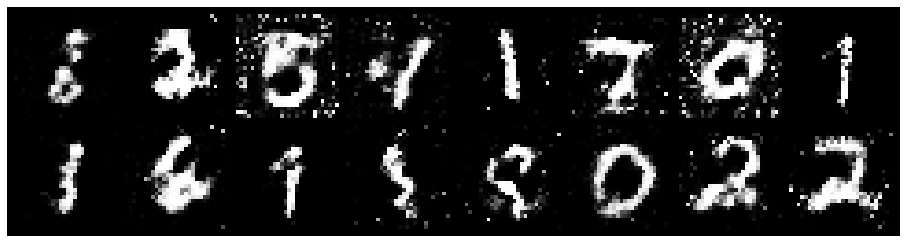

Epoch: [40/50], Batch Num: [100/600]
Discriminator Loss: 1.0714, Generator Loss: 1.1877
D(x): 0.6718, D(G(z)): 0.4191


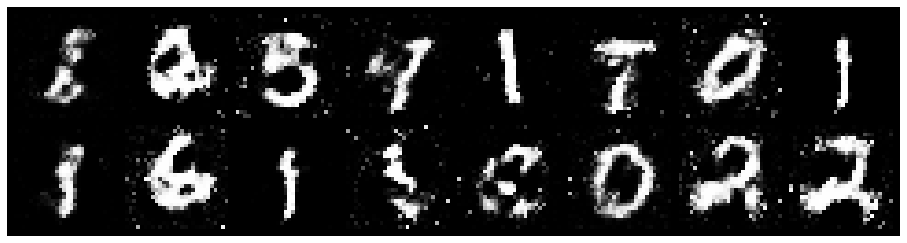

Epoch: [40/50], Batch Num: [200/600]
Discriminator Loss: 1.1436, Generator Loss: 1.1477
D(x): 0.6304, D(G(z)): 0.3914


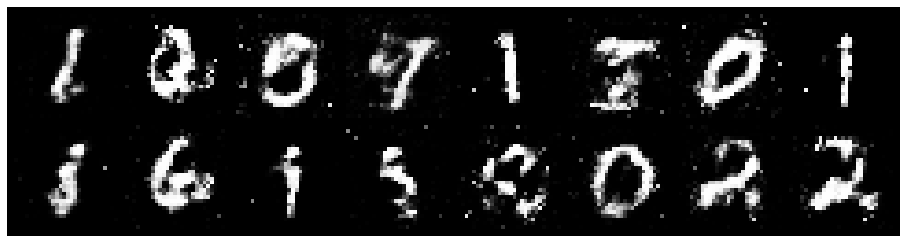

Epoch: [40/50], Batch Num: [300/600]
Discriminator Loss: 1.1842, Generator Loss: 1.2000
D(x): 0.5936, D(G(z)): 0.3834


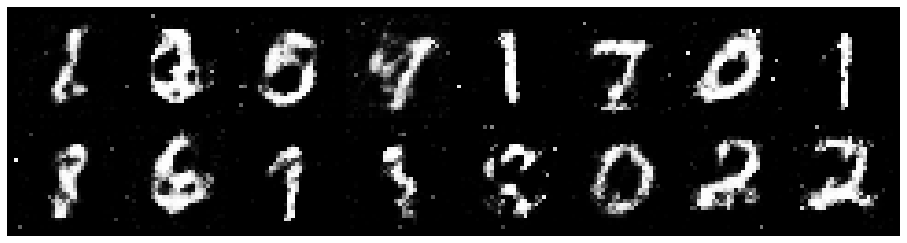

Epoch: [40/50], Batch Num: [400/600]
Discriminator Loss: 0.9857, Generator Loss: 1.2696
D(x): 0.6177, D(G(z)): 0.3195


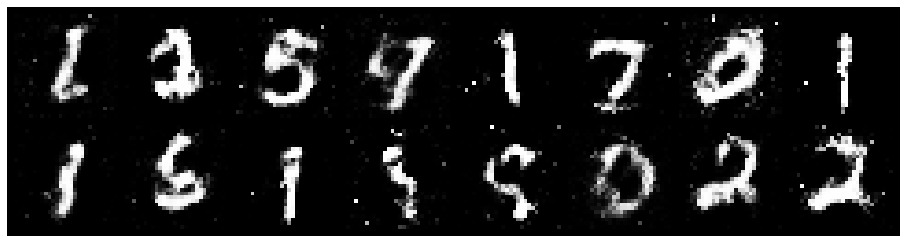

Epoch: [40/50], Batch Num: [500/600]
Discriminator Loss: 1.0513, Generator Loss: 1.5242
D(x): 0.6602, D(G(z)): 0.3229


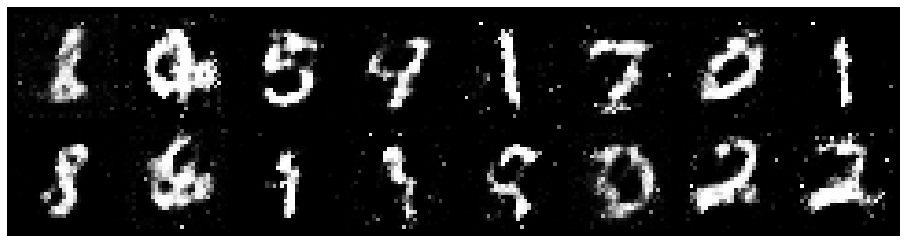

Epoch: [41/50], Batch Num: [0/600]
Discriminator Loss: 0.8995, Generator Loss: 1.4386
D(x): 0.7044, D(G(z)): 0.3508


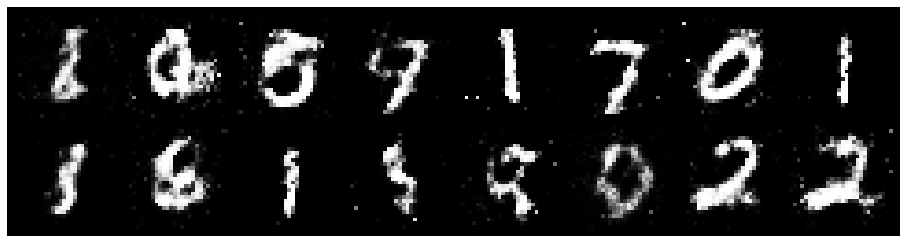

Epoch: [41/50], Batch Num: [100/600]
Discriminator Loss: 1.2124, Generator Loss: 1.3277
D(x): 0.5413, D(G(z)): 0.3031


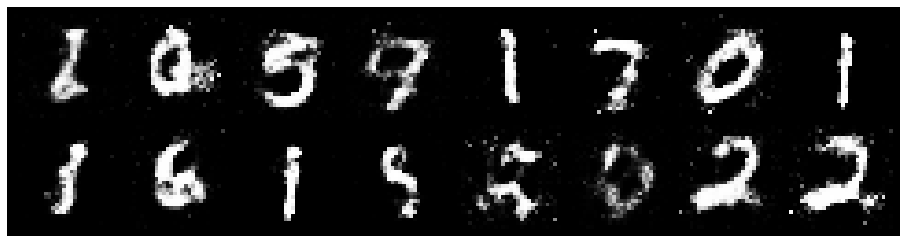

Epoch: [41/50], Batch Num: [200/600]
Discriminator Loss: 0.9674, Generator Loss: 1.3657
D(x): 0.6039, D(G(z)): 0.2876


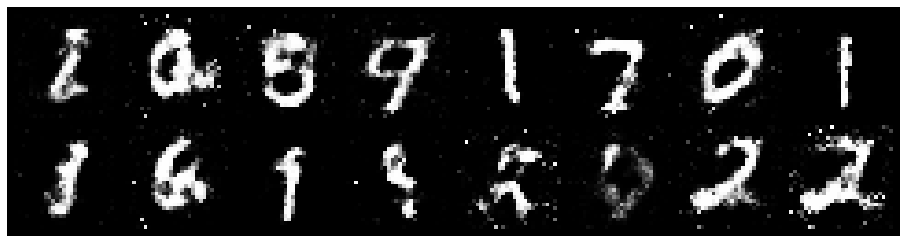

Epoch: [41/50], Batch Num: [300/600]
Discriminator Loss: 1.0235, Generator Loss: 1.4592
D(x): 0.6261, D(G(z)): 0.3099


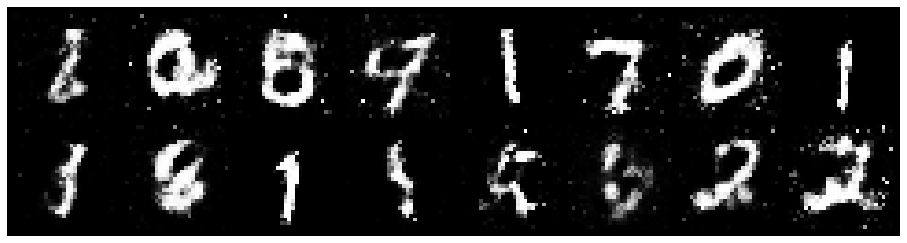

Epoch: [41/50], Batch Num: [400/600]
Discriminator Loss: 1.0705, Generator Loss: 1.4487
D(x): 0.6849, D(G(z)): 0.3989


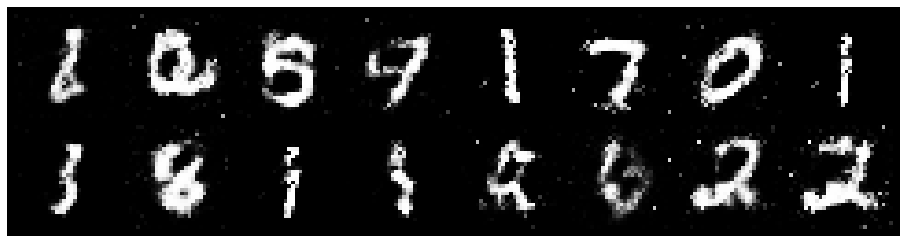

Epoch: [41/50], Batch Num: [500/600]
Discriminator Loss: 1.0234, Generator Loss: 1.0737
D(x): 0.6139, D(G(z)): 0.3451


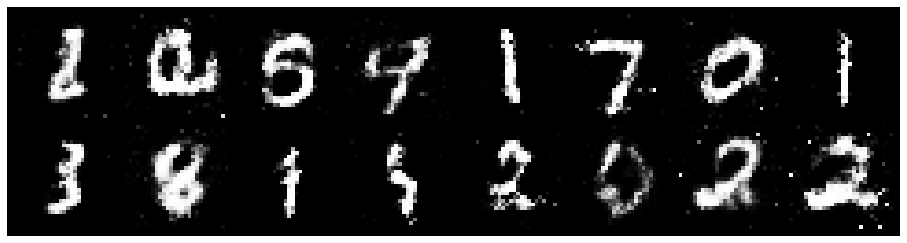

Epoch: [42/50], Batch Num: [0/600]
Discriminator Loss: 1.1709, Generator Loss: 1.0273
D(x): 0.5855, D(G(z)): 0.4017


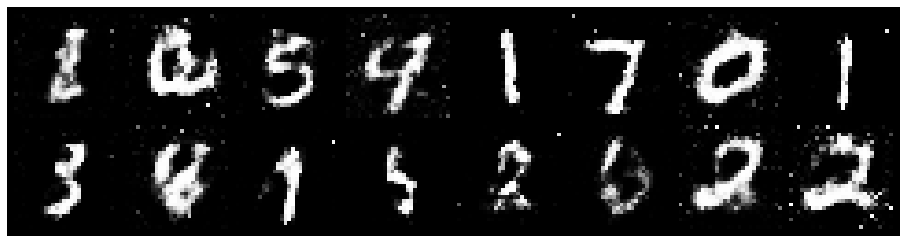

Epoch: [42/50], Batch Num: [100/600]
Discriminator Loss: 1.1332, Generator Loss: 0.9062
D(x): 0.6047, D(G(z)): 0.3954


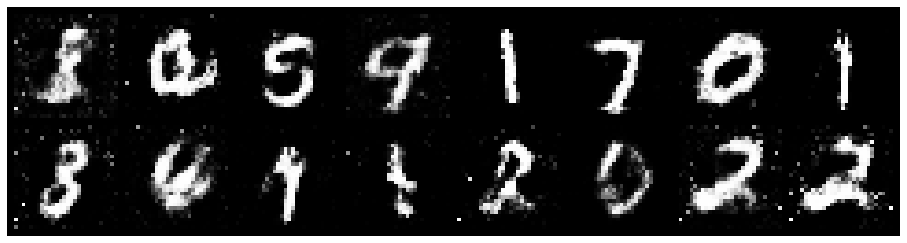

Epoch: [42/50], Batch Num: [200/600]
Discriminator Loss: 1.0419, Generator Loss: 1.0620
D(x): 0.5757, D(G(z)): 0.3106


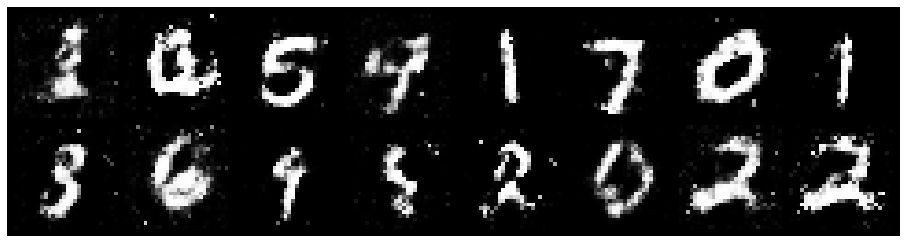

Epoch: [42/50], Batch Num: [300/600]
Discriminator Loss: 1.2562, Generator Loss: 1.0403
D(x): 0.6609, D(G(z)): 0.4624


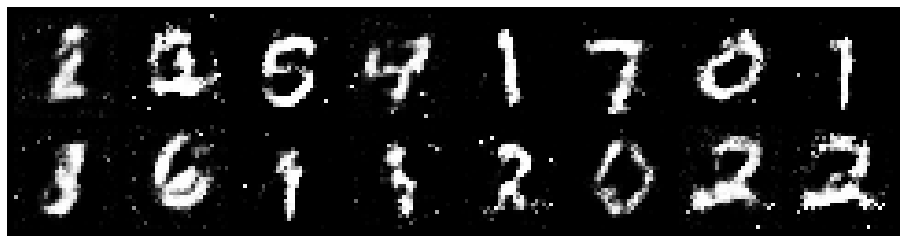

Epoch: [42/50], Batch Num: [400/600]
Discriminator Loss: 1.1861, Generator Loss: 1.1100
D(x): 0.6407, D(G(z)): 0.4489


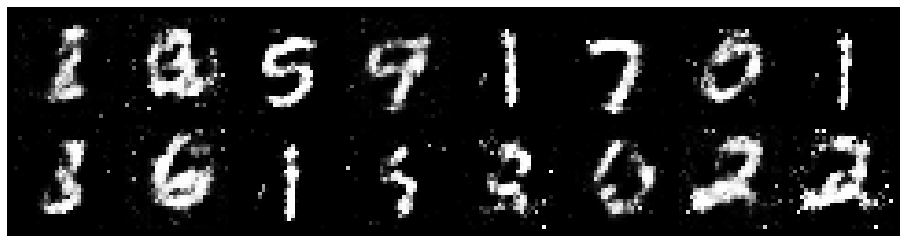

Epoch: [42/50], Batch Num: [500/600]
Discriminator Loss: 1.1840, Generator Loss: 1.3242
D(x): 0.5760, D(G(z)): 0.3706


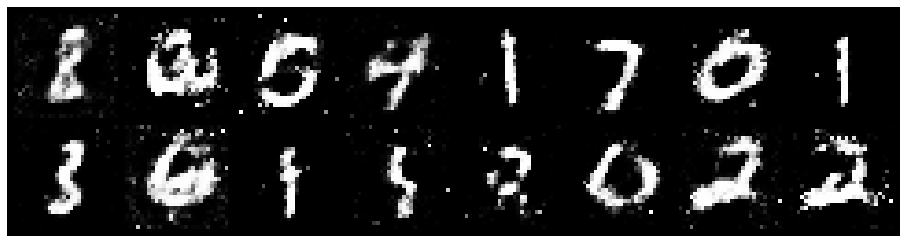

Epoch: [43/50], Batch Num: [0/600]
Discriminator Loss: 1.1549, Generator Loss: 1.1733
D(x): 0.6147, D(G(z)): 0.3896


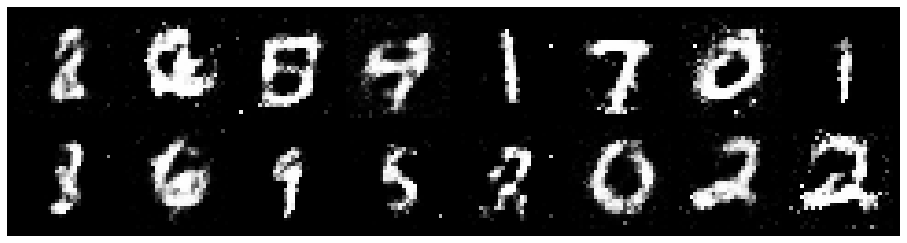

Epoch: [43/50], Batch Num: [100/600]
Discriminator Loss: 1.2315, Generator Loss: 1.1065
D(x): 0.6369, D(G(z)): 0.4292


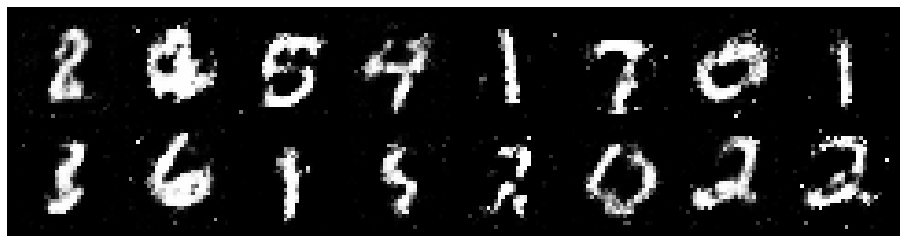

Epoch: [43/50], Batch Num: [200/600]
Discriminator Loss: 1.0553, Generator Loss: 1.0477
D(x): 0.6452, D(G(z)): 0.3991


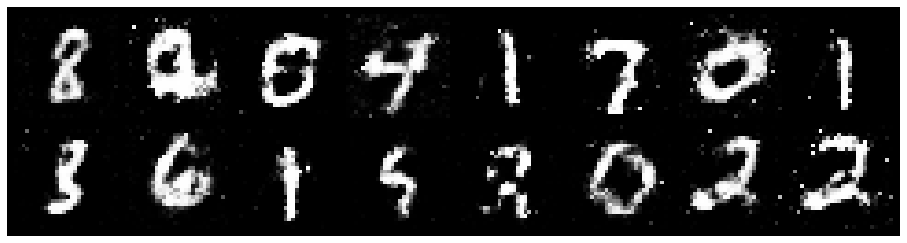

Epoch: [43/50], Batch Num: [300/600]
Discriminator Loss: 1.1743, Generator Loss: 1.2629
D(x): 0.6271, D(G(z)): 0.3971


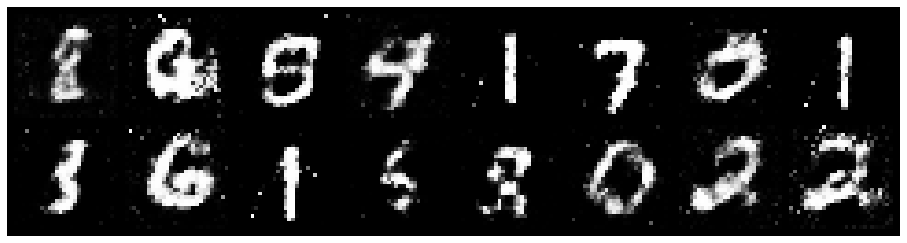

Epoch: [43/50], Batch Num: [400/600]
Discriminator Loss: 1.2100, Generator Loss: 1.3930
D(x): 0.6586, D(G(z)): 0.3962


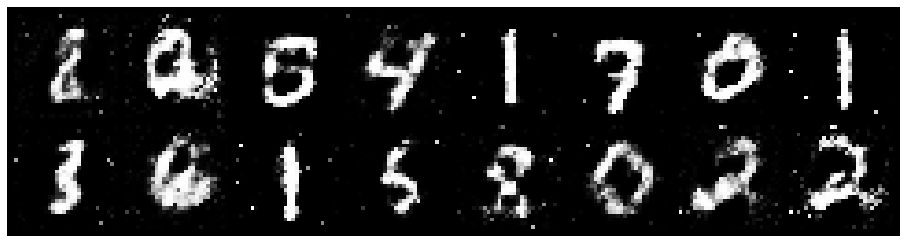

Epoch: [43/50], Batch Num: [500/600]
Discriminator Loss: 1.1269, Generator Loss: 1.5319
D(x): 0.5985, D(G(z)): 0.2923


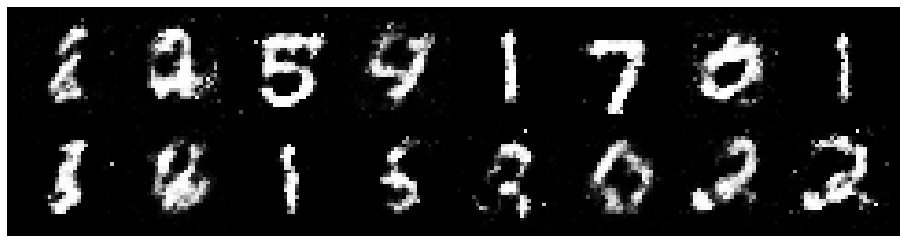

Epoch: [44/50], Batch Num: [0/600]
Discriminator Loss: 0.8626, Generator Loss: 1.2323
D(x): 0.6947, D(G(z)): 0.3139


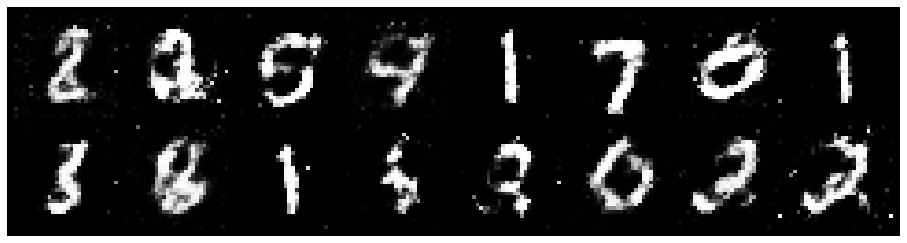

Epoch: [44/50], Batch Num: [100/600]
Discriminator Loss: 1.1112, Generator Loss: 1.1786
D(x): 0.6242, D(G(z)): 0.3927


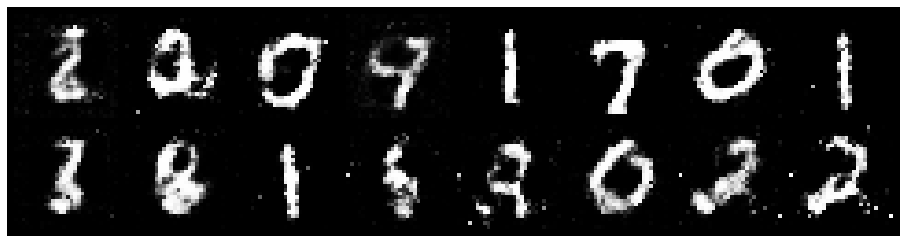

Epoch: [44/50], Batch Num: [200/600]
Discriminator Loss: 1.2293, Generator Loss: 0.9593
D(x): 0.5840, D(G(z)): 0.3825


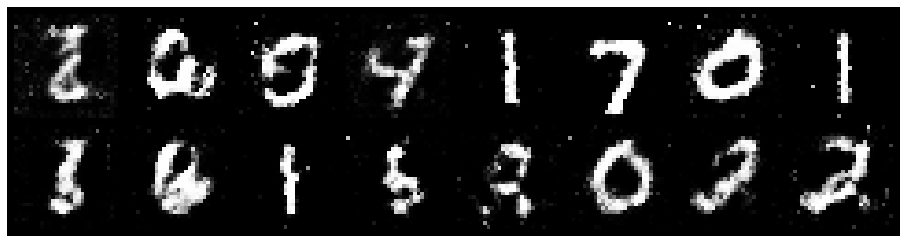

Epoch: [44/50], Batch Num: [300/600]
Discriminator Loss: 1.0404, Generator Loss: 1.2283
D(x): 0.6625, D(G(z)): 0.3690


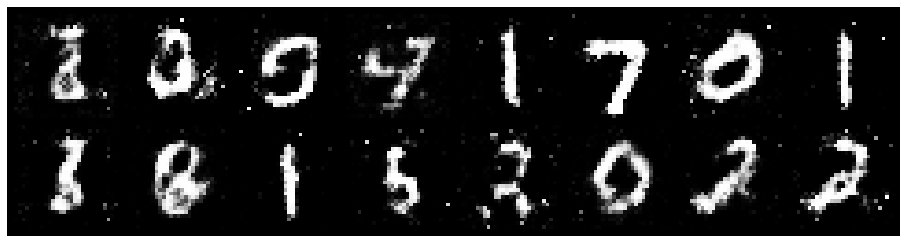

Epoch: [44/50], Batch Num: [400/600]
Discriminator Loss: 1.0286, Generator Loss: 1.2308
D(x): 0.6145, D(G(z)): 0.3367


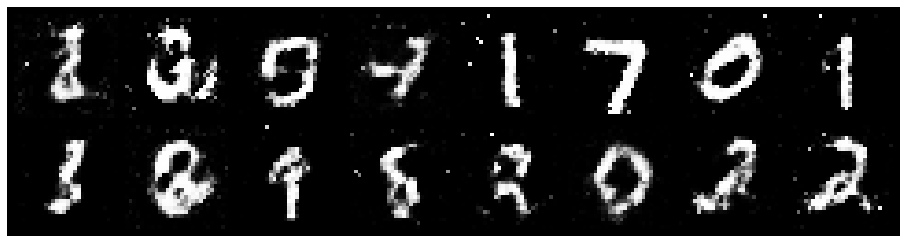

Epoch: [44/50], Batch Num: [500/600]
Discriminator Loss: 1.2638, Generator Loss: 0.9398
D(x): 0.5735, D(G(z)): 0.4113


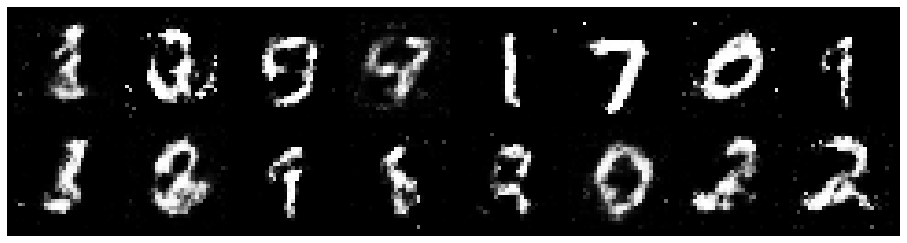

Epoch: [45/50], Batch Num: [0/600]
Discriminator Loss: 1.2432, Generator Loss: 1.3274
D(x): 0.5705, D(G(z)): 0.3881


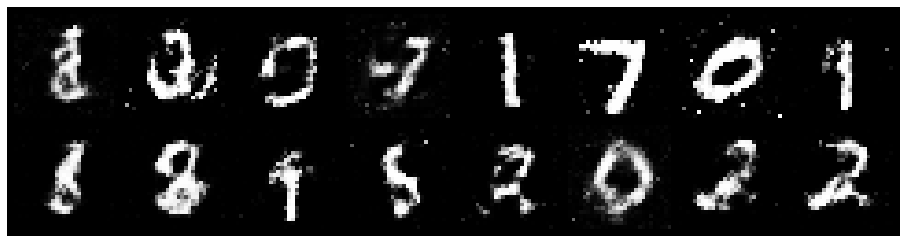

Epoch: [45/50], Batch Num: [100/600]
Discriminator Loss: 1.0835, Generator Loss: 1.0883
D(x): 0.6294, D(G(z)): 0.3533


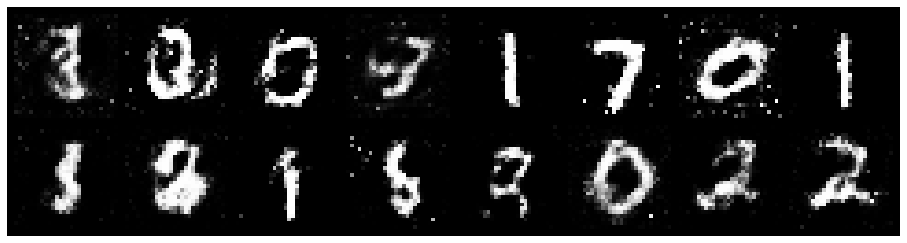

Epoch: [45/50], Batch Num: [200/600]
Discriminator Loss: 1.1301, Generator Loss: 1.0244
D(x): 0.6293, D(G(z)): 0.4157


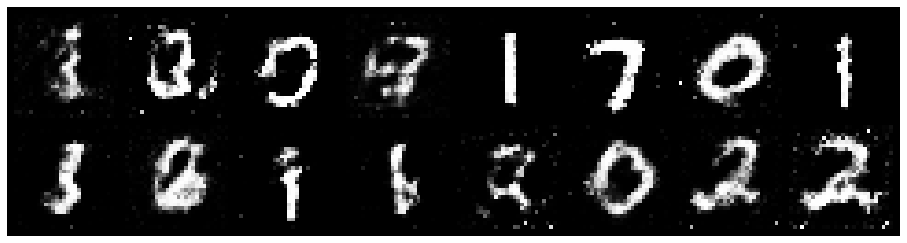

Epoch: [45/50], Batch Num: [300/600]
Discriminator Loss: 1.1177, Generator Loss: 1.1298
D(x): 0.6354, D(G(z)): 0.4219


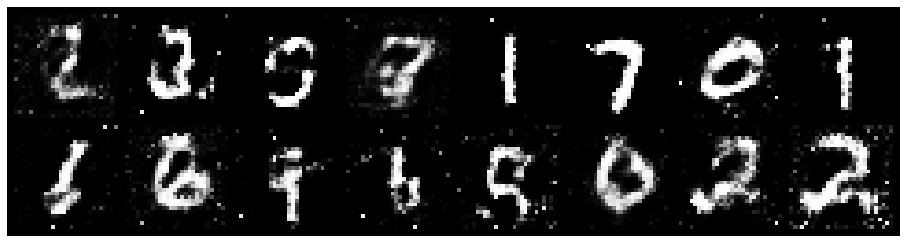

Epoch: [45/50], Batch Num: [400/600]
Discriminator Loss: 1.1790, Generator Loss: 0.9775
D(x): 0.5709, D(G(z)): 0.3939


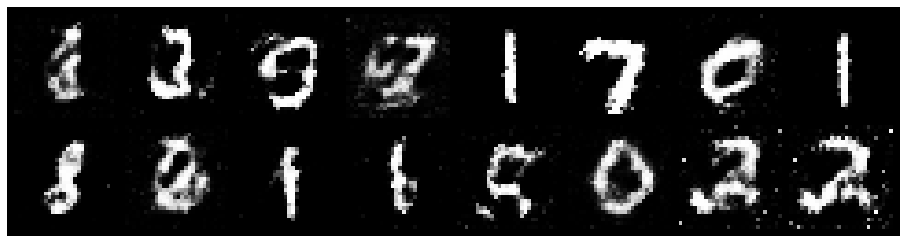

Epoch: [45/50], Batch Num: [500/600]
Discriminator Loss: 1.1780, Generator Loss: 0.9260
D(x): 0.5765, D(G(z)): 0.3916


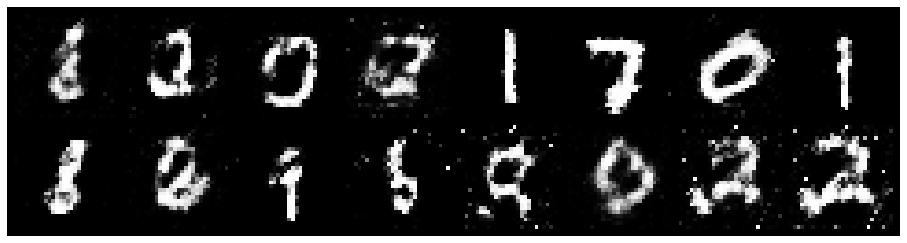

Epoch: [46/50], Batch Num: [0/600]
Discriminator Loss: 1.2184, Generator Loss: 1.0520
D(x): 0.5825, D(G(z)): 0.4194


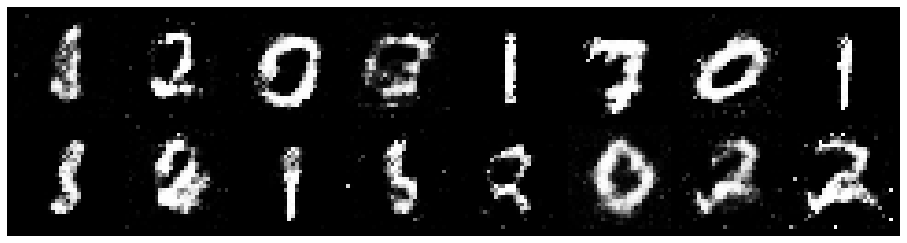

Epoch: [46/50], Batch Num: [100/600]
Discriminator Loss: 1.1446, Generator Loss: 1.2873
D(x): 0.6044, D(G(z)): 0.3547


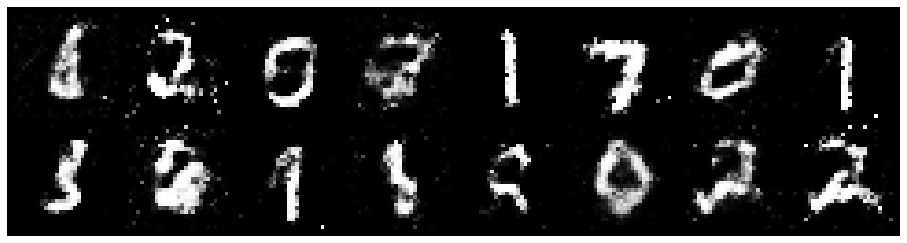

Epoch: [46/50], Batch Num: [200/600]
Discriminator Loss: 1.1411, Generator Loss: 0.9610
D(x): 0.6588, D(G(z)): 0.4485


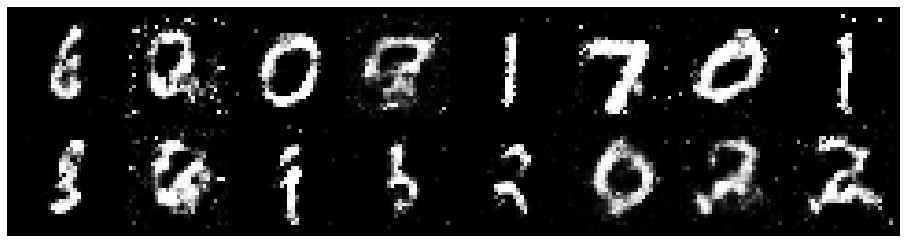

Epoch: [46/50], Batch Num: [300/600]
Discriminator Loss: 1.1195, Generator Loss: 1.1844
D(x): 0.5863, D(G(z)): 0.3774


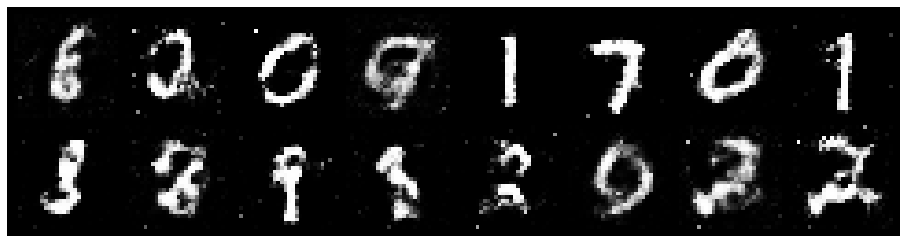

Epoch: [46/50], Batch Num: [400/600]
Discriminator Loss: 0.9702, Generator Loss: 1.1646
D(x): 0.6407, D(G(z)): 0.3343


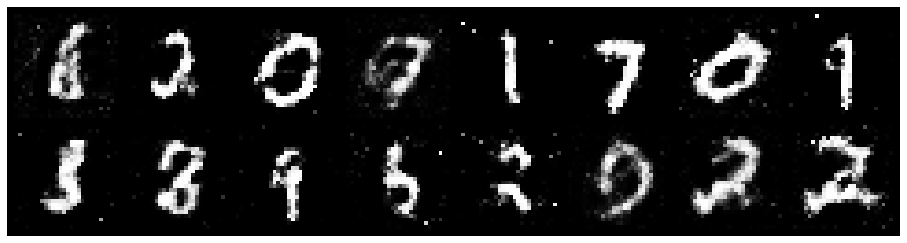

Epoch: [46/50], Batch Num: [500/600]
Discriminator Loss: 1.1722, Generator Loss: 1.0484
D(x): 0.6028, D(G(z)): 0.4156


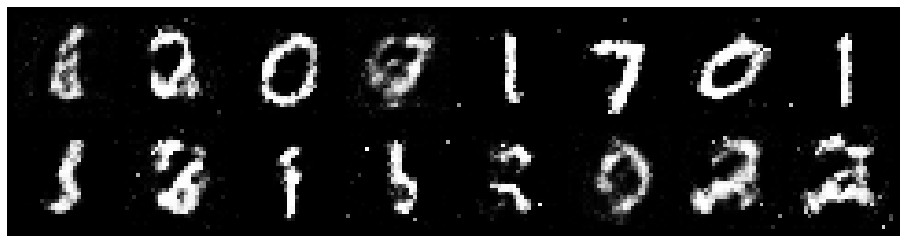

Epoch: [47/50], Batch Num: [0/600]
Discriminator Loss: 1.2197, Generator Loss: 1.1108
D(x): 0.5349, D(G(z)): 0.3776


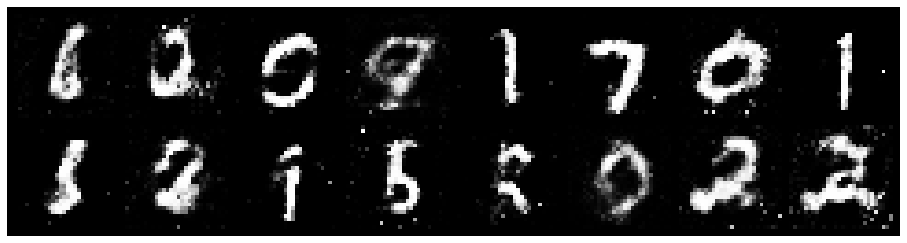

Epoch: [47/50], Batch Num: [100/600]
Discriminator Loss: 1.1676, Generator Loss: 1.0863
D(x): 0.5878, D(G(z)): 0.4054


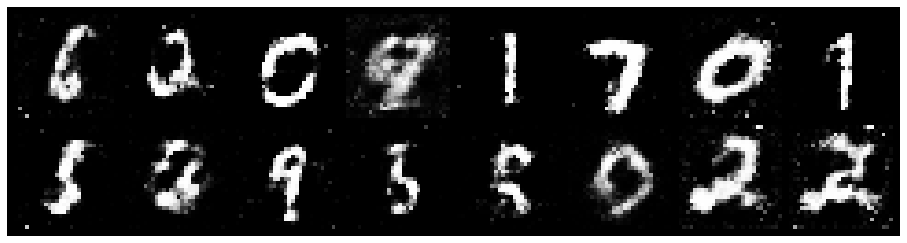

Epoch: [47/50], Batch Num: [200/600]
Discriminator Loss: 1.1588, Generator Loss: 1.1731
D(x): 0.5647, D(G(z)): 0.3764


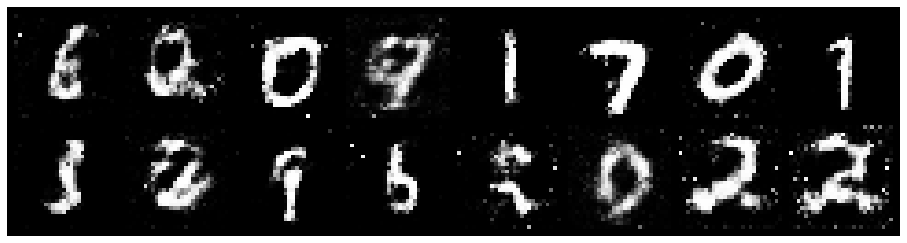

Epoch: [47/50], Batch Num: [300/600]
Discriminator Loss: 1.1040, Generator Loss: 1.0969
D(x): 0.6180, D(G(z)): 0.3782


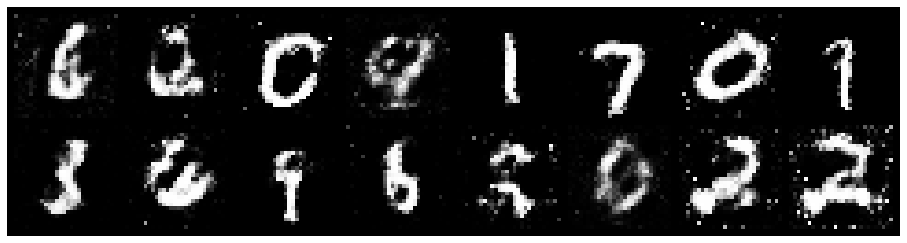

Epoch: [47/50], Batch Num: [400/600]
Discriminator Loss: 1.1169, Generator Loss: 1.2058
D(x): 0.5451, D(G(z)): 0.3486


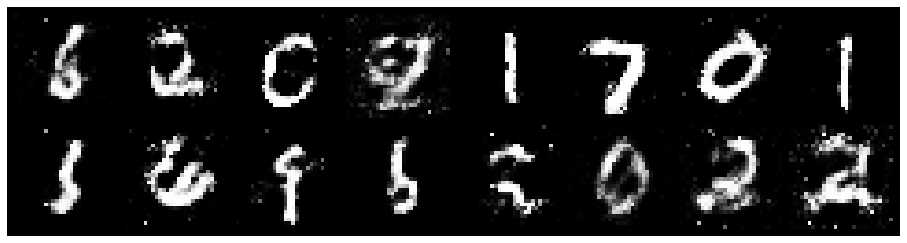

Epoch: [47/50], Batch Num: [500/600]
Discriminator Loss: 1.1643, Generator Loss: 0.9298
D(x): 0.5881, D(G(z)): 0.4363


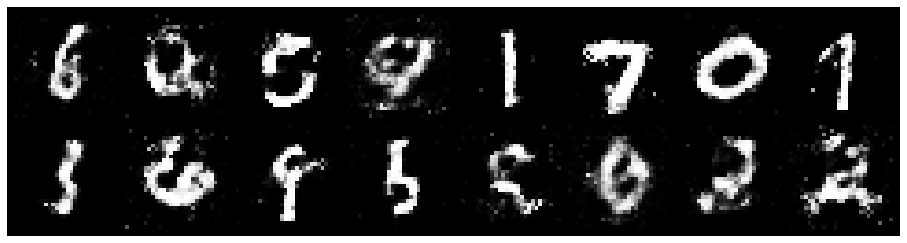

Epoch: [48/50], Batch Num: [0/600]
Discriminator Loss: 1.0725, Generator Loss: 0.9212
D(x): 0.6651, D(G(z)): 0.4253


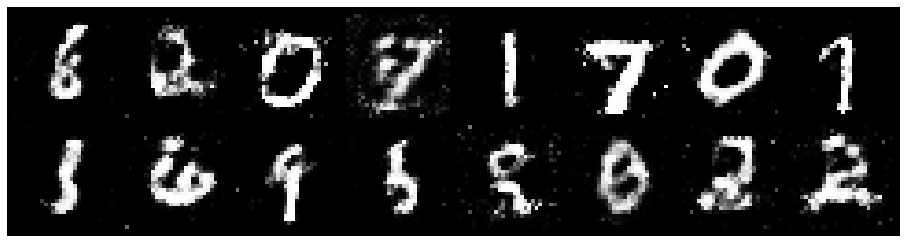

Epoch: [48/50], Batch Num: [100/600]
Discriminator Loss: 1.2260, Generator Loss: 0.9409
D(x): 0.5606, D(G(z)): 0.4073


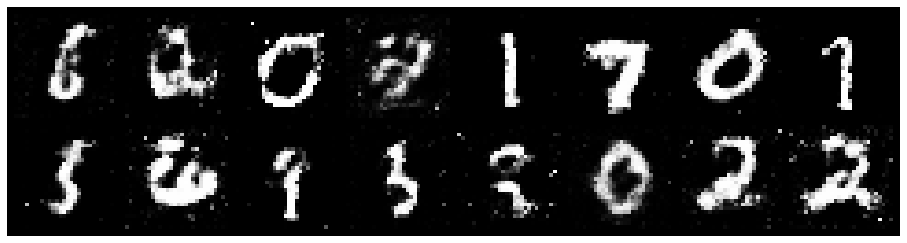

Epoch: [48/50], Batch Num: [200/600]
Discriminator Loss: 1.2356, Generator Loss: 0.9367
D(x): 0.5476, D(G(z)): 0.3942


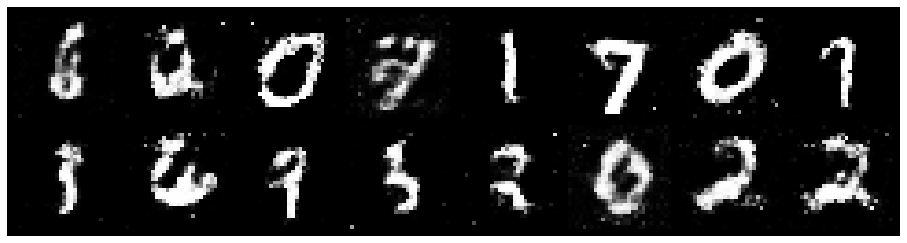

Epoch: [48/50], Batch Num: [300/600]
Discriminator Loss: 1.1473, Generator Loss: 1.1890
D(x): 0.5222, D(G(z)): 0.3129


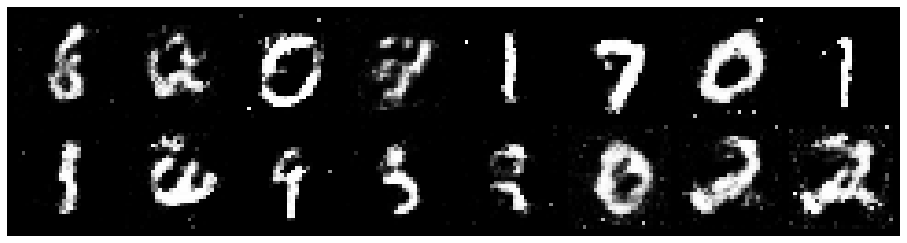

Epoch: [48/50], Batch Num: [400/600]
Discriminator Loss: 0.9426, Generator Loss: 1.2380
D(x): 0.6656, D(G(z)): 0.3299


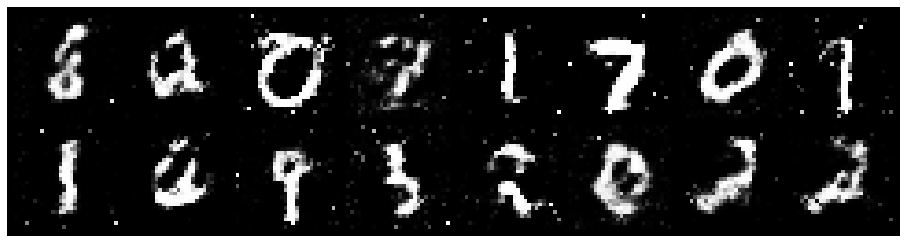

Epoch: [48/50], Batch Num: [500/600]
Discriminator Loss: 1.1189, Generator Loss: 1.0120
D(x): 0.6645, D(G(z)): 0.4411


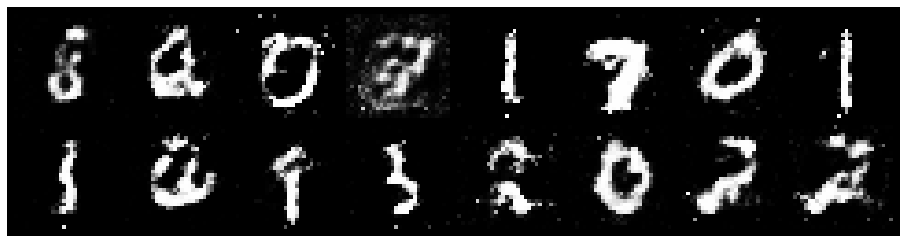

Epoch: [49/50], Batch Num: [0/600]
Discriminator Loss: 1.1402, Generator Loss: 1.1182
D(x): 0.6549, D(G(z)): 0.4559


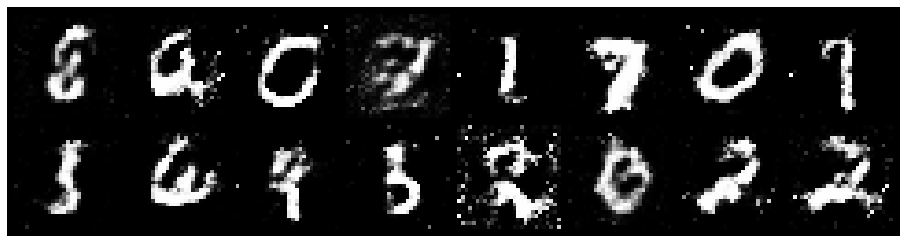

Epoch: [49/50], Batch Num: [100/600]
Discriminator Loss: 1.2539, Generator Loss: 0.9914
D(x): 0.5804, D(G(z)): 0.4360


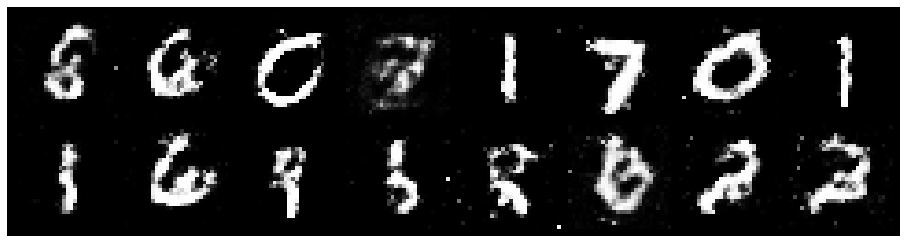

Epoch: [49/50], Batch Num: [200/600]
Discriminator Loss: 1.1840, Generator Loss: 1.1523
D(x): 0.5371, D(G(z)): 0.3350


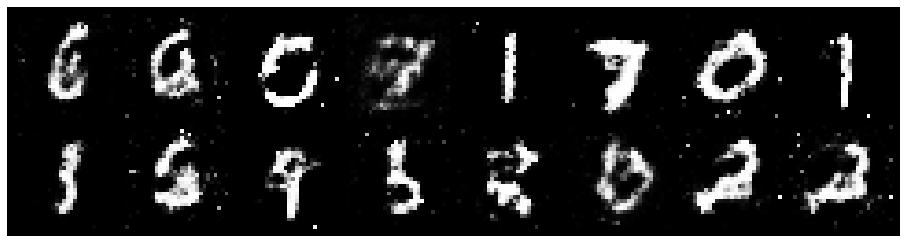

Epoch: [49/50], Batch Num: [300/600]
Discriminator Loss: 1.2243, Generator Loss: 1.1011
D(x): 0.5639, D(G(z)): 0.3709


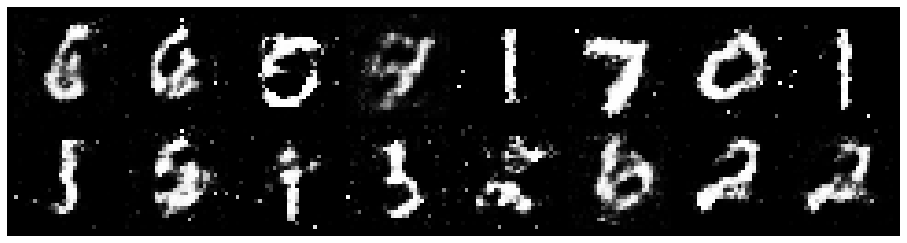

Epoch: [49/50], Batch Num: [400/600]
Discriminator Loss: 1.1982, Generator Loss: 0.7775
D(x): 0.5945, D(G(z)): 0.4447


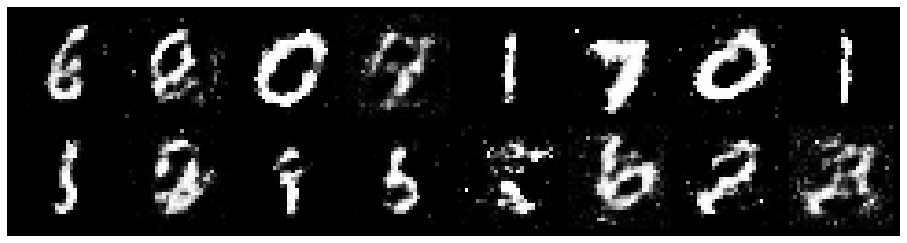

Epoch: [49/50], Batch Num: [500/600]
Discriminator Loss: 1.2292, Generator Loss: 1.0189
D(x): 0.5647, D(G(z)): 0.4032


In [132]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 50#200

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(image_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N).to(device)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data.to(device), fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N).to(device))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data.to("cpu")
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

In [125]:
test_images = vectors_to_images(generator(test_noise))

image = test_images.cpu().detach().numpy()
#plt.imshow(image[0][0], cmap='gray', interpolation='none')

## Resources

* https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

## Notes

* How is it possible that in train_discriminator, backward is called two times before taking a step in the optimizer? What is the result of doing this? A. Check Test notebook with the answer.

* Why when training discrimintator, the fake data has to be deatached. A. Because when training Discriminator, Generator gradients won't be calculated and since data was created from Generator it includes gradients.
* Sometimes when uisng training with cuda, model is not converging. Perhaps this also happens with CPU. A local minima maybe?